In [1]:
import os, gc, random
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm
from time import time, ctime

from sklearn.model_selection import KFold, GroupKFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam, AdamW
from torch.cuda.amp import autocast, GradScaler

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr, softmax

In [2]:
def get_logger(log_dir, logger_name="train_model.log"):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger_file = os.path.join(log_dir, logger_name)
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=logger_file, mode="a+")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
class ModelConfig:
    SEED = 20
    SPLIT_ENTROPY = 5.5
    MODEL_NAME = "EEGSeq_DilatedResNet_Deep_Reg"
    MODEL_BACKBONE = "wavenet"
    BATCH_SIZE = 16
    EPOCHS = 30
    EARLY_STOP_ROUNDS = 5
    GRADIENT_ACCUMULATION_STEPS = 1
    DROP_RATE = 0.15 # default: 0.1
    DROP_PATH_RATE = 0.25 # default: 0.2
    WEIGHT_DECAY = 0.01
    AMP = True
    PRINT_FREQ = 100
    NUM_WORKERS = 0 
    MAX_GRAD_NORM = 1e7
    REGULARIZATION = 2

In [4]:
N_GPU = torch.cuda.device_count()
if N_GPU > 1:
    DEVICE = torch.device("cuda")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
elif N_GPU == 1:
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

print("Use Device: ", DEVICE)

Use Device:  cuda:0


In [5]:
class KagglePaths:
    OUTPUT_DIR = "/kaggle/working/"
    PRE_LOADED_EEGS = '/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTROGRAMS = '/kaggle/input/brain-spectrograms/specs.npy'
    TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    TRAIN_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/"
    TEST_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
    TEST_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"
    TEST_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"


class LocalPaths:
    OUTPUT_DIR = "./outputs/"
    PRE_LOADED_EEGS = './inputs/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTROGRAMS = './inputs/brain-spectrograms/specs.npy'
    TRAIN_CSV = "./inputs/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "./inputs/hms-harmful-brain-activity-classification/train_eegs"
    TRAIN_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/train_spectrograms"
    TEST_CSV = "./inputs/hms-harmful-brain-activity-classification/test.csv"
    TEST_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/test_spectrograms"
    TEST_EEGS = "./inputs/hms-harmful-brain-activity-classification/test_eegs"

PATHS = KagglePaths if os.path.exists("/kaggle") else LocalPaths

print("Output Dir: ", PATHS.OUTPUT_DIR)

EEG_FEAT_ALL = [
    'Fp1', 'F3', 'C3', 'P3', 
    'F7', 'T3', 'T5', 'O1', 
    'Fz', 'Cz', 'Pz', 'Fp2', 
    'F4', 'C4', 'P4', 'F8', 
    'T4', 'T6', 'O2', 'EKG'
    ]

EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}

BRAIN_ACTIVITY = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
TARGETS = [f"{lb}_vote" for lb in BRAIN_ACTIVITY]
TARGETS_PRED = [f"{lb}_pred" for lb in BRAIN_ACTIVITY]

seed_everything(ModelConfig.SEED)

Output Dir:  ./outputs/


In [6]:
logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

# Load Data

In [7]:
def eeg_from_parquet(parquet_path: str, use_feature=EEG_FEAT_USE, display: bool = False) -> np.ndarray:
    # === Extract full length EEG Sequence ===
    # fill missing values with mean
    # first fill missing values with mean of each column
    # then if all values are missing, fill with 0
    eeg = pd.read_parquet(parquet_path, columns=use_feature)
    eeg = eeg.fillna(eeg.mean(skipna=True)).fillna(0)
    data = eeg.values.astype(np.float32)

    if display:
        fig, ax = plt.subplots(len(use_feature), 1, figsize=(10, 2*len(use_feature)), sharex=True)
        
        for i, feat in enumerate(use_feature):
            ax[i].plot(data[:, i], label=feat)
            ax[i].legend()
            ax[i].grid()
       
        name = parquet_path.split('/')[-1].split('.')[0]
        ax[0].set_title(f'EEG {name}',size=16)
        fig.tight_layout()
        plt.show()    
    return data

In [8]:
%%time
CREATE_EEGS = False
ALL_EEG_SIGNALS = {}
eeg_paths = list(Path(PATHS.TRAIN_EEGS).glob('*.parquet'))
preload_eegs_path = Path('./inputs/eegs_full.npy')

if CREATE_EEGS:
    count = 0
    for parquet_path in tqdm(eeg_paths, total=len(eeg_paths)):
        eeg_id = int(parquet_path.stem)
        eeg_path = str(parquet_path)
        data = eeg_from_parquet(eeg_path, display=False)
        ALL_EEG_SIGNALS[eeg_id] = data
        count += 1
    np.save("./inputs/eegs_full.npy", ALL_EEG_SIGNALS)
else:
    ALL_EEG_SIGNALS = np.load(preload_eegs_path, allow_pickle=True).item()

CPU times: user 190 ms, sys: 2.02 s, total: 2.21 s
Wall time: 2.21 s


In [9]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

print("targets: ", targets)

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)
train_csv['is_hard'] = (train_csv['entropy'] < 5.5).astype(int)

agg_dicts = {
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': ['min', 'max'],
    'eeg_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)],
    'patient_id': 'first',
    'expert_consensus': 'first',
    'total_votes': 'sum',
    'entropy': 'mean',
    'is_hard': 'mean'
}

for col in targets:
    agg_dicts[col] = 'sum'

train_all = train_csv.groupby(['eeg_id']+targets_prob).agg(agg_dicts).reset_index()

col_names = [
    'spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'eeg_off_sample', 
    'patient_id', 'target', 'total_votes', 'entropy', 'is_hard'
    ] + targets

train_all.columns = ["eeg_id"] + targets_prob + col_names
train_all.drop(targets_prob, axis=1, inplace=True)
train_all[targets] = train_all[targets].div(train_all['total_votes'], axis=0)
train_all['is_stage'] = 1
train_all.loc[(train_all['total_votes']>10) | (train_all['entropy']<5.5), 'is_stage'] = 2

class_count = (train_all['target']).value_counts().reset_index()
class_count['weight'] = class_count['count'].sum() / class_count['count']
class_count['weight_norm'] = class_count['weight'] / class_count['weight'].sum()

display(class_count)

train_all = train_all.merge(class_count[['target', 'weight_norm']], left_on='target', right_on='target', how='left')
train_all.rename(columns={'weight_norm': 'sample_weight'}, inplace=True)

print("train_all: ", train_all.shape)
print("hard samples ratio: ", train_all[train_all['is_hard']==1].shape[0] / train_all.shape[0])
print("easy samples ratio: ", train_all[train_all['is_hard']==0].shape[0] / train_all.shape[0])

K_FOLDS = 5
unique_eegs = train_all['eeg_id'].unique()
kf = KFold(n_splits=K_FOLDS)

train_all['fold'] = -1

for fold, (train_index, valid_index) in enumerate(kf.split(unique_eegs)):
    train_all.loc[train_all['eeg_id'].isin(unique_eegs[valid_index]), 'fold'] = fold

print("train_all: ", train_all.shape)
for fold in range(K_FOLDS):
    train_size = train_all[train_all['fold'] != fold].shape[0]
    valid_size = train_all[train_all['fold'] == fold].shape[0]
    train_hard_size = train_all[(train_all['fold'] != fold) & (train_all['is_stage'] == 2)].shape[0]
    valid_hard_size = train_all[(train_all['fold'] == fold) & (train_all['is_stage'] == 2)].shape[0]
    print(f"Fold {fold}: All Size: {train_size} | {valid_size}, Hard Size: {train_hard_size} | {valid_hard_size}")

train_all.head(15)

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,target,count,weight,weight_norm
0,Other,7694,2.568625,0.049945
1,Seizure,3762,5.253323,0.102147
2,LPD,3220,6.137578,0.119341
3,GPD,2028,9.745069,0.189486
4,GRDA,1928,10.250519,0.199314
5,LRDA,1131,17.473917,0.339768


train_all:  (19763, 20)
hard samples ratio:  0.2071547841926833
easy samples ratio:  0.7928452158073167
train_all:  (19763, 21)
Fold 0: All Size: 15754 | 4009, Hard Size: 9248 | 2364
Fold 1: All Size: 15812 | 3951, Hard Size: 9284 | 2328
Fold 2: All Size: 15844 | 3919, Hard Size: 9299 | 2313
Fold 3: All Size: 15805 | 3958, Hard Size: 9298 | 2314
Fold 4: All Size: 15837 | 3926, Hard Size: 9319 | 2293


,eeg_id,spectrogram_id,min,max,eeg_off_min,eeg_off_max,eeg_off_sample,patient_id,target,total_votes,...,is_hard,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,is_stage,sample_weight,fold
0,568657,789577333,0.0,16.0,0.0,16.0,0.0,20654,Other,48,...,1.0,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,2,0.049945,0
1,582999,1552638400,0.0,38.0,0.0,38.0,22.0,20230,LPD,154,...,1.0,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,2,0.119341,0
2,642382,14960202,1008.0,1032.0,0.0,24.0,24.0,5955,Other,2,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0.049945,0
3,751790,618728447,908.0,908.0,0.0,0.0,0.0,38549,GPD,1,...,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1,0.189486,0
4,778705,52296320,0.0,0.0,0.0,0.0,0.0,40955,Other,2,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0.049945,0
5,1629671,2036345030,0.0,160.0,0.0,160.0,126.0,37481,Seizure,51,...,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.102147,0
6,1895581,128369999,1138.0,1138.0,0.0,0.0,0.0,47999,Other,13,...,1.0,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,2,0.049945,0
7,2061593,320962633,1450.0,1450.0,0.0,0.0,0.0,23828,Other,1,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0.049945,0
8,2078097,2074135650,3342.0,3342.0,0.0,0.0,0.0,61174,Other,2,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0.049945,0
9,2366870,1232582129,0.0,30.0,0.0,30.0,0.0,23633,Other,18,...,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,2,0.049945,0


# Dataset

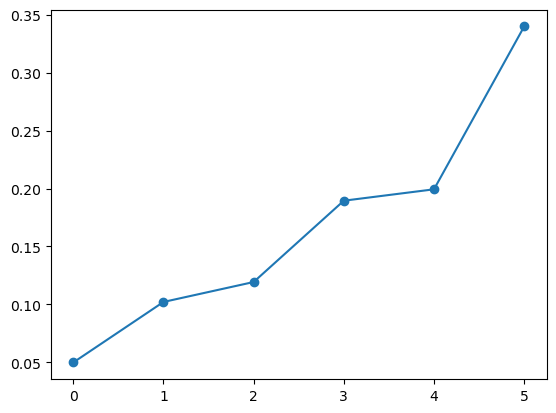

In [10]:
class_count = (train_all['target']).value_counts().reset_index()
class_count['weight'] = class_count['count'].sum() / class_count['count']
class_count['weight_norm'] = class_count['weight'] / class_count['weight'].sum()

plt.plot(np.arange(6), class_count['weight_norm'], 'o-')


In [12]:
# Functional Utils
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x #quantized

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [13]:
class EEGSeqDataset(Dataset):
    def __init__(self, df, config, eegs, mode='train', verbose=False):
        self.df = df
        self.mode = mode
        self.eegs = eegs
        self.verbose = verbose
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        X, y_prob, weight = self.__data_generation(idx)
        
        results = (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y_prob, dtype=torch.float32),
            torch.tensor(weight, dtype=torch.float32)
        )
        
        return results
    
    def __data_generation(self, index):
        row = self.df.iloc[index]

        if self.verbose:
            print(f"Row {index}", row[['eeg_id', 'eeg_off_min', 'eeg_off_max', 'target']].tolist())

        X = np.zeros((10_000, 8), dtype='float32')
        
        # start_sec = int((row['eeg_off_min'] + row['eeg_off_max']) // 2)
        # !!! use randomly sampled offset !!!
        start_sec = int(row['eeg_off_sample']) 
        data = self.eegs[row.eeg_id][start_sec*200 : (start_sec+50)*200]

        # === Feature engineering ===
        X[:,0] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
        X[:,1] = data[:,EEF_FEAT_INDEX['T3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,2] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['C3']]
        X[:,3] = data[:,EEF_FEAT_INDEX['C3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,4] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['C4']]
        X[:,5] = data[:,EEF_FEAT_INDEX['C4']] - data[:,EEF_FEAT_INDEX['O2']]

        X[:,6] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['T4']]
        X[:,7] = data[:,EEF_FEAT_INDEX['T4']] - data[:,EEF_FEAT_INDEX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        # !!! change to bandpass filter (low=0.5, hight=20, order=2) !!!
        # X = butter_lowpass_filter(X)
        X = butter_bandpass_filter(X, .5, 20, 200, order=2)

        if self.mode != 'test':
            y_prob = row[TARGETS].values.astype(np.float32)
            weight = row['sample_weight']
        else:
            y_prob = np.zeros(6, dtype='float32')
            weight = 1.0

        # downsample by 5
        return X[::5, :], y_prob, weight


In [14]:
# visualize the dataset

# train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
# train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# for batch in train_loader:
#     X, y, weights = batch
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
#     print(f"weight shape: {weights.shape}")
    
#     fig, axes = plt.subplots(4, 1, figsize=(20, 20))
#     ax_idx = 0
#     for item in np.random.choice(range(X.shape[0]), 4):
#         offset = 0
#         for col in range(X.shape[-1]):
#             if col != 0:
#                 offset -= X[item,:,col].min()
#             axes[ax_idx].plot(np.arange(X.shape[1]), X[item,:,col]+offset, label=f'feature {col+1}')
#             offset += X[item,:,col].max()
#         print(y[item])
#         axes[ax_idx].set_title(f'Weight = {weights[item]}',size=14)
#         axes[ax_idx].legend()
#         ax_idx += 1
#     fig.tight_layout()
#     plt.show()
#     break
# del train_dataset, train_loader
# torch.cuda.empty_cache()
# gc.collect()

# Model

### Sequencial GRU Encoder

In [15]:
# class SeqGRUEncoder(nn.Module):
#     def __init__(self, in_channels, hidden_size=128, num_layers=2, bidirectional=True):
#         super(SeqGRUEncoder, self).__init__()

#         self.in_channels = in_channels

#         # Initialize the GRU to have 128 hidden units per direction and to be bidirectional
#         self.rnn = nn.GRU(
#             input_size=in_channels, 
#             hidden_size=hidden_size, 
#             num_layers=num_layers,
#             bidirectional=bidirectional, 
#             batch_first=True
#         )
        
#         # Initialize the attention mechanism
#         if bidirectional:
#             emb_dim = 2 * hidden_size
#         else:
#             emb_dim = hidden_size
        
#         self.attention_dense = nn.Linear(emb_dim, 1)
#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, x):
#         # x shape: [batch, seq_len, in_channels]
#         rnn_out, _ = self.rnn(x)  # -> [batch, seq_len, emb_dim]
#         identity = rnn_out
#         scores = self.attention_dense(rnn_out).squeeze(-1)
#         scores = self.softmax(scores).unsqueeze(1)
#         pooled_out = torch.matmul(scores, identity).squeeze(1)
#         # -> [batch_size, emb_dim]
#         return pooled_out

### Resnet 1D Encoder

In [16]:
# class ResNet_1D_Block(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, dropout=0.0):
#         super(ResNet_1D_Block, self).__init__()
#         self.block = nn.Sequential(
#             nn.BatchNorm1d(num_features=in_channels),
#             nn.ReLU(),
#             nn.Dropout(p=dropout),
#             nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.BatchNorm1d(num_features=out_channels),
#             nn.ReLU(),
#             nn.Dropout(p=dropout),
#             nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
#         self.downsampling = downsampling
#         self._initialize_weights()
        
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv1d):
#                 nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm1d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         identity = self.downsampling(x)
#         out = self.block(x)
#         out += identity
#         return out
    
    
# class ResNet_1D_Encoder(nn.Module):
#     def __init__(self, kernels=[3,7,9,11], planes=24, in_channels=8, fixed_kernel_size=5, n_blocks=9, dropout=0.0):
#         super(ResNet_1D_Encoder, self).__init__()

#         self.parallel_conv = nn.ModuleList([
#             nn.Conv1d(
#                 in_channels=in_channels, 
#                 out_channels=planes, 
#                 kernel_size=kernel_size,
#                 stride=1, 
#                 padding=0, 
#                 bias=False
#             ) for kernel_size in kernels
#         ])

#         self.resnet_layer = ResNet_1D_Block(
#             in_channels=planes, 
#             out_channels=planes, 
#             kernel_size=fixed_kernel_size,
#             stride=1, 
#             padding=fixed_kernel_size//2, 
#             downsampling=nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
#             dropout=dropout
#         )
        
#         self.resnet_part = nn.Sequential(
#             nn.BatchNorm1d(num_features=planes),
#             nn.ReLU(inplace=False),
#             nn.Conv1d(
#                 in_channels=planes, 
#                 out_channels=planes, 
#                 kernel_size=fixed_kernel_size, 
#                 stride=2, 
#                 padding=2, 
#                 bias=False
#             ),
#             *[
#                 ResNet_1D_Block(
#                     in_channels=planes,
#                     out_channels=planes,
#                     kernel_size=fixed_kernel_size,
#                     stride=1,
#                     padding=fixed_kernel_size//2,
#                     downsampling=nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
#                     dropout=dropout
#                     ) 
#                 for _ in range(n_blocks)
#             ],
#             nn.BatchNorm1d(num_features=planes),
#             nn.ReLU(),
#             nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
#         )

#     def forward(self, x):
#         # x shape: [batch, seq_len, in_channels]
#         # print("Resnet Input Shape: ", x.shape)
#         x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
       
#         out_sep = [conv(x) for conv in self.parallel_conv]
#         out = torch.cat(out_sep, dim=2)
#         out = self.resnet_part(out)
        
#         # Return the flattened features from the last convolutional layer
#         features = out.reshape(out.shape[0], -1)
#         return features


### Dilated Inception Wavenet Encoder

In [17]:
# from typing import List

# class DilatedInception(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int, kernel_sizes: List[int], dilation: int) -> None:
#         super().__init__()
#         assert out_channels % len(kernel_sizes) == 0, "`out_channels` must be divisible by the number of kernel sizes."
#         hidden_dim = out_channels // len(kernel_sizes)
#         self.convs = nn.ModuleList([
#             nn.Conv1d(in_channels, hidden_dim, k, padding='same', dilation=dilation)
#             for k in kernel_sizes
#         ])

#     def forward(self, x):
#         outputs = [conv(x) for conv in self.convs]
#         out = torch.cat(outputs, dim=1)
#         return out

# class GatedTCN(nn.Module):
#     def __init__(self, in_dim: int, h_dim: int, kernel_sizes: List[int], dilation_factor: int, dropout: float = 0.0) -> None:
#         super().__init__()
#         self.filt = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
#         self.gate = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         x_filt = torch.tanh(self.filt(x))
#         x_gate = torch.sigmoid(self.gate(x))
#         h = x_filt * x_gate
#         h = self.dropout(h)
#         return h

# class WaveBlock(nn.Module):
#     def __init__(self, n_layers: int, in_dim: int, h_dim: int, kernel_sizes: List[int]) -> None:
#         super().__init__()
#         self.dilation_rates = [2**i for i in range(n_layers)]
#         self.in_conv = nn.Conv1d(in_dim, h_dim, kernel_size=1)
#         self.gated_tcns = nn.ModuleList([
#             GatedTCN(h_dim, h_dim, kernel_sizes, dilation)
#             for dilation in self.dilation_rates
#         ])
#         self.skip_convs = nn.ModuleList([
#             nn.Conv1d(h_dim, h_dim, kernel_size=1)
#             for _ in range(n_layers)
#             ])
#         self._initialize_weights()

#     def _initialize_weights(self):
#         nn.init.xavier_uniform_(self.in_conv.weight, gain=nn.init.calculate_gain('relu'))
#         nn.init.zeros_(self.in_conv.bias)
#         for conv in self.skip_convs:
#             nn.init.xavier_uniform_(conv.weight, gain=nn.init.calculate_gain('relu'))
#             nn.init.zeros_(conv.bias)

#     def forward(self, x):
#         # x: (B, C, L)
#         x = self.in_conv(x)
#         x_skip = x
#         for gated_tcn, skip_conv in zip(self.gated_tcns, self.skip_convs):
#             x = gated_tcn(x)
#             x = skip_conv(x)
#             x_skip = x_skip + x
#         return x_skip

# class DilatedWaveNet(nn.Module):
#     """WaveNet architecture with dilated inception conv, enhanced with list comprehension for input processing."""

#     def __init__(self, kernel_sizes: List[int]) -> None:
#         super().__init__()
#         self.kernel_sizes = kernel_sizes
        
#         # Initialize wave blocks with specified kernel sizes
#         self.wave_module = nn.Sequential(
#             WaveBlock(9, 8, 128, self.kernel_sizes), #12
#             WaveBlock(6, 128, 256, self.kernel_sizes), #8
#             WaveBlock(3, 256, 512, self.kernel_sizes), #4
#             WaveBlock(1, 512, 512, self.kernel_sizes), #1
#         )
#         self.pool_layer = nn.AdaptiveAvgPool1d(1)

#     def forward(self, x) -> torch.Tensor:
#         # x: (B, L, C)
#         bs, seq_len, n_channels = x.shape
#         x = x.permute(0, 2, 1) # -> (B, C, L)
#         # Process different parts of the input with list comprehension
#         x = self.wave_module(x)
#         x = self.pool_layer(x) # ->(B, 512, 1)
#         x = x.reshape(bs, n_channels, -1).reshape(bs, n_channels//2, 2, 64)
#         features = x.mean(dim=2).reshape(bs, -1) # -> (16, 256)
# #         pooled_outputs = [(x[:, i:i+64] + x[:, i+64:i+128]) / 2 for i in range(0, n_channels, 2)]
# #         # Combine the pooled features and reshape for classification
# #         features = torch.cat(pooled_outputs, dim=1).reshape(bs, -1)
       
#         return features

### Dilated ResNet 1D Encoder

In [18]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, dropout=0.0):
        super(ResnetBlock, self).__init__()

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size, 
            stride=stride, 
            padding=dilation*(kernel_size//2), 
            dilation=dilation, 
            bias=False)
        self.drop1 = nn.Dropout(p=dropout)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size, 
            stride=stride, 
            padding=dilation*(kernel_size//2), 
            dilation=dilation, 
            bias=False)
        
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.relu3 = nn.ReLU()
        self.downsample = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        identity = x
        identity = self.downsample(identity)

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.drop1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        out = self.conv2(out)

        out = self.downsample(out)

        out += identity
        out = self.bn3(out)
        out = self.relu3(out)

        return out

class DilatedResnet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, n_layers, expansion_factor=4):
        super(DilatedResnet, self).__init__()

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.h_dim = out_channels // n_layers
        
        fix_kernel_size = 5
        self.conv1 = nn.Conv1d(
            self.in_channels, self.h_dim, kernel_size=fix_kernel_size, stride=1, padding=fix_kernel_size//2
            )

        dilation_rates = [expansion_factor**i for i in range(n_layers)]

        self.blocks = nn.ModuleList([
            ResnetBlock(self.h_dim, self.h_dim, self.kernel_size, dilation=dilation)
            for dilation in dilation_rates
        ])

    def forward(self, x):
        x = self.conv1(x)
        outputs = [ block(x) for block in self.blocks ]
        output = torch.cat(outputs, dim=1)
        
        return output

class DilatedResnetEncoder(nn.Module):
    def __init__(self, kernel_sizes=[3, 5, 7, 9], in_channels=8, planes=24, dilate_layers=[6,3,1], expansion_factor=4):
        super(DilatedResnetEncoder, self).__init__()

        self.in_channels = in_channels
        self.planes = planes
        self.kernel_sizes = kernel_sizes
        self.dilate_layers = dilate_layers # must be 3 layers
        self.expansion_factor = expansion_factor
        
        # out_channels = self.planes * self.in_channels
        # fix_kernel_size = 5
        # self.conv1 = nn.Conv1d(
        #     self.in_channels, out_channels, kernel_size=fix_kernel_size, stride=1, padding=fix_kernel_size//2
        #     )
        
        self.blocks = nn.ModuleList([
            self._make_dilated_block(kernel_size)
            for kernel_size in self.kernel_sizes
        ])

        bottleneck_in_channels = self.in_channels * self.planes * self.dilate_layers[1] * self.dilate_layers[2]
        bottoleneck_out_channels = self.in_channels * self.planes

        self.bottleneck = nn.Sequential(
            nn.BatchNorm1d(num_features=bottleneck_in_channels),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=bottleneck_in_channels,
                out_channels=bottoleneck_out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            )
        )
        
        self.pooling = nn.AdaptiveAvgPool1d(1)
        # self.blocks = nn.ModuleList([
        #     nn.Sequential(*[
        #         ResidualBlock(
        #             out_channels, out_channels, kernel_size, dilation=dilation
        #         ) for dilation in self.dilate_layers
        #     ])
        #     for kernel_size in self.kernel_sizes
        # ])

    def _make_dilated_block(self, kernel_size):
        out_channel_1 = self.in_channels * self.planes
        block_1 = DilatedResnet(self.in_channels, out_channel_1, kernel_size, self.dilate_layers[0], self.expansion_factor)

        out_channel_2 = out_channel_1 * self.dilate_layers[1]
        block_2 = DilatedResnet(out_channel_1, out_channel_2, kernel_size, self.dilate_layers[1], self.expansion_factor)

        out_channel_3 = out_channel_2 * self.dilate_layers[2]
        block_3 = DilatedResnet(out_channel_2, out_channel_3, kernel_size, self.dilate_layers[2], self.expansion_factor)

        return nn.Sequential(block_1, block_2, block_3)
        
    
    def forward(self, x):
        # <- # [batch_size, seq_len=2000, in_channels=8]
        x = x.permute(0, 2, 1)
        # x = self.conv1(x)
        outputs = [ block(x) for block in self.blocks ]
        outputs = [ self.bottleneck(out) for out in outputs ]
        output = torch.cat(outputs, dim=1)
        output = self.pooling(output).squeeze(-1)
        
        return output

### EEGSeqClassifier 

In [19]:
class EEGSeqClassifier(nn.Module):
    def __init__(self, config, num_classes=6):
        super(EEGSeqClassifier, self).__init__()

        # self.seqgru = SeqGRUEncoder(in_channels=8, hidden_size=128, num_layers=2, bidirectional=True)
        # self.resnet = ResNet_1D_Encoder(
        #     kernels=[3, 5, 7, 9, 11], 
        #     planes=24, 
        #     in_channels=8, 
        #     fixed_kernel_size=5, 
        #     n_blocks=8, 
        #     dropout=0.0
        # )
        # self.wavenet = DilatedWaveNet(kernel_sizes=[2, 3, 6, 7])
        self.dilated_resnet = DilatedResnetEncoder(
            kernel_sizes=[3, 5, 7, 9], 
            in_channels=8, 
            planes=24, 
            dilate_layers=[6,3,1], 
            expansion_factor=4
        )

        hidden_dim = 768 #72 + 256 #+ 256
        self.predict_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]

        # resnet_out = self.resnet(x)
        # seqgru_out = self.seqgru(x)
        # wavenet_out = self.wavenet(x)
        # features = torch.cat([seqgru_out, resnet_out], dim=1)
        features = self.dilated_resnet(x)
        logits = self.predict_head(features)
        return logits

In [20]:
# train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
# train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# model = EEGSeqClassifier(ModelConfig, num_classes=6)
# model.to(DEVICE)
# for i, batch in enumerate(train_loader):
#     X, y, weights = batch
#     X = X.to(DEVICE)
#     y = y.to(DEVICE)
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
    
#     y_pred = model(X)
#     print(y_pred.shape)
#     break 

# del model, train_dataset, train_loader, X, y
# torch.cuda.empty_cache()
# gc.collect()

In [21]:
!nvidia-smi

Tue Apr  2 19:56:45 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 26%   33C    P8     5W / 260W |     15MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Train

In [22]:
import warnings
warnings.filterwarnings("ignore")

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class Trainer:

    def __init__(self, model, config, logger):

        self.model = model
        self.logger = logger
        self.config = config
        
        self.early_stop_rounds = config.EARLY_STOP_ROUNDS
        self.early_stop_counter = 0
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.kl_div_loss = nn.KLDivLoss(reduction='none')
        self.gamma = config.REGULARIZATION
        
        # self.criterion = nn.KLDivLoss(reduction="batchmean")
    
    def criterion(self, y_pred, y_true, weights, mode='train'):
        kl_loss = self.kl_div_loss(F.log_softmax(y_pred, dim=1), y_true).sum(dim=1)  # Compute KL divergence
        if (self.gamma is not None) & (mode == 'train'):
            softmax_probs = F.softmax(y_pred, dim=1)  # Compute softmax probabilities
            self_entropy_loss = -(softmax_probs * torch.log(softmax_probs + 1e-9)).sum(dim=1) # Compute entropy, add epsilon to avoid log(0)
            return (weights * (kl_loss - self.gamma * self_entropy_loss)).sum() / weights.sum()
        else:
            return (weights * kl_loss).sum() / weights.sum()
        
    def train(self, train_loader, valid_loader, from_checkpoint=None):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.WEIGHT_DECAY)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=1e-4,
            epochs=self.config.EPOCHS,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=100,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("inf")
        loss_records = {"train": [], "valid": []}

        for epoch in range(self.config.EPOCHS):
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False)

            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch

            info = f"{'-' * 100}\nEpoch {epoch + 1} - "
            info += f"Average Loss: (train) {train_loss:.4f}; (valid) {valid_loss:.4f} | Time: {elapsed:.2f}s"
            self.logger.info(info)

            if valid_loss < best_loss:
                best_loss = valid_loss
                best_weights = self.model.state_dict()
                best_preds = valid_preds
                self.logger.info(f"Best model found in epoch {epoch + 1} | valid loss: {best_loss:.4f}")
                self.early_stop_counter = 0
            
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.early_stop_rounds:
                    self.logger.info(f"Early stopping at epoch {epoch + 1}")
                    break

        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.AMP)
        loss_meter, predicts_record = AverageMeter(), []

        start = time()
        pbar = tqdm(dataloader, total=len(dataloader), unit="batch", desc=f"{mode} [{epoch_id}]")
        for step, (X, y, w) in enumerate(pbar):
            X, y, w = X.to(self.device), y.to(self.device), w.to(self.device)

            if is_train:
                with autocast(enabled=self.config.AMP):
                    y_pred = self.model(X)
                    loss = self.criterion(y_pred, y, w)
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.MAX_GRAD_NORM)
                if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
            else:
                with torch.no_grad():
                    y_pred = self.model(X)
                    loss = self.criterion(y_pred, y, torch.ones_like(w), mode='valid')
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                
                predicts_record.append(y_pred.to('cpu').numpy())
            
            loss_meter.update(loss.item(), y.size(0))
            end = time()

            if (step % self.config.PRINT_FREQ == 0) or (step == (len_loader - 1)):
                lr = self.scheduler.get_last_lr()[0]
                info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} Loss: {loss_meter.avg:.4f}"
                if is_train:
                    info += f" Grad: {grad_norm:.4f} LR: {lr:.4e}"
                info += f" | Elapse: {end - start:.2f}s"
                print(info)

        if not is_train:
            predicts_record = np.concatenate(predicts_record)
            
        return loss_meter.avg, predicts_record


In [23]:
def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = EEGSeqDataset(train_folds, ModelConfig, ALL_EEG_SIGNALS, mode="train")
    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=None, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=None, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

In [24]:
def evaluate_oof(oof_df):
    '''
    Evaluate the out-of-fold dataframe using KL Divergence (torch and kaggle)
    '''
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[TARGETS].values.astype('float32'))
    preds = F.log_softmax(
        torch.tensor(oof_df[TARGETS_PRED].values.astype('float32'), requires_grad=False),
        dim=1
    )
    kl_torch = kl_loss(preds, labels).item()

    return kl_torch

In [25]:
# Major Train Loop
# ================== Logger ==================
logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

# ================== Prepare Training ==================
oof_stage_1 = pd.DataFrame()
loss_history_1 = []
tik_total = time()

# ================== Stage 1: Train ====================
logger.info(f"{'=' * 100}\nStage 1: Train ResNetGRU\n{'=' * 100}")
for fold in range(K_FOLDS):
    tik = time()

    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    # model = ResNetGRU( ModelConfig, num_classes=6 )
    model = EEGSeqClassifier(ModelConfig, num_classes=6)
    
    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    ## STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold} || Valid: {valid_folds.shape[0]}; \n{'=' * 100}")
    logger.info(f"- Train: {train_folds.shape[0]}; Epoch = {ModelConfig.EPOCHS}; Dropout = {ModelConfig.RESNET_GRU_DROPOUT} -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

info = f"{'=' * 100}\nStage 1 Training Complete!\n"
cv_results = evaluate_oof(oof_stage_1)
info += f"CV Result (Stage 1): {cv_results}\n"
info += f"Elapse: {(time() - tik_total) / 60:.2f} min \n{'=' * 100}"
logger.info(info)


****************************************************************************************************
Script Start: Tue Apr  2 19:56:50 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: EEGSeq_DilatedResNet_Deep_Reg
MODEL_BACKBONE: wavenet
BATCH_SIZE: 16
EPOCHS: 30
EARLY_STOP_ROUNDS: 5
GRADIENT_ACCUMULATION_STEPS: 1
DROP_RATE: 0.15
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
AMP: True
PRINT_FREQ: 100
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
REGULARIZATION: 2
****************************************************************************************************
Stage 1: Train ResNetGRU
Fold: 0 || Valid: 4009; 
- Train: 15754; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 1 [0/984] | Train Loss: -2.0369 Grad: 342127.5625 LR: 4.0000e-06 | Elapse: 1.10s
Epoch 1 [100/984] | Train Loss: -2.1720 Grad: 122631.6641 LR: 4.2772e-06 | Elapse: 13.45s
Epoch 1 [200/984] | Train Loss: -2.1823 Grad: 217191.4688 LR: 5.0947e-06 | Elapse: 25.69s
Epoch 1 [300/984] | Train Loss: -2.1932 Grad: 402943.9375 LR: 6.4434e-06 | Elapse: 38.01s
Epoch 1 [400/984] | Train Loss: -2.2046 Grad: 199671.8906 LR: 8.3078e-06 | Elapse: 50.33s
Epoch 1 [500/984] | Train Loss: -2.2083 Grad: 197364.5469 LR: 1.0667e-05 | Elapse: 62.80s
Epoch 1 [600/984] | Train Loss: -2.2099 Grad: 334309.9062 LR: 1.3494e-05 | Elapse: 75.21s
Epoch 1 [700/984] | Train Loss: -2.2119 Grad: 209621.2656 LR: 1.6757e-05 | Elapse: 87.66s
Epoch 1 [800/984] | Train Loss: -2.2140 Grad: 299807.4375 LR: 2.0419e-05 | Elapse: 100.17s
Epoch 1 [900/984] | Train Loss: -2.2187 Grad: 185351.8281 LR: 2.4439e-05 | Elapse: 112.60s
Epoch 1 [983/984] | Train Loss: -2.2199 Grad: 158159.8438 LR: 2.8015e-05 | Elapse: 122.89s


Valid [0]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 1 [0/251] | Valid Loss: 1.3342 | Elapse: 0.11s
Epoch 1 [100/251] | Valid Loss: 1.3560 | Elapse: 9.91s
Epoch 1 [200/251] | Valid Loss: 1.3434 | Elapse: 19.71s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) -2.2199; (valid) 1.3393 | Time: 147.48s
Best model found in epoch 1 | valid loss: 1.3393


Epoch 1 [250/251] | Valid Loss: 1.3393 | Elapse: 24.59s


Train [1]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 2 [0/984] | Train Loss: -2.2760 Grad: 198408.1875 LR: 2.8059e-05 | Elapse: 0.13s
Epoch 2 [100/984] | Train Loss: -2.2307 Grad: 133261.2188 LR: 3.2615e-05 | Elapse: 12.64s
Epoch 2 [200/984] | Train Loss: -2.2319 Grad: 182902.2969 LR: 3.7391e-05 | Elapse: 25.19s
Epoch 2 [300/984] | Train Loss: -2.2374 Grad: 267475.5625 LR: 4.2332e-05 | Elapse: 37.65s
Epoch 2 [400/984] | Train Loss: -2.2477 Grad: 188354.1250 LR: 4.7383e-05 | Elapse: 50.13s
Epoch 2 [500/984] | Train Loss: -2.2484 Grad: 99666.5078 LR: 5.2485e-05 | Elapse: 62.63s
Epoch 2 [600/984] | Train Loss: -2.2506 Grad: 203575.8438 LR: 5.7583e-05 | Elapse: 75.13s
Epoch 2 [700/984] | Train Loss: -2.2525 Grad: 140803.1875 LR: 6.2617e-05 | Elapse: 87.73s
Epoch 2 [800/984] | Train Loss: -2.2542 Grad: 156545.2656 LR: 6.7531e-05 | Elapse: 100.34s
Epoch 2 [900/984] | Train Loss: -2.2591 Grad: 119965.0156 LR: 7.2269e-05 | Elapse: 112.91s
Epoch 2 [983/984] | Train Loss: -2.2611 Grad: 114948.7266 LR: 7.6029e-05 | Elapse: 123.41s


Valid [1]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 2 [0/251] | Valid Loss: 1.2817 | Elapse: 0.11s
Epoch 2 [100/251] | Valid Loss: 1.2856 | Elapse: 10.04s
Epoch 2 [200/251] | Valid Loss: 1.2734 | Elapse: 19.99s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) -2.2611; (valid) 1.2717 | Time: 148.33s
Best model found in epoch 2 | valid loss: 1.2717


Epoch 2 [250/251] | Valid Loss: 1.2717 | Elapse: 24.91s


Train [2]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 3 [0/984] | Train Loss: -2.3001 Grad: 156016.2969 LR: 7.6074e-05 | Elapse: 0.14s
Epoch 3 [100/984] | Train Loss: -2.2743 Grad: 91842.7266 LR: 8.0350e-05 | Elapse: 12.77s
Epoch 3 [200/984] | Train Loss: -2.2766 Grad: 139926.3594 LR: 8.4305e-05 | Elapse: 25.32s
Epoch 3 [300/984] | Train Loss: -2.2801 Grad: 173336.8906 LR: 8.7895e-05 | Elapse: 37.97s
Epoch 3 [400/984] | Train Loss: -2.2894 Grad: 172982.1719 LR: 9.1078e-05 | Elapse: 50.59s
Epoch 3 [500/984] | Train Loss: -2.2898 Grad: 102092.1172 LR: 9.3818e-05 | Elapse: 63.13s
Epoch 3 [600/984] | Train Loss: -2.2911 Grad: 131180.7812 LR: 9.6085e-05 | Elapse: 75.73s
Epoch 3 [700/984] | Train Loss: -2.2924 Grad: 121311.4844 LR: 9.7853e-05 | Elapse: 88.35s
Epoch 3 [800/984] | Train Loss: -2.2929 Grad: 122769.3125 LR: 9.9102e-05 | Elapse: 100.94s
Epoch 3 [900/984] | Train Loss: -2.2966 Grad: 96183.6562 LR: 9.9817e-05 | Elapse: 113.48s
Epoch 3 [983/984] | Train Loss: -2.2981 Grad: 93531.6016 LR: 1.0000e-04 | Elapse: 123.94s


Valid [2]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 3 [0/251] | Valid Loss: 1.2901 | Elapse: 0.11s
Epoch 3 [100/251] | Valid Loss: 1.2623 | Elapse: 10.01s
Epoch 3 [200/251] | Valid Loss: 1.2512 | Elapse: 19.89s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) -2.2981; (valid) 1.2501 | Time: 148.73s
Best model found in epoch 3 | valid loss: 1.2501


Epoch 3 [250/251] | Valid Loss: 1.2501 | Elapse: 24.79s


Train [3]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 4 [0/984] | Train Loss: -2.3182 Grad: 126302.1016 LR: 1.0000e-04 | Elapse: 0.13s
Epoch 4 [100/984] | Train Loss: -2.3067 Grad: 75032.2344 LR: 9.9996e-05 | Elapse: 12.72s
Epoch 4 [200/984] | Train Loss: -2.3079 Grad: 122551.6094 LR: 9.9986e-05 | Elapse: 25.22s
Epoch 4 [300/984] | Train Loss: -2.3113 Grad: 147745.0781 LR: 9.9968e-05 | Elapse: 37.78s
Epoch 4 [400/984] | Train Loss: -2.3192 Grad: 164526.6719 LR: 9.9944e-05 | Elapse: 50.38s
Epoch 4 [500/984] | Train Loss: -2.3201 Grad: 77738.8750 LR: 9.9912e-05 | Elapse: 62.97s
Epoch 4 [600/984] | Train Loss: -2.3217 Grad: 112280.5000 LR: 9.9873e-05 | Elapse: 75.54s
Epoch 4 [700/984] | Train Loss: -2.3228 Grad: 112352.9609 LR: 9.9828e-05 | Elapse: 88.11s
Epoch 4 [800/984] | Train Loss: -2.3226 Grad: 108756.3828 LR: 9.9775e-05 | Elapse: 100.65s
Epoch 4 [900/984] | Train Loss: -2.3258 Grad: 90348.2500 LR: 9.9716e-05 | Elapse: 113.18s
Epoch 4 [983/984] | Train Loss: -2.3270 Grad: 83165.0312 LR: 9.9661e-05 | Elapse: 123.56s


Valid [3]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 4 [0/251] | Valid Loss: 1.2751 | Elapse: 0.10s
Epoch 4 [100/251] | Valid Loss: 1.2330 | Elapse: 10.00s
Epoch 4 [200/251] | Valid Loss: 1.2243 | Elapse: 19.91s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) -2.3270; (valid) 1.2229 | Time: 148.39s
Best model found in epoch 4 | valid loss: 1.2229


Epoch 4 [250/251] | Valid Loss: 1.2229 | Elapse: 24.83s


Train [4]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 5 [0/984] | Train Loss: -2.3365 Grad: 108746.5156 LR: 9.9661e-05 | Elapse: 0.14s
Epoch 5 [100/984] | Train Loss: -2.3309 Grad: 70366.4609 LR: 9.9588e-05 | Elapse: 12.85s
Epoch 5 [200/984] | Train Loss: -2.3319 Grad: 118251.8203 LR: 9.9509e-05 | Elapse: 25.40s
Epoch 5 [300/984] | Train Loss: -2.3348 Grad: 140657.5000 LR: 9.9423e-05 | Elapse: 38.08s
Epoch 5 [400/984] | Train Loss: -2.3416 Grad: 113146.7109 LR: 9.9330e-05 | Elapse: 50.61s
Epoch 5 [500/984] | Train Loss: -2.3426 Grad: 62360.7344 LR: 9.9230e-05 | Elapse: 63.25s
Epoch 5 [600/984] | Train Loss: -2.3441 Grad: 108984.9375 LR: 9.9124e-05 | Elapse: 75.75s
Epoch 5 [700/984] | Train Loss: -2.3451 Grad: 101478.2031 LR: 9.9010e-05 | Elapse: 88.33s
Epoch 5 [800/984] | Train Loss: -2.3444 Grad: 100699.3750 LR: 9.8890e-05 | Elapse: 100.83s
Epoch 5 [900/984] | Train Loss: -2.3474 Grad: 93374.9219 LR: 9.8762e-05 | Elapse: 113.32s
Epoch 5 [983/984] | Train Loss: -2.3486 Grad: 79288.9922 LR: 9.8651e-05 | Elapse: 123.69s


Valid [4]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 5 [0/251] | Valid Loss: 1.2666 | Elapse: 0.10s
Epoch 5 [100/251] | Valid Loss: 1.2106 | Elapse: 10.01s
Epoch 5 [200/251] | Valid Loss: 1.2030 | Elapse: 19.90s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) -2.3486; (valid) 1.2018 | Time: 148.49s
Best model found in epoch 5 | valid loss: 1.2018


Epoch 5 [250/251] | Valid Loss: 1.2018 | Elapse: 24.80s


Train [5]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 6 [0/984] | Train Loss: -2.3382 Grad: 108132.0156 LR: 9.8650e-05 | Elapse: 0.13s
Epoch 6 [100/984] | Train Loss: -2.3497 Grad: 77205.1797 LR: 9.8510e-05 | Elapse: 12.69s
Epoch 6 [200/984] | Train Loss: -2.3509 Grad: 115144.8516 LR: 9.8364e-05 | Elapse: 25.25s
Epoch 6 [300/984] | Train Loss: -2.3542 Grad: 121189.2031 LR: 9.8210e-05 | Elapse: 37.83s
Epoch 6 [400/984] | Train Loss: -2.3602 Grad: 95509.5312 LR: 9.8050e-05 | Elapse: 50.38s
Epoch 6 [500/984] | Train Loss: -2.3618 Grad: 53951.2891 LR: 9.7883e-05 | Elapse: 62.89s
Epoch 6 [600/984] | Train Loss: -2.3630 Grad: 97541.3516 LR: 9.7710e-05 | Elapse: 75.40s
Epoch 6 [700/984] | Train Loss: -2.3639 Grad: 99866.7891 LR: 9.7530e-05 | Elapse: 87.92s
Epoch 6 [800/984] | Train Loss: -2.3634 Grad: 98253.2344 LR: 9.7343e-05 | Elapse: 100.44s
Epoch 6 [900/984] | Train Loss: -2.3666 Grad: 102323.2031 LR: 9.7149e-05 | Elapse: 112.99s
Epoch 6 [983/984] | Train Loss: -2.3677 Grad: 77631.8281 LR: 9.6984e-05 | Elapse: 123.39s


Valid [5]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 6 [0/251] | Valid Loss: 1.2504 | Elapse: 0.11s
Epoch 6 [100/251] | Valid Loss: 1.1853 | Elapse: 10.11s
Epoch 6 [200/251] | Valid Loss: 1.1795 | Elapse: 20.07s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) -2.3677; (valid) 1.1786 | Time: 148.39s
Best model found in epoch 6 | valid loss: 1.1786


Epoch 6 [250/251] | Valid Loss: 1.1786 | Elapse: 25.00s


Train [6]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 7 [0/984] | Train Loss: -2.3480 Grad: 108179.6719 LR: 9.6982e-05 | Elapse: 0.14s
Epoch 7 [100/984] | Train Loss: -2.3700 Grad: 83492.6250 LR: 9.6776e-05 | Elapse: 12.67s
Epoch 7 [200/984] | Train Loss: -2.3695 Grad: 100060.5625 LR: 9.6564e-05 | Elapse: 25.27s
Epoch 7 [300/984] | Train Loss: -2.3730 Grad: 118892.1328 LR: 9.6346e-05 | Elapse: 37.76s
Epoch 7 [400/984] | Train Loss: -2.3779 Grad: 91819.7422 LR: 9.6121e-05 | Elapse: 50.27s
Epoch 7 [500/984] | Train Loss: -2.3803 Grad: 58623.8125 LR: 9.5889e-05 | Elapse: 62.85s
Epoch 7 [600/984] | Train Loss: -2.3814 Grad: 102951.3984 LR: 9.5651e-05 | Elapse: 75.34s
Epoch 7 [700/984] | Train Loss: -2.3826 Grad: 96792.8672 LR: 9.5407e-05 | Elapse: 87.91s
Epoch 7 [800/984] | Train Loss: -2.3822 Grad: 95824.5859 LR: 9.5156e-05 | Elapse: 100.50s
Epoch 7 [900/984] | Train Loss: -2.3857 Grad: 116979.7344 LR: 9.4899e-05 | Elapse: 112.99s
Epoch 7 [983/984] | Train Loss: -2.3870 Grad: 79915.1641 LR: 9.4681e-05 | Elapse: 123.37s


Valid [6]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 7 [0/251] | Valid Loss: 1.2495 | Elapse: 0.10s
Epoch 7 [100/251] | Valid Loss: 1.1719 | Elapse: 10.07s
Epoch 7 [200/251] | Valid Loss: 1.1679 | Elapse: 20.04s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) -2.3870; (valid) 1.1660 | Time: 148.32s
Best model found in epoch 7 | valid loss: 1.1660


Epoch 7 [250/251] | Valid Loss: 1.1660 | Elapse: 24.95s


Train [7]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 8 [0/984] | Train Loss: -2.3598 Grad: 112988.2266 LR: 9.4678e-05 | Elapse: 0.13s
Epoch 8 [100/984] | Train Loss: -2.3862 Grad: 86031.4531 LR: 9.4410e-05 | Elapse: 12.66s
Epoch 8 [200/984] | Train Loss: -2.3868 Grad: 104672.9297 LR: 9.4135e-05 | Elapse: 25.16s
Epoch 8 [300/984] | Train Loss: -2.3910 Grad: 87413.0469 LR: 9.3854e-05 | Elapse: 37.66s
Epoch 8 [400/984] | Train Loss: -2.3958 Grad: 88559.1797 LR: 9.3567e-05 | Elapse: 50.16s
Epoch 8 [500/984] | Train Loss: -2.3981 Grad: 64105.7266 LR: 9.3274e-05 | Elapse: 62.66s
Epoch 8 [600/984] | Train Loss: -2.3993 Grad: 100640.4766 LR: 9.2975e-05 | Elapse: 75.16s
Epoch 8 [700/984] | Train Loss: -2.4007 Grad: 108928.8203 LR: 9.2670e-05 | Elapse: 87.66s
Epoch 8 [800/984] | Train Loss: -2.4005 Grad: 107127.9297 LR: 9.2359e-05 | Elapse: 100.24s
Epoch 8 [900/984] | Train Loss: -2.4044 Grad: 136937.6406 LR: 9.2042e-05 | Elapse: 112.85s
Epoch 8 [983/984] | Train Loss: -2.4056 Grad: 86768.2188 LR: 9.1774e-05 | Elapse: 123.32s


Valid [7]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 8 [0/251] | Valid Loss: 1.2401 | Elapse: 0.11s
Epoch 8 [100/251] | Valid Loss: 1.1620 | Elapse: 10.03s
Epoch 8 [200/251] | Valid Loss: 1.1617 | Elapse: 19.92s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) -2.4056; (valid) 1.1599 | Time: 148.16s
Best model found in epoch 8 | valid loss: 1.1599


Epoch 8 [250/251] | Valid Loss: 1.1599 | Elapse: 24.83s


Train [8]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 9 [0/984] | Train Loss: -2.3766 Grad: 114968.0859 LR: 9.1771e-05 | Elapse: 0.13s
Epoch 9 [100/984] | Train Loss: -2.4029 Grad: 82777.9766 LR: 9.1443e-05 | Elapse: 12.64s
Epoch 9 [200/984] | Train Loss: -2.4035 Grad: 103511.6484 LR: 9.1110e-05 | Elapse: 25.09s
Epoch 9 [300/984] | Train Loss: -2.4087 Grad: 114662.0938 LR: 9.0770e-05 | Elapse: 37.61s
Epoch 9 [400/984] | Train Loss: -2.4120 Grad: 89225.8984 LR: 9.0425e-05 | Elapse: 50.08s
Epoch 9 [500/984] | Train Loss: -2.4150 Grad: 67766.9531 LR: 9.0075e-05 | Elapse: 62.63s
Epoch 9 [600/984] | Train Loss: -2.4164 Grad: 98369.1328 LR: 8.9719e-05 | Elapse: 75.13s
Epoch 9 [700/984] | Train Loss: -2.4183 Grad: 99100.7422 LR: 8.9357e-05 | Elapse: 87.72s
Epoch 9 [800/984] | Train Loss: -2.4179 Grad: 104086.2344 LR: 8.8989e-05 | Elapse: 100.32s
Epoch 9 [900/984] | Train Loss: -2.4218 Grad: 124564.6484 LR: 8.8617e-05 | Elapse: 112.79s
Epoch 9 [983/984] | Train Loss: -2.4233 Grad: 89934.1016 LR: 8.8303e-05 | Elapse: 123.13s


Valid [8]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 9 [0/251] | Valid Loss: 1.2474 | Elapse: 0.10s
Epoch 9 [100/251] | Valid Loss: 1.1681 | Elapse: 9.98s
Epoch 9 [200/251] | Valid Loss: 1.1727 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) -2.4233; (valid) 1.1701 | Time: 147.90s


Epoch 9 [250/251] | Valid Loss: 1.1701 | Elapse: 24.77s


Train [9]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 10 [0/984] | Train Loss: -2.4090 Grad: 103575.2422 LR: 8.8299e-05 | Elapse: 0.13s
Epoch 10 [100/984] | Train Loss: -2.4197 Grad: 94735.6406 LR: 8.7917e-05 | Elapse: 12.63s
Epoch 10 [200/984] | Train Loss: -2.4224 Grad: 103853.9219 LR: 8.7529e-05 | Elapse: 25.09s
Epoch 10 [300/984] | Train Loss: -2.4269 Grad: 89828.7109 LR: 8.7135e-05 | Elapse: 37.57s
Epoch 10 [400/984] | Train Loss: -2.4304 Grad: 75482.2031 LR: 8.6737e-05 | Elapse: 50.12s
Epoch 10 [500/984] | Train Loss: -2.4339 Grad: 81732.3516 LR: 8.6334e-05 | Elapse: 62.67s
Epoch 10 [600/984] | Train Loss: -2.4349 Grad: 105964.9531 LR: 8.5925e-05 | Elapse: 75.23s
Epoch 10 [700/984] | Train Loss: -2.4366 Grad: 95023.9141 LR: 8.5511e-05 | Elapse: 87.82s
Epoch 10 [800/984] | Train Loss: -2.4360 Grad: 119064.7344 LR: 8.5093e-05 | Elapse: 100.36s
Epoch 10 [900/984] | Train Loss: -2.4399 Grad: 146880.6719 LR: 8.4669e-05 | Elapse: 112.89s
Epoch 10 [983/984] | Train Loss: -2.4414 Grad: 105475.9453 LR: 8.4314e-05 | Elapse: 123.25s


Valid [9]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 10 [0/251] | Valid Loss: 1.2541 | Elapse: 0.10s
Epoch 10 [100/251] | Valid Loss: 1.1620 | Elapse: 9.96s
Epoch 10 [200/251] | Valid Loss: 1.1633 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) -2.4414; (valid) 1.1606 | Time: 148.03s


Epoch 10 [250/251] | Valid Loss: 1.1606 | Elapse: 24.77s


Train [10]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 11 [0/984] | Train Loss: -2.4308 Grad: 95593.7500 LR: 8.4310e-05 | Elapse: 0.13s
Epoch 11 [100/984] | Train Loss: -2.4391 Grad: 92808.3047 LR: 8.3877e-05 | Elapse: 12.75s
Epoch 11 [200/984] | Train Loss: -2.4414 Grad: 106226.0781 LR: 8.3440e-05 | Elapse: 25.26s
Epoch 11 [300/984] | Train Loss: -2.4453 Grad: 81992.2969 LR: 8.2999e-05 | Elapse: 37.78s
Epoch 11 [400/984] | Train Loss: -2.4478 Grad: 96089.4453 LR: 8.2552e-05 | Elapse: 50.28s
Epoch 11 [500/984] | Train Loss: -2.4512 Grad: 79125.1797 LR: 8.2101e-05 | Elapse: 62.78s
Epoch 11 [600/984] | Train Loss: -2.4520 Grad: 140794.9062 LR: 8.1646e-05 | Elapse: 75.39s
Epoch 11 [700/984] | Train Loss: -2.4532 Grad: 92442.6484 LR: 8.1186e-05 | Elapse: 87.94s
Epoch 11 [800/984] | Train Loss: -2.4524 Grad: 109769.7969 LR: 8.0722e-05 | Elapse: 100.61s
Epoch 11 [900/984] | Train Loss: -2.4563 Grad: 160234.8281 LR: 8.0253e-05 | Elapse: 113.17s
Epoch 11 [983/984] | Train Loss: -2.4577 Grad: 102343.2031 LR: 7.9861e-05 | Elapse: 123.55s


Valid [10]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 11 [0/251] | Valid Loss: 1.2077 | Elapse: 0.11s
Epoch 11 [100/251] | Valid Loss: 1.1471 | Elapse: 10.03s
Epoch 11 [200/251] | Valid Loss: 1.1468 | Elapse: 19.96s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) -2.4577; (valid) 1.1455 | Time: 148.44s
Best model found in epoch 11 | valid loss: 1.1455


Epoch 11 [250/251] | Valid Loss: 1.1455 | Elapse: 24.88s


Train [11]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 12 [0/984] | Train Loss: -2.4505 Grad: 99556.8672 LR: 7.9857e-05 | Elapse: 0.13s
Epoch 12 [100/984] | Train Loss: -2.4601 Grad: 95583.2266 LR: 7.9380e-05 | Elapse: 12.69s
Epoch 12 [200/984] | Train Loss: -2.4614 Grad: 108075.2734 LR: 7.8900e-05 | Elapse: 25.15s
Epoch 12 [300/984] | Train Loss: -2.4650 Grad: 97589.3594 LR: 7.8416e-05 | Elapse: 37.62s
Epoch 12 [400/984] | Train Loss: -2.4671 Grad: 93224.5859 LR: 7.7927e-05 | Elapse: 50.08s
Epoch 12 [500/984] | Train Loss: -2.4690 Grad: 76442.8359 LR: 7.7435e-05 | Elapse: 62.54s
Epoch 12 [600/984] | Train Loss: -2.4691 Grad: 94745.1250 LR: 7.6939e-05 | Elapse: 75.01s
Epoch 12 [700/984] | Train Loss: -2.4703 Grad: 68573.8828 LR: 7.6439e-05 | Elapse: 87.48s
Epoch 12 [800/984] | Train Loss: -2.4696 Grad: 108224.7188 LR: 7.5936e-05 | Elapse: 99.99s
Epoch 12 [900/984] | Train Loss: -2.4732 Grad: 146707.6406 LR: 7.5429e-05 | Elapse: 112.57s
Epoch 12 [983/984] | Train Loss: -2.4741 Grad: 88895.9219 LR: 7.5005e-05 | Elapse: 122.92s


Valid [11]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 12 [0/251] | Valid Loss: 1.2243 | Elapse: 0.11s
Epoch 12 [100/251] | Valid Loss: 1.1417 | Elapse: 10.02s
Epoch 12 [200/251] | Valid Loss: 1.1502 | Elapse: 19.92s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) -2.4741; (valid) 1.1489 | Time: 147.77s


Epoch 12 [250/251] | Valid Loss: 1.1489 | Elapse: 24.85s


Train [12]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 13 [0/984] | Train Loss: -2.4724 Grad: 103422.1875 LR: 7.5000e-05 | Elapse: 0.13s
Epoch 13 [100/984] | Train Loss: -2.4737 Grad: 90713.3125 LR: 7.4486e-05 | Elapse: 12.63s
Epoch 13 [200/984] | Train Loss: -2.4775 Grad: 130289.8672 LR: 7.3969e-05 | Elapse: 25.14s
Epoch 13 [300/984] | Train Loss: -2.4810 Grad: 82400.7734 LR: 7.3449e-05 | Elapse: 37.60s
Epoch 13 [400/984] | Train Loss: -2.4841 Grad: 73434.8516 LR: 7.2925e-05 | Elapse: 50.06s
Epoch 13 [500/984] | Train Loss: -2.4862 Grad: 122003.5156 LR: 7.2398e-05 | Elapse: 62.61s
Epoch 13 [600/984] | Train Loss: -2.4855 Grad: 113483.9062 LR: 7.1868e-05 | Elapse: 75.13s
Epoch 13 [700/984] | Train Loss: -2.4863 Grad: 105255.5312 LR: 7.1335e-05 | Elapse: 87.60s
Epoch 13 [800/984] | Train Loss: -2.4859 Grad: 112878.8750 LR: 7.0799e-05 | Elapse: 100.06s
Epoch 13 [900/984] | Train Loss: -2.4891 Grad: 116898.7891 LR: 7.0260e-05 | Elapse: 112.52s
Epoch 13 [983/984] | Train Loss: -2.4898 Grad: 84972.8438 LR: 6.9811e-05 | Elapse: 122.91s


Valid [12]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 13 [0/251] | Valid Loss: 1.2303 | Elapse: 0.10s
Epoch 13 [100/251] | Valid Loss: 1.1221 | Elapse: 10.00s
Epoch 13 [200/251] | Valid Loss: 1.1268 | Elapse: 19.90s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) -2.4898; (valid) 1.1246 | Time: 147.75s
Best model found in epoch 13 | valid loss: 1.1246


Epoch 13 [250/251] | Valid Loss: 1.1246 | Elapse: 24.84s


Train [13]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 14 [0/984] | Train Loss: -2.4817 Grad: 112702.4297 LR: 6.9805e-05 | Elapse: 0.14s
Epoch 14 [100/984] | Train Loss: -2.4863 Grad: 85637.7656 LR: 6.9261e-05 | Elapse: 12.69s
Epoch 14 [200/984] | Train Loss: -2.4913 Grad: 110829.0391 LR: 6.8714e-05 | Elapse: 25.20s
Epoch 14 [300/984] | Train Loss: -2.4946 Grad: 99609.3516 LR: 6.8165e-05 | Elapse: 37.73s
Epoch 14 [400/984] | Train Loss: -2.4971 Grad: 88765.3750 LR: 6.7613e-05 | Elapse: 50.22s
Epoch 14 [500/984] | Train Loss: -2.4986 Grad: 125829.0234 LR: 6.7059e-05 | Elapse: 62.71s
Epoch 14 [600/984] | Train Loss: -2.4990 Grad: 117491.8750 LR: 6.6502e-05 | Elapse: 75.20s
Epoch 14 [700/984] | Train Loss: -2.4999 Grad: 81642.7422 LR: 6.5943e-05 | Elapse: 87.83s
Epoch 14 [800/984] | Train Loss: -2.4995 Grad: 110740.5703 LR: 6.5381e-05 | Elapse: 100.46s
Epoch 14 [900/984] | Train Loss: -2.5023 Grad: 114619.3516 LR: 6.4818e-05 | Elapse: 112.95s
Epoch 14 [983/984] | Train Loss: -2.5027 Grad: 67131.7266 LR: 6.4349e-05 | Elapse: 123.34s


Valid [13]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 14 [0/251] | Valid Loss: 1.2338 | Elapse: 0.10s
Epoch 14 [100/251] | Valid Loss: 1.1516 | Elapse: 10.01s
Epoch 14 [200/251] | Valid Loss: 1.1618 | Elapse: 19.90s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) -2.5027; (valid) 1.1595 | Time: 148.16s


Epoch 14 [250/251] | Valid Loss: 1.1595 | Elapse: 24.81s


Train [14]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 15 [0/984] | Train Loss: -2.4984 Grad: 96278.9688 LR: 6.4343e-05 | Elapse: 0.13s
Epoch 15 [100/984] | Train Loss: -2.4964 Grad: 98391.6406 LR: 6.3776e-05 | Elapse: 12.67s
Epoch 15 [200/984] | Train Loss: -2.5018 Grad: 137769.1250 LR: 6.3207e-05 | Elapse: 25.15s
Epoch 15 [300/984] | Train Loss: -2.5042 Grad: 109308.6172 LR: 6.2636e-05 | Elapse: 37.75s
Epoch 15 [400/984] | Train Loss: -2.5079 Grad: 110886.9141 LR: 6.2063e-05 | Elapse: 50.28s
Epoch 15 [500/984] | Train Loss: -2.5096 Grad: 108676.0625 LR: 6.1489e-05 | Elapse: 62.88s
Epoch 15 [600/984] | Train Loss: -2.5102 Grad: 108575.3672 LR: 6.0913e-05 | Elapse: 75.45s
Epoch 15 [700/984] | Train Loss: -2.5114 Grad: 138345.8438 LR: 6.0335e-05 | Elapse: 88.03s
Epoch 15 [800/984] | Train Loss: -2.5112 Grad: 123545.7969 LR: 5.9756e-05 | Elapse: 100.58s
Epoch 15 [900/984] | Train Loss: -2.5144 Grad: 83800.3203 LR: 5.9176e-05 | Elapse: 113.15s
Epoch 15 [983/984] | Train Loss: -2.5148 Grad: 63497.0664 LR: 5.8693e-05 | Elapse: 123.59s


Valid [14]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 15 [0/251] | Valid Loss: 1.2096 | Elapse: 0.11s
Epoch 15 [100/251] | Valid Loss: 1.1283 | Elapse: 10.09s
Epoch 15 [200/251] | Valid Loss: 1.1362 | Elapse: 20.02s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) -2.5148; (valid) 1.1342 | Time: 148.56s


Epoch 15 [250/251] | Valid Loss: 1.1342 | Elapse: 24.96s


Train [15]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 16 [0/984] | Train Loss: -2.4947 Grad: 107654.2031 LR: 5.8687e-05 | Elapse: 0.13s
Epoch 16 [100/984] | Train Loss: -2.5117 Grad: 103592.0938 LR: 5.8105e-05 | Elapse: 12.70s
Epoch 16 [200/984] | Train Loss: -2.5150 Grad: 146040.9844 LR: 5.7521e-05 | Elapse: 25.24s
Epoch 16 [300/984] | Train Loss: -2.5170 Grad: 97186.4688 LR: 5.6936e-05 | Elapse: 37.82s
Epoch 16 [400/984] | Train Loss: -2.5205 Grad: 96852.6250 LR: 5.6350e-05 | Elapse: 50.36s
Epoch 16 [500/984] | Train Loss: -2.5214 Grad: 86847.2578 LR: 5.5764e-05 | Elapse: 62.92s
Epoch 16 [600/984] | Train Loss: -2.5216 Grad: 101574.0312 LR: 5.5176e-05 | Elapse: 75.48s
Epoch 16 [700/984] | Train Loss: -2.5224 Grad: 83159.6484 LR: 5.4588e-05 | Elapse: 87.99s
Epoch 16 [800/984] | Train Loss: -2.5224 Grad: 97976.7266 LR: 5.3999e-05 | Elapse: 100.56s
Epoch 16 [900/984] | Train Loss: -2.5254 Grad: 107556.9375 LR: 5.3410e-05 | Elapse: 113.09s
Epoch 16 [983/984] | Train Loss: -2.5257 Grad: 71296.7266 LR: 5.2920e-05 | Elapse: 123.46s


Valid [15]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 16 [0/251] | Valid Loss: 1.1710 | Elapse: 0.10s
Epoch 16 [100/251] | Valid Loss: 1.1262 | Elapse: 10.03s
Epoch 16 [200/251] | Valid Loss: 1.1366 | Elapse: 19.93s


----------------------------------------------------------------------------------------------------
Epoch 16 - Average Loss: (train) -2.5257; (valid) 1.1353 | Time: 148.31s


Epoch 16 [250/251] | Valid Loss: 1.1353 | Elapse: 24.84s


Train [16]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 17 [0/984] | Train Loss: -2.5191 Grad: 95107.8984 LR: 5.2914e-05 | Elapse: 0.13s
Epoch 17 [100/984] | Train Loss: -2.5213 Grad: 59370.7383 LR: 5.2324e-05 | Elapse: 12.67s
Epoch 17 [200/984] | Train Loss: -2.5259 Grad: 177741.4531 LR: 5.1734e-05 | Elapse: 25.19s
Epoch 17 [300/984] | Train Loss: -2.5269 Grad: 83684.3516 LR: 5.1143e-05 | Elapse: 37.78s
Epoch 17 [400/984] | Train Loss: -2.5299 Grad: 97238.6172 LR: 5.0552e-05 | Elapse: 50.33s
Epoch 17 [500/984] | Train Loss: -2.5308 Grad: 81347.6328 LR: 4.9961e-05 | Elapse: 62.90s
Epoch 17 [600/984] | Train Loss: -2.5305 Grad: 109907.5234 LR: 4.9370e-05 | Elapse: 75.53s
Epoch 17 [700/984] | Train Loss: -2.5310 Grad: 88924.7500 LR: 4.8779e-05 | Elapse: 88.06s
Epoch 17 [800/984] | Train Loss: -2.5308 Grad: 76986.1172 LR: 4.8188e-05 | Elapse: 100.55s
Epoch 17 [900/984] | Train Loss: -2.5337 Grad: 95118.6172 LR: 4.7598e-05 | Elapse: 113.09s
Epoch 17 [983/984] | Train Loss: -2.5340 Grad: 62323.7578 LR: 4.7108e-05 | Elapse: 123.52s


Valid [16]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 17 [0/251] | Valid Loss: 1.1331 | Elapse: 0.11s
Epoch 17 [100/251] | Valid Loss: 1.1036 | Elapse: 10.00s
Epoch 17 [200/251] | Valid Loss: 1.1065 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 17 - Average Loss: (train) -2.5340; (valid) 1.1054 | Time: 148.31s
Best model found in epoch 17 | valid loss: 1.1054


Epoch 17 [250/251] | Valid Loss: 1.1054 | Elapse: 24.79s


Train [17]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 18 [0/984] | Train Loss: -2.5129 Grad: 85992.4219 LR: 4.7102e-05 | Elapse: 0.13s
Epoch 18 [100/984] | Train Loss: -2.5283 Grad: 34938.0156 LR: 4.6512e-05 | Elapse: 12.66s
Epoch 18 [200/984] | Train Loss: -2.5312 Grad: 56172.1055 LR: 4.5923e-05 | Elapse: 25.14s
Epoch 18 [300/984] | Train Loss: -2.5329 Grad: 54047.6836 LR: 4.5334e-05 | Elapse: 37.76s
Epoch 18 [400/984] | Train Loss: -2.5371 Grad: 43739.2891 LR: 4.4746e-05 | Elapse: 50.29s
Epoch 18 [500/984] | Train Loss: -2.5381 Grad: 37172.4102 LR: 4.4159e-05 | Elapse: 62.78s
Epoch 18 [600/984] | Train Loss: -2.5378 Grad: 48109.6289 LR: 4.3572e-05 | Elapse: 75.27s
Epoch 18 [700/984] | Train Loss: -2.5384 Grad: 44371.9688 LR: 4.2987e-05 | Elapse: 87.76s
Epoch 18 [800/984] | Train Loss: -2.5383 Grad: 38595.1523 LR: 4.2402e-05 | Elapse: 100.32s
Epoch 18 [900/984] | Train Loss: -2.5409 Grad: 44150.0938 LR: 4.1819e-05 | Elapse: 112.84s
Epoch 18 [983/984] | Train Loss: -2.5414 Grad: 29232.3066 LR: 4.1335e-05 | Elapse: 123.19s


Valid [17]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 18 [0/251] | Valid Loss: 1.1388 | Elapse: 0.10s
Epoch 18 [100/251] | Valid Loss: 1.1030 | Elapse: 10.01s
Epoch 18 [200/251] | Valid Loss: 1.1065 | Elapse: 19.90s


----------------------------------------------------------------------------------------------------
Epoch 18 - Average Loss: (train) -2.5414; (valid) 1.1055 | Time: 148.01s


Epoch 18 [250/251] | Valid Loss: 1.1055 | Elapse: 24.82s


Train [18]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 19 [0/984] | Train Loss: -2.5194 Grad: 99238.9531 LR: 4.1329e-05 | Elapse: 0.13s
Epoch 19 [100/984] | Train Loss: -2.5365 Grad: 69341.2969 LR: 4.0748e-05 | Elapse: 12.66s
Epoch 19 [200/984] | Train Loss: -2.5394 Grad: 112273.6406 LR: 4.0168e-05 | Elapse: 25.13s
Epoch 19 [300/984] | Train Loss: -2.5407 Grad: 95345.2578 LR: 3.9589e-05 | Elapse: 37.58s
Epoch 19 [400/984] | Train Loss: -2.5440 Grad: 133137.9531 LR: 3.9012e-05 | Elapse: 50.06s
Epoch 19 [500/984] | Train Loss: -2.5449 Grad: 60472.4062 LR: 3.8436e-05 | Elapse: 62.52s
Epoch 19 [600/984] | Train Loss: -2.5445 Grad: 100730.9609 LR: 3.7862e-05 | Elapse: 75.01s
Epoch 19 [700/984] | Train Loss: -2.5452 Grad: 84782.8594 LR: 3.7290e-05 | Elapse: 87.50s
Epoch 19 [800/984] | Train Loss: -2.5452 Grad: 64341.5352 LR: 3.6719e-05 | Elapse: 99.97s
Epoch 19 [900/984] | Train Loss: -2.5478 Grad: 96987.1250 LR: 3.6151e-05 | Elapse: 112.44s
Epoch 19 [983/984] | Train Loss: -2.5481 Grad: 86333.0234 LR: 3.5680e-05 | Elapse: 122.78s


Valid [18]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 19 [0/251] | Valid Loss: 1.1689 | Elapse: 0.10s
Epoch 19 [100/251] | Valid Loss: 1.1036 | Elapse: 9.98s
Epoch 19 [200/251] | Valid Loss: 1.1094 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 19 - Average Loss: (train) -2.5481; (valid) 1.1070 | Time: 147.56s


Epoch 19 [250/251] | Valid Loss: 1.1070 | Elapse: 24.78s


Train [19]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 20 [0/984] | Train Loss: -2.5293 Grad: 79204.7031 LR: 3.5674e-05 | Elapse: 0.13s
Epoch 20 [100/984] | Train Loss: -2.5433 Grad: 76341.3672 LR: 3.5109e-05 | Elapse: 12.74s
Epoch 20 [200/984] | Train Loss: -2.5446 Grad: 89540.0000 LR: 3.4546e-05 | Elapse: 25.24s
Epoch 20 [300/984] | Train Loss: -2.5467 Grad: 100550.5859 LR: 3.3985e-05 | Elapse: 37.71s
Epoch 20 [400/984] | Train Loss: -2.5506 Grad: 88289.8672 LR: 3.3427e-05 | Elapse: 50.20s
Epoch 20 [500/984] | Train Loss: -2.5515 Grad: 101803.3594 LR: 3.2870e-05 | Elapse: 62.67s
Epoch 20 [600/984] | Train Loss: -2.5513 Grad: 87345.0781 LR: 3.2316e-05 | Elapse: 75.16s
Epoch 20 [700/984] | Train Loss: -2.5515 Grad: 82294.2500 LR: 3.1765e-05 | Elapse: 87.63s
Epoch 20 [800/984] | Train Loss: -2.5515 Grad: 100130.6953 LR: 3.1216e-05 | Elapse: 100.10s
Epoch 20 [900/984] | Train Loss: -2.5539 Grad: 83772.3047 LR: 3.0670e-05 | Elapse: 112.57s
Epoch 20 [983/984] | Train Loss: -2.5546 Grad: 80962.6562 LR: 3.0219e-05 | Elapse: 122.99s


Valid [19]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 20 [0/251] | Valid Loss: 1.1607 | Elapse: 0.10s
Epoch 20 [100/251] | Valid Loss: 1.1086 | Elapse: 10.00s
Epoch 20 [200/251] | Valid Loss: 1.1103 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 20 - Average Loss: (train) -2.5546; (valid) 1.1088 | Time: 147.75s


Epoch 20 [250/251] | Valid Loss: 1.1088 | Elapse: 24.76s


Train [20]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 21 [0/984] | Train Loss: -2.5245 Grad: 98074.4609 LR: 3.0213e-05 | Elapse: 0.13s
Epoch 21 [100/984] | Train Loss: -2.5488 Grad: 57456.7188 LR: 2.9672e-05 | Elapse: 12.74s
Epoch 21 [200/984] | Train Loss: -2.5504 Grad: 90246.0234 LR: 2.9134e-05 | Elapse: 25.28s
Epoch 21 [300/984] | Train Loss: -2.5525 Grad: 58810.1797 LR: 2.8598e-05 | Elapse: 37.80s
Epoch 21 [400/984] | Train Loss: -2.5563 Grad: 116362.9375 LR: 2.8066e-05 | Elapse: 50.29s
Epoch 21 [500/984] | Train Loss: -2.5575 Grad: 63198.2344 LR: 2.7536e-05 | Elapse: 62.77s
Epoch 21 [600/984] | Train Loss: -2.5572 Grad: 90997.5938 LR: 2.7010e-05 | Elapse: 75.26s
Epoch 21 [700/984] | Train Loss: -2.5580 Grad: 77838.1406 LR: 2.6487e-05 | Elapse: 87.74s
Epoch 21 [800/984] | Train Loss: -2.5579 Grad: 61664.0781 LR: 2.5967e-05 | Elapse: 100.23s
Epoch 21 [900/984] | Train Loss: -2.5598 Grad: 73749.1875 LR: 2.5451e-05 | Elapse: 112.82s
Epoch 21 [983/984] | Train Loss: -2.5605 Grad: 60867.8477 LR: 2.5025e-05 | Elapse: 123.22s


Valid [20]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 21 [0/251] | Valid Loss: 1.2043 | Elapse: 0.11s
Epoch 21 [100/251] | Valid Loss: 1.1186 | Elapse: 10.06s
Epoch 21 [200/251] | Valid Loss: 1.1200 | Elapse: 19.96s


----------------------------------------------------------------------------------------------------
Epoch 21 - Average Loss: (train) -2.5605; (valid) 1.1184 | Time: 148.12s


Epoch 21 [250/251] | Valid Loss: 1.1184 | Elapse: 24.89s


Train [21]:   0%|          | 0/984 [00:00<?, ?batch/s]

Epoch 22 [0/984] | Train Loss: -2.5319 Grad: 79180.9531 LR: 2.5020e-05 | Elapse: 0.13s
Epoch 22 [100/984] | Train Loss: -2.5552 Grad: 72569.2812 LR: 2.4510e-05 | Elapse: 12.71s
Epoch 22 [200/984] | Train Loss: -2.5562 Grad: 113024.4922 LR: 2.4003e-05 | Elapse: 25.21s
Epoch 22 [300/984] | Train Loss: -2.5578 Grad: 68088.4062 LR: 2.3501e-05 | Elapse: 37.68s
Epoch 22 [400/984] | Train Loss: -2.5614 Grad: 71014.1172 LR: 2.3001e-05 | Elapse: 50.17s
Epoch 22 [500/984] | Train Loss: -2.5627 Grad: 52819.5156 LR: 2.2506e-05 | Elapse: 62.66s
Epoch 22 [600/984] | Train Loss: -2.5626 Grad: 85062.5391 LR: 2.2015e-05 | Elapse: 75.20s
Epoch 22 [700/984] | Train Loss: -2.5635 Grad: 94675.2344 LR: 2.1527e-05 | Elapse: 87.78s
Epoch 22 [800/984] | Train Loss: -2.5634 Grad: 70895.0703 LR: 2.1044e-05 | Elapse: 100.34s
Epoch 22 [900/984] | Train Loss: -2.5655 Grad: 74576.8359 LR: 2.0564e-05 | Elapse: 112.96s
Epoch 22 [983/984] | Train Loss: -2.5659 Grad: 52368.9727 LR: 2.0169e-05 | Elapse: 123.40s


Valid [21]:   0%|          | 0/251 [00:00<?, ?batch/s]

Epoch 22 [0/251] | Valid Loss: 1.1844 | Elapse: 0.11s
Epoch 22 [100/251] | Valid Loss: 1.1155 | Elapse: 10.00s
Epoch 22 [200/251] | Valid Loss: 1.1186 | Elapse: 19.88s


----------------------------------------------------------------------------------------------------
Epoch 22 - Average Loss: (train) -2.5659; (valid) 1.1168 | Time: 148.19s
Early stopping at epoch 22


Epoch 22 [250/251] | Valid Loss: 1.1168 | Elapse: 24.79s


Fold 0 Valid Loss: 1.105367660522461
Elapse: 54.34 min 
Fold: 1 || Valid: 3951; 
- Train: 15812; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 1 [0/988] | Train Loss: -1.9190 Grad: 226859.7188 LR: 4.0000e-06 | Elapse: 0.14s
Epoch 1 [100/988] | Train Loss: -2.1787 Grad: 213554.6562 LR: 4.2750e-06 | Elapse: 12.64s
Epoch 1 [200/988] | Train Loss: -2.1985 Grad: 274462.6875 LR: 5.0859e-06 | Elapse: 25.14s
Epoch 1 [300/988] | Train Loss: -2.2111 Grad: 235328.3594 LR: 6.4238e-06 | Elapse: 37.61s
Epoch 1 [400/988] | Train Loss: -2.2183 Grad: 167111.9375 LR: 8.2735e-06 | Elapse: 50.11s
Epoch 1 [500/988] | Train Loss: -2.2197 Grad: 195182.6875 LR: 1.0614e-05 | Elapse: 62.59s
Epoch 1 [600/988] | Train Loss: -2.2198 Grad: 238580.6250 LR: 1.3420e-05 | Elapse: 75.06s
Epoch 1 [700/988] | Train Loss: -2.2211 Grad: 240424.0781 LR: 1.6659e-05 | Elapse: 87.54s
Epoch 1 [800/988] | Train Loss: -2.2210 Grad: 335613.5312 LR: 2.0295e-05 | Elapse: 100.07s
Epoch 1 [900/988] | Train Loss: -2.2261 Grad: 461243.2812 LR: 2.4287e-05 | Elapse: 112.62s
Epoch 1 [987/988] | Train Loss: -2.2272 Grad: 123521.1719 LR: 2.8015e-05 | Elapse: 123.62s


Valid [0]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 1 [0/247] | Valid Loss: 1.2456 | Elapse: 0.10s
Epoch 1 [100/247] | Valid Loss: 1.3784 | Elapse: 9.97s
Epoch 1 [200/247] | Valid Loss: 1.3817 | Elapse: 19.83s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) -2.2272; (valid) 1.3793 | Time: 147.99s
Best model found in epoch 1 | valid loss: 1.3793


Epoch 1 [246/247] | Valid Loss: 1.3793 | Elapse: 24.37s


Train [1]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 2 [0/988] | Train Loss: -2.1467 Grad: 157177.5312 LR: 2.8059e-05 | Elapse: 0.13s
Epoch 2 [100/988] | Train Loss: -2.2508 Grad: 183058.4219 LR: 3.2596e-05 | Elapse: 12.70s
Epoch 2 [200/988] | Train Loss: -2.2552 Grad: 168435.0781 LR: 3.7351e-05 | Elapse: 25.22s
Epoch 2 [300/988] | Train Loss: -2.2590 Grad: 200076.6875 LR: 4.2271e-05 | Elapse: 37.74s
Epoch 2 [400/988] | Train Loss: -2.2648 Grad: 127592.5625 LR: 4.7300e-05 | Elapse: 50.25s
Epoch 2 [500/988] | Train Loss: -2.2633 Grad: 128789.8750 LR: 5.2382e-05 | Elapse: 62.77s
Epoch 2 [600/988] | Train Loss: -2.2640 Grad: 142952.9844 LR: 5.7459e-05 | Elapse: 75.35s
Epoch 2 [700/988] | Train Loss: -2.2647 Grad: 167572.5156 LR: 6.2475e-05 | Elapse: 87.87s
Epoch 2 [800/988] | Train Loss: -2.2643 Grad: 166626.4062 LR: 6.7374e-05 | Elapse: 100.39s
Epoch 2 [900/988] | Train Loss: -2.2696 Grad: 149683.9062 LR: 7.2100e-05 | Elapse: 113.00s
Epoch 2 [987/988] | Train Loss: -2.2714 Grad: 88722.2656 LR: 7.6029e-05 | Elapse: 123.93s


Valid [1]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 2 [0/247] | Valid Loss: 1.2123 | Elapse: 0.10s
Epoch 2 [100/247] | Valid Loss: 1.2797 | Elapse: 10.08s
Epoch 2 [200/247] | Valid Loss: 1.2907 | Elapse: 20.03s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) -2.2714; (valid) 1.2893 | Time: 148.52s
Best model found in epoch 2 | valid loss: 1.2893


Epoch 2 [246/247] | Valid Loss: 1.2893 | Elapse: 24.58s


Train [2]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 3 [0/988] | Train Loss: -2.2192 Grad: 89093.2188 LR: 7.6073e-05 | Elapse: 0.14s
Epoch 3 [100/988] | Train Loss: -2.2888 Grad: 105691.4297 LR: 8.0333e-05 | Elapse: 12.75s
Epoch 3 [200/988] | Train Loss: -2.2956 Grad: 130178.3750 LR: 8.4274e-05 | Elapse: 25.31s
Epoch 3 [300/988] | Train Loss: -2.2999 Grad: 136999.5938 LR: 8.7853e-05 | Elapse: 37.93s
Epoch 3 [400/988] | Train Loss: -2.3040 Grad: 91857.6953 LR: 9.1029e-05 | Elapse: 50.47s
Epoch 3 [500/988] | Train Loss: -2.3019 Grad: 108597.5547 LR: 9.3767e-05 | Elapse: 62.99s
Epoch 3 [600/988] | Train Loss: -2.3020 Grad: 98326.1641 LR: 9.6036e-05 | Elapse: 75.50s
Epoch 3 [700/988] | Train Loss: -2.3019 Grad: 130571.4688 LR: 9.7810e-05 | Elapse: 88.02s
Epoch 3 [800/988] | Train Loss: -2.3010 Grad: 118454.1797 LR: 9.9070e-05 | Elapse: 100.60s
Epoch 3 [900/988] | Train Loss: -2.3054 Grad: 126232.0391 LR: 9.9801e-05 | Elapse: 113.21s
Epoch 3 [987/988] | Train Loss: -2.3067 Grad: 79844.1016 LR: 1.0000e-04 | Elapse: 124.18s


Valid [2]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 3 [0/247] | Valid Loss: 1.2139 | Elapse: 0.11s
Epoch 3 [100/247] | Valid Loss: 1.2520 | Elapse: 10.06s
Epoch 3 [200/247] | Valid Loss: 1.2641 | Elapse: 19.98s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) -2.3067; (valid) 1.2650 | Time: 148.73s
Best model found in epoch 3 | valid loss: 1.2650


Epoch 3 [246/247] | Valid Loss: 1.2650 | Elapse: 24.54s


Train [3]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 4 [0/988] | Train Loss: -2.2505 Grad: 77341.8984 LR: 1.0000e-04 | Elapse: 0.13s
Epoch 4 [100/988] | Train Loss: -2.3206 Grad: 86307.8594 LR: 9.9996e-05 | Elapse: 12.68s
Epoch 4 [200/988] | Train Loss: -2.3267 Grad: 96389.7734 LR: 9.9986e-05 | Elapse: 25.21s
Epoch 4 [300/988] | Train Loss: -2.3312 Grad: 124342.1875 LR: 9.9968e-05 | Elapse: 37.82s
Epoch 4 [400/988] | Train Loss: -2.3343 Grad: 88552.9062 LR: 9.9944e-05 | Elapse: 50.46s
Epoch 4 [500/988] | Train Loss: -2.3321 Grad: 102626.8516 LR: 9.9913e-05 | Elapse: 63.06s
Epoch 4 [600/988] | Train Loss: -2.3320 Grad: 82261.2422 LR: 9.9874e-05 | Elapse: 75.64s
Epoch 4 [700/988] | Train Loss: -2.3319 Grad: 121139.0234 LR: 9.9829e-05 | Elapse: 88.22s
Epoch 4 [800/988] | Train Loss: -2.3304 Grad: 105509.6484 LR: 9.9777e-05 | Elapse: 100.81s
Epoch 4 [900/988] | Train Loss: -2.3341 Grad: 102857.1719 LR: 9.9718e-05 | Elapse: 113.43s
Epoch 4 [987/988] | Train Loss: -2.3349 Grad: 76654.7969 LR: 9.9661e-05 | Elapse: 124.32s


Valid [3]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 4 [0/247] | Valid Loss: 1.1950 | Elapse: 0.10s
Epoch 4 [100/247] | Valid Loss: 1.2394 | Elapse: 9.97s
Epoch 4 [200/247] | Valid Loss: 1.2506 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) -2.3349; (valid) 1.2503 | Time: 148.71s
Best model found in epoch 4 | valid loss: 1.2503


Epoch 4 [246/247] | Valid Loss: 1.2503 | Elapse: 24.38s


Train [4]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 5 [0/988] | Train Loss: -2.2528 Grad: 81763.4375 LR: 9.9661e-05 | Elapse: 0.13s
Epoch 5 [100/988] | Train Loss: -2.3445 Grad: 78367.5781 LR: 9.9589e-05 | Elapse: 12.67s
Epoch 5 [200/988] | Train Loss: -2.3496 Grad: 79187.3672 LR: 9.9510e-05 | Elapse: 25.33s
Epoch 5 [300/988] | Train Loss: -2.3537 Grad: 108675.7812 LR: 9.9424e-05 | Elapse: 37.92s
Epoch 5 [400/988] | Train Loss: -2.3564 Grad: 77390.6484 LR: 9.9332e-05 | Elapse: 50.45s
Epoch 5 [500/988] | Train Loss: -2.3545 Grad: 103952.5469 LR: 9.9232e-05 | Elapse: 62.98s
Epoch 5 [600/988] | Train Loss: -2.3543 Grad: 71948.7109 LR: 9.9126e-05 | Elapse: 75.60s
Epoch 5 [700/988] | Train Loss: -2.3539 Grad: 110245.7109 LR: 9.9013e-05 | Elapse: 88.23s
Epoch 5 [800/988] | Train Loss: -2.3522 Grad: 103504.7422 LR: 9.8894e-05 | Elapse: 100.99s
Epoch 5 [900/988] | Train Loss: -2.3554 Grad: 115192.0078 LR: 9.8767e-05 | Elapse: 113.61s
Epoch 5 [987/988] | Train Loss: -2.3563 Grad: 76822.3281 LR: 9.8651e-05 | Elapse: 124.64s


Valid [4]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 5 [0/247] | Valid Loss: 1.1920 | Elapse: 0.10s
Epoch 5 [100/247] | Valid Loss: 1.2194 | Elapse: 9.99s
Epoch 5 [200/247] | Valid Loss: 1.2325 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) -2.3563; (valid) 1.2337 | Time: 149.04s
Best model found in epoch 5 | valid loss: 1.2337


Epoch 5 [246/247] | Valid Loss: 1.2337 | Elapse: 24.40s


Train [5]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 6 [0/988] | Train Loss: -2.2726 Grad: 81365.1016 LR: 9.8650e-05 | Elapse: 0.13s
Epoch 6 [100/988] | Train Loss: -2.3649 Grad: 77651.1484 LR: 9.8511e-05 | Elapse: 12.61s
Epoch 6 [200/988] | Train Loss: -2.3690 Grad: 77681.3203 LR: 9.8365e-05 | Elapse: 25.15s
Epoch 6 [300/988] | Train Loss: -2.3733 Grad: 95599.3047 LR: 9.8212e-05 | Elapse: 37.61s
Epoch 6 [400/988] | Train Loss: -2.3758 Grad: 68431.3281 LR: 9.8053e-05 | Elapse: 50.07s
Epoch 6 [500/988] | Train Loss: -2.3737 Grad: 104404.4062 LR: 9.7887e-05 | Elapse: 62.54s
Epoch 6 [600/988] | Train Loss: -2.3733 Grad: 63587.6992 LR: 9.7714e-05 | Elapse: 75.07s
Epoch 6 [700/988] | Train Loss: -2.3726 Grad: 99150.9219 LR: 9.7535e-05 | Elapse: 87.62s
Epoch 6 [800/988] | Train Loss: -2.3710 Grad: 103741.5312 LR: 9.7349e-05 | Elapse: 100.24s
Epoch 6 [900/988] | Train Loss: -2.3741 Grad: 102044.4297 LR: 9.7157e-05 | Elapse: 112.81s
Epoch 6 [987/988] | Train Loss: -2.3749 Grad: 76922.3672 LR: 9.6984e-05 | Elapse: 123.77s


Valid [5]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 6 [0/247] | Valid Loss: 1.1852 | Elapse: 0.10s
Epoch 6 [100/247] | Valid Loss: 1.1959 | Elapse: 10.05s
Epoch 6 [200/247] | Valid Loss: 1.2091 | Elapse: 19.93s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) -2.3749; (valid) 1.2099 | Time: 148.24s
Best model found in epoch 6 | valid loss: 1.2099


Epoch 6 [246/247] | Valid Loss: 1.2099 | Elapse: 24.46s


Train [6]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 7 [0/988] | Train Loss: -2.2985 Grad: 75951.8906 LR: 9.6982e-05 | Elapse: 0.13s
Epoch 7 [100/988] | Train Loss: -2.3859 Grad: 77912.5781 LR: 9.6777e-05 | Elapse: 12.76s
Epoch 7 [200/988] | Train Loss: -2.3896 Grad: 84162.1250 LR: 9.6566e-05 | Elapse: 25.29s
Epoch 7 [300/988] | Train Loss: -2.3925 Grad: 89314.1250 LR: 9.6348e-05 | Elapse: 37.75s
Epoch 7 [400/988] | Train Loss: -2.3947 Grad: 70390.4766 LR: 9.6124e-05 | Elapse: 50.29s
Epoch 7 [500/988] | Train Loss: -2.3932 Grad: 112170.1094 LR: 9.5894e-05 | Elapse: 62.77s
Epoch 7 [600/988] | Train Loss: -2.3923 Grad: 58488.8555 LR: 9.5657e-05 | Elapse: 75.35s
Epoch 7 [700/988] | Train Loss: -2.3916 Grad: 110928.6719 LR: 9.5414e-05 | Elapse: 87.90s
Epoch 7 [800/988] | Train Loss: -2.3899 Grad: 100800.0312 LR: 9.5164e-05 | Elapse: 100.60s
Epoch 7 [900/988] | Train Loss: -2.3928 Grad: 114853.8047 LR: 9.4909e-05 | Elapse: 113.20s
Epoch 7 [987/988] | Train Loss: -2.3940 Grad: 76923.1641 LR: 9.4681e-05 | Elapse: 124.27s


Valid [6]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 7 [0/247] | Valid Loss: 1.1749 | Elapse: 0.11s
Epoch 7 [100/247] | Valid Loss: 1.1822 | Elapse: 10.05s
Epoch 7 [200/247] | Valid Loss: 1.1966 | Elapse: 19.94s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) -2.3940; (valid) 1.1981 | Time: 148.76s
Best model found in epoch 7 | valid loss: 1.1981


Epoch 7 [246/247] | Valid Loss: 1.1981 | Elapse: 24.49s


Train [7]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 8 [0/988] | Train Loss: -2.3126 Grad: 79597.2656 LR: 9.4678e-05 | Elapse: 0.13s
Epoch 8 [100/988] | Train Loss: -2.4072 Grad: 76527.0234 LR: 9.4411e-05 | Elapse: 12.70s
Epoch 8 [200/988] | Train Loss: -2.4109 Grad: 72944.5000 LR: 9.4138e-05 | Elapse: 25.20s
Epoch 8 [300/988] | Train Loss: -2.4142 Grad: 90862.9844 LR: 9.3858e-05 | Elapse: 37.88s
Epoch 8 [400/988] | Train Loss: -2.4164 Grad: 74564.0938 LR: 9.3572e-05 | Elapse: 50.44s
Epoch 8 [500/988] | Train Loss: -2.4152 Grad: 110460.6094 LR: 9.3280e-05 | Elapse: 62.94s
Epoch 8 [600/988] | Train Loss: -2.4143 Grad: 62095.7734 LR: 9.2983e-05 | Elapse: 75.51s
Epoch 8 [700/988] | Train Loss: -2.4131 Grad: 113109.5312 LR: 9.2679e-05 | Elapse: 88.03s
Epoch 8 [800/988] | Train Loss: -2.4115 Grad: 118892.1797 LR: 9.2369e-05 | Elapse: 100.57s
Epoch 8 [900/988] | Train Loss: -2.4145 Grad: 114347.8359 LR: 9.2054e-05 | Elapse: 113.20s
Epoch 8 [987/988] | Train Loss: -2.4156 Grad: 68000.9609 LR: 9.1774e-05 | Elapse: 124.38s


Valid [7]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 8 [0/247] | Valid Loss: 1.1739 | Elapse: 0.11s
Epoch 8 [100/247] | Valid Loss: 1.1708 | Elapse: 10.05s
Epoch 8 [200/247] | Valid Loss: 1.1807 | Elapse: 19.94s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) -2.4156; (valid) 1.1820 | Time: 148.89s
Best model found in epoch 8 | valid loss: 1.1820


Epoch 8 [246/247] | Valid Loss: 1.1820 | Elapse: 24.50s


Train [8]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 9 [0/988] | Train Loss: -2.3278 Grad: 84443.3125 LR: 9.1771e-05 | Elapse: 0.13s
Epoch 9 [100/988] | Train Loss: -2.4289 Grad: 93714.2188 LR: 9.1445e-05 | Elapse: 12.62s
Epoch 9 [200/988] | Train Loss: -2.4310 Grad: 73856.6406 LR: 9.1113e-05 | Elapse: 25.10s
Epoch 9 [300/988] | Train Loss: -2.4347 Grad: 91814.9609 LR: 9.0775e-05 | Elapse: 37.58s
Epoch 9 [400/988] | Train Loss: -2.4372 Grad: 82442.3828 LR: 9.0431e-05 | Elapse: 50.10s
Epoch 9 [500/988] | Train Loss: -2.4361 Grad: 106497.7500 LR: 9.0082e-05 | Elapse: 62.71s
Epoch 9 [600/988] | Train Loss: -2.4353 Grad: 64971.1289 LR: 8.9727e-05 | Elapse: 75.23s
Epoch 9 [700/988] | Train Loss: -2.4342 Grad: 100232.9766 LR: 8.9367e-05 | Elapse: 87.84s
Epoch 9 [800/988] | Train Loss: -2.4328 Grad: 113018.0859 LR: 8.9001e-05 | Elapse: 100.42s
Epoch 9 [900/988] | Train Loss: -2.4359 Grad: 147705.8281 LR: 8.8630e-05 | Elapse: 113.00s
Epoch 9 [987/988] | Train Loss: -2.4376 Grad: 65894.4219 LR: 8.8303e-05 | Elapse: 123.99s


Valid [8]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 9 [0/247] | Valid Loss: 1.1761 | Elapse: 0.11s
Epoch 9 [100/247] | Valid Loss: 1.1758 | Elapse: 10.03s
Epoch 9 [200/247] | Valid Loss: 1.1763 | Elapse: 19.98s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) -2.4376; (valid) 1.1761 | Time: 148.53s
Best model found in epoch 9 | valid loss: 1.1761


Epoch 9 [246/247] | Valid Loss: 1.1761 | Elapse: 24.53s


Train [9]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 10 [0/988] | Train Loss: -2.3477 Grad: 100211.8203 LR: 8.8299e-05 | Elapse: 0.13s
Epoch 10 [100/988] | Train Loss: -2.4524 Grad: 110205.4141 LR: 8.7918e-05 | Elapse: 12.76s
Epoch 10 [200/988] | Train Loss: -2.4513 Grad: 69159.9453 LR: 8.7532e-05 | Elapse: 25.35s
Epoch 10 [300/988] | Train Loss: -2.4549 Grad: 84421.9688 LR: 8.7140e-05 | Elapse: 37.87s
Epoch 10 [400/988] | Train Loss: -2.4575 Grad: 92521.1562 LR: 8.6744e-05 | Elapse: 50.34s
Epoch 10 [500/988] | Train Loss: -2.4567 Grad: 106538.0391 LR: 8.6342e-05 | Elapse: 62.84s
Epoch 10 [600/988] | Train Loss: -2.4556 Grad: 62292.0859 LR: 8.5935e-05 | Elapse: 75.35s
Epoch 10 [700/988] | Train Loss: -2.4547 Grad: 110186.7578 LR: 8.5523e-05 | Elapse: 87.96s
Epoch 10 [800/988] | Train Loss: -2.4536 Grad: 144221.9219 LR: 8.5106e-05 | Elapse: 100.45s
Epoch 10 [900/988] | Train Loss: -2.4564 Grad: 153671.0312 LR: 8.4685e-05 | Elapse: 112.92s
Epoch 10 [987/988] | Train Loss: -2.4576 Grad: 73620.5078 LR: 8.4314e-05 | Elapse: 123.79s


Valid [9]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 10 [0/247] | Valid Loss: 1.2075 | Elapse: 0.10s
Epoch 10 [100/247] | Valid Loss: 1.1638 | Elapse: 9.98s
Epoch 10 [200/247] | Valid Loss: 1.1659 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) -2.4576; (valid) 1.1666 | Time: 148.19s
Best model found in epoch 10 | valid loss: 1.1666


Epoch 10 [246/247] | Valid Loss: 1.1666 | Elapse: 24.39s


Train [10]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 11 [0/988] | Train Loss: -2.3762 Grad: 82976.8125 LR: 8.4310e-05 | Elapse: 0.13s
Epoch 11 [100/988] | Train Loss: -2.4709 Grad: 95177.6016 LR: 8.3879e-05 | Elapse: 12.60s
Epoch 11 [200/988] | Train Loss: -2.4671 Grad: 74785.0234 LR: 8.3444e-05 | Elapse: 25.20s
Epoch 11 [300/988] | Train Loss: -2.4714 Grad: 73616.0469 LR: 8.3004e-05 | Elapse: 37.69s
Epoch 11 [400/988] | Train Loss: -2.4731 Grad: 96759.8906 LR: 8.2559e-05 | Elapse: 50.16s
Epoch 11 [500/988] | Train Loss: -2.4732 Grad: 122152.4531 LR: 8.2110e-05 | Elapse: 62.69s
Epoch 11 [600/988] | Train Loss: -2.4729 Grad: 76157.4141 LR: 8.1657e-05 | Elapse: 75.62s
Epoch 11 [700/988] | Train Loss: -2.4723 Grad: 107254.5312 LR: 8.1199e-05 | Elapse: 88.23s
Epoch 11 [800/988] | Train Loss: -2.4708 Grad: 154550.0469 LR: 8.0737e-05 | Elapse: 100.80s
Epoch 11 [900/988] | Train Loss: -2.4736 Grad: 138505.2031 LR: 8.0270e-05 | Elapse: 113.29s
Epoch 11 [987/988] | Train Loss: -2.4751 Grad: 64235.9102 LR: 7.9861e-05 | Elapse: 124.14s


Valid [10]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 11 [0/247] | Valid Loss: 1.2382 | Elapse: 0.10s
Epoch 11 [100/247] | Valid Loss: 1.1631 | Elapse: 9.98s
Epoch 11 [200/247] | Valid Loss: 1.1610 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) -2.4751; (valid) 1.1617 | Time: 148.54s
Best model found in epoch 11 | valid loss: 1.1617


Epoch 11 [246/247] | Valid Loss: 1.1617 | Elapse: 24.39s


Train [11]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 12 [0/988] | Train Loss: -2.3943 Grad: 89962.2812 LR: 7.9857e-05 | Elapse: 0.13s
Epoch 12 [100/988] | Train Loss: -2.4854 Grad: 108510.2656 LR: 7.9382e-05 | Elapse: 12.68s
Epoch 12 [200/988] | Train Loss: -2.4792 Grad: 63755.1641 LR: 7.8904e-05 | Elapse: 25.22s
Epoch 12 [300/988] | Train Loss: -2.4831 Grad: 75781.2812 LR: 7.8422e-05 | Elapse: 37.71s
Epoch 12 [400/988] | Train Loss: -2.4861 Grad: 102273.6562 LR: 7.7935e-05 | Elapse: 50.19s
Epoch 12 [500/988] | Train Loss: -2.4864 Grad: 121452.2344 LR: 7.7445e-05 | Elapse: 62.76s
Epoch 12 [600/988] | Train Loss: -2.4858 Grad: 101054.4297 LR: 7.6951e-05 | Elapse: 75.28s
Epoch 12 [700/988] | Train Loss: -2.4847 Grad: 97397.9531 LR: 7.6453e-05 | Elapse: 87.86s
Epoch 12 [800/988] | Train Loss: -2.4837 Grad: 154003.7969 LR: 7.5952e-05 | Elapse: 100.40s
Epoch 12 [900/988] | Train Loss: -2.4866 Grad: 211330.3750 LR: 7.5447e-05 | Elapse: 112.92s
Epoch 12 [987/988] | Train Loss: -2.4878 Grad: 78424.6094 LR: 7.5005e-05 | Elapse: 123.83s


Valid [11]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 12 [0/247] | Valid Loss: 1.1956 | Elapse: 0.10s
Epoch 12 [100/247] | Valid Loss: 1.1425 | Elapse: 9.97s
Epoch 12 [200/247] | Valid Loss: 1.1436 | Elapse: 19.84s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) -2.4878; (valid) 1.1428 | Time: 148.21s
Best model found in epoch 12 | valid loss: 1.1428


Epoch 12 [246/247] | Valid Loss: 1.1428 | Elapse: 24.37s


Train [12]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 13 [0/988] | Train Loss: -2.4021 Grad: 99904.4297 LR: 7.5000e-05 | Elapse: 0.13s
Epoch 13 [100/988] | Train Loss: -2.4957 Grad: 68675.9844 LR: 7.4488e-05 | Elapse: 12.73s
Epoch 13 [200/988] | Train Loss: -2.4939 Grad: 81347.5000 LR: 7.3973e-05 | Elapse: 25.28s
Epoch 13 [300/988] | Train Loss: -2.4985 Grad: 102000.7969 LR: 7.3455e-05 | Elapse: 37.98s
Epoch 13 [400/988] | Train Loss: -2.5015 Grad: 79590.8047 LR: 7.2934e-05 | Elapse: 50.53s
Epoch 13 [500/988] | Train Loss: -2.5023 Grad: 112584.5156 LR: 7.2409e-05 | Elapse: 63.20s
Epoch 13 [600/988] | Train Loss: -2.5015 Grad: 96722.8047 LR: 7.1881e-05 | Elapse: 75.80s
Epoch 13 [700/988] | Train Loss: -2.5008 Grad: 85714.2656 LR: 7.1350e-05 | Elapse: 88.43s
Epoch 13 [800/988] | Train Loss: -2.4990 Grad: 173559.8750 LR: 7.0817e-05 | Elapse: 101.06s
Epoch 13 [900/988] | Train Loss: -2.5020 Grad: 231241.6562 LR: 7.0280e-05 | Elapse: 113.77s
Epoch 13 [987/988] | Train Loss: -2.5025 Grad: 84448.1250 LR: 6.9811e-05 | Elapse: 124.79s


Valid [12]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 13 [0/247] | Valid Loss: 1.2265 | Elapse: 0.11s
Epoch 13 [100/247] | Valid Loss: 1.1732 | Elapse: 9.99s
Epoch 13 [200/247] | Valid Loss: 1.1740 | Elapse: 19.88s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) -2.5025; (valid) 1.1744 | Time: 149.23s


Epoch 13 [246/247] | Valid Loss: 1.1744 | Elapse: 24.44s


Train [13]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 14 [0/988] | Train Loss: -2.4042 Grad: 92808.1875 LR: 6.9805e-05 | Elapse: 0.13s
Epoch 14 [100/988] | Train Loss: -2.5079 Grad: 75135.7344 LR: 6.9263e-05 | Elapse: 12.69s
Epoch 14 [200/988] | Train Loss: -2.5076 Grad: 78058.9922 LR: 6.8719e-05 | Elapse: 25.18s
Epoch 14 [300/988] | Train Loss: -2.5115 Grad: 88619.3906 LR: 6.8172e-05 | Elapse: 37.67s
Epoch 14 [400/988] | Train Loss: -2.5145 Grad: 87825.8750 LR: 6.7622e-05 | Elapse: 50.16s
Epoch 14 [500/988] | Train Loss: -2.5149 Grad: 127168.9688 LR: 6.7070e-05 | Elapse: 62.64s
Epoch 14 [600/988] | Train Loss: -2.5138 Grad: 74017.2812 LR: 6.6515e-05 | Elapse: 75.18s
Epoch 14 [700/988] | Train Loss: -2.5128 Grad: 109166.3047 LR: 6.5959e-05 | Elapse: 87.72s
Epoch 14 [800/988] | Train Loss: -2.5115 Grad: 140650.8125 LR: 6.5400e-05 | Elapse: 100.42s
Epoch 14 [900/988] | Train Loss: -2.5143 Grad: 113182.4375 LR: 6.4839e-05 | Elapse: 113.01s
Epoch 14 [987/988] | Train Loss: -2.5151 Grad: 79026.6406 LR: 6.4349e-05 | Elapse: 123.90s


Valid [13]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 14 [0/247] | Valid Loss: 1.1510 | Elapse: 0.10s
Epoch 14 [100/247] | Valid Loss: 1.1291 | Elapse: 9.97s
Epoch 14 [200/247] | Valid Loss: 1.1363 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) -2.5151; (valid) 1.1370 | Time: 148.29s
Best model found in epoch 14 | valid loss: 1.1370


Epoch 14 [246/247] | Valid Loss: 1.1370 | Elapse: 24.38s


Train [14]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 15 [0/988] | Train Loss: -2.4074 Grad: 149911.3594 LR: 6.4343e-05 | Elapse: 0.13s
Epoch 15 [100/988] | Train Loss: -2.5237 Grad: 85926.2500 LR: 6.3778e-05 | Elapse: 12.64s
Epoch 15 [200/988] | Train Loss: -2.5225 Grad: 64887.7422 LR: 6.3211e-05 | Elapse: 25.23s
Epoch 15 [300/988] | Train Loss: -2.5250 Grad: 82799.9609 LR: 6.2643e-05 | Elapse: 37.78s
Epoch 15 [400/988] | Train Loss: -2.5274 Grad: 87149.7031 LR: 6.2072e-05 | Elapse: 50.43s
Epoch 15 [500/988] | Train Loss: -2.5261 Grad: 49964.2617 LR: 6.1500e-05 | Elapse: 62.99s
Epoch 15 [600/988] | Train Loss: -2.5257 Grad: 38431.2305 LR: 6.0927e-05 | Elapse: 75.51s
Epoch 15 [700/988] | Train Loss: -2.5253 Grad: 47618.2305 LR: 6.0352e-05 | Elapse: 88.04s
Epoch 15 [800/988] | Train Loss: -2.5242 Grad: 52402.1094 LR: 5.9775e-05 | Elapse: 100.54s
Epoch 15 [900/988] | Train Loss: -2.5268 Grad: 94425.8359 LR: 5.9197e-05 | Elapse: 113.01s
Epoch 15 [987/988] | Train Loss: -2.5271 Grad: 27758.9688 LR: 5.8693e-05 | Elapse: 123.86s


Valid [14]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 15 [0/247] | Valid Loss: 1.1732 | Elapse: 0.10s
Epoch 15 [100/247] | Valid Loss: 1.1273 | Elapse: 9.97s
Epoch 15 [200/247] | Valid Loss: 1.1262 | Elapse: 19.84s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) -2.5271; (valid) 1.1276 | Time: 148.24s
Best model found in epoch 15 | valid loss: 1.1276


Epoch 15 [246/247] | Valid Loss: 1.1276 | Elapse: 24.38s


Train [15]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 16 [0/988] | Train Loss: -2.4241 Grad: 121410.1328 LR: 5.8687e-05 | Elapse: 0.13s
Epoch 16 [100/988] | Train Loss: -2.5352 Grad: 80399.8594 LR: 5.8107e-05 | Elapse: 12.68s
Epoch 16 [200/988] | Train Loss: -2.5342 Grad: 81508.5078 LR: 5.7526e-05 | Elapse: 25.30s
Epoch 16 [300/988] | Train Loss: -2.5356 Grad: 125113.0234 LR: 5.6943e-05 | Elapse: 37.84s
Epoch 16 [400/988] | Train Loss: -2.5376 Grad: 97545.9141 LR: 5.6360e-05 | Elapse: 50.39s
Epoch 16 [500/988] | Train Loss: -2.5361 Grad: 72121.2734 LR: 5.5776e-05 | Elapse: 62.92s
Epoch 16 [600/988] | Train Loss: -2.5342 Grad: 62971.2070 LR: 5.5190e-05 | Elapse: 75.44s
Epoch 16 [700/988] | Train Loss: -2.5342 Grad: 58046.3047 LR: 5.4605e-05 | Elapse: 87.99s
Epoch 16 [800/988] | Train Loss: -2.5323 Grad: 61214.4375 LR: 5.4018e-05 | Elapse: 100.53s
Epoch 16 [900/988] | Train Loss: -2.5351 Grad: 64926.5547 LR: 5.3431e-05 | Elapse: 113.13s
Epoch 16 [987/988] | Train Loss: -2.5352 Grad: 40722.1289 LR: 5.2920e-05 | Elapse: 124.12s


Valid [15]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 16 [0/247] | Valid Loss: 1.1483 | Elapse: 0.11s
Epoch 16 [100/247] | Valid Loss: 1.1130 | Elapse: 9.98s
Epoch 16 [200/247] | Valid Loss: 1.1162 | Elapse: 19.92s


----------------------------------------------------------------------------------------------------
Epoch 16 - Average Loss: (train) -2.5352; (valid) 1.1162 | Time: 148.60s
Best model found in epoch 16 | valid loss: 1.1162


Epoch 16 [246/247] | Valid Loss: 1.1162 | Elapse: 24.48s


Train [16]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 17 [0/988] | Train Loss: -2.4244 Grad: 101138.9219 LR: 5.2914e-05 | Elapse: 0.14s
Epoch 17 [100/988] | Train Loss: -2.5402 Grad: 83588.5312 LR: 5.2327e-05 | Elapse: 12.67s
Epoch 17 [200/988] | Train Loss: -2.5401 Grad: 85224.1797 LR: 5.1738e-05 | Elapse: 25.19s
Epoch 17 [300/988] | Train Loss: -2.5419 Grad: 136301.1719 LR: 5.1150e-05 | Elapse: 37.67s
Epoch 17 [400/988] | Train Loss: -2.5432 Grad: 84462.6562 LR: 5.0562e-05 | Elapse: 50.23s
Epoch 17 [500/988] | Train Loss: -2.5428 Grad: 101844.3828 LR: 4.9973e-05 | Elapse: 62.73s
Epoch 17 [600/988] | Train Loss: -2.5416 Grad: 118283.0312 LR: 4.9384e-05 | Elapse: 75.22s
Epoch 17 [700/988] | Train Loss: -2.5419 Grad: 99021.4453 LR: 4.8796e-05 | Elapse: 87.72s
Epoch 17 [800/988] | Train Loss: -2.5406 Grad: 126783.8438 LR: 4.8207e-05 | Elapse: 100.18s
Epoch 17 [900/988] | Train Loss: -2.5429 Grad: 86947.5781 LR: 4.7619e-05 | Elapse: 112.65s
Epoch 17 [987/988] | Train Loss: -2.5432 Grad: 65927.8047 LR: 4.7108e-05 | Elapse: 123.50s


Valid [16]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 17 [0/247] | Valid Loss: 1.1888 | Elapse: 0.10s
Epoch 17 [100/247] | Valid Loss: 1.0955 | Elapse: 9.97s
Epoch 17 [200/247] | Valid Loss: 1.1045 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 17 - Average Loss: (train) -2.5432; (valid) 1.1079 | Time: 147.93s
Best model found in epoch 17 | valid loss: 1.1079


Epoch 17 [246/247] | Valid Loss: 1.1079 | Elapse: 24.43s


Train [17]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 18 [0/988] | Train Loss: -2.4414 Grad: 71093.8672 LR: 4.7102e-05 | Elapse: 0.13s
Epoch 18 [100/988] | Train Loss: -2.5479 Grad: 71281.6016 LR: 4.6515e-05 | Elapse: 12.64s
Epoch 18 [200/988] | Train Loss: -2.5492 Grad: 63720.3945 LR: 4.5928e-05 | Elapse: 25.14s
Epoch 18 [300/988] | Train Loss: -2.5509 Grad: 111535.0078 LR: 4.5342e-05 | Elapse: 37.62s
Epoch 18 [400/988] | Train Loss: -2.5513 Grad: 96464.9219 LR: 4.4756e-05 | Elapse: 50.08s
Epoch 18 [500/988] | Train Loss: -2.5507 Grad: 108971.0156 LR: 4.4171e-05 | Elapse: 62.55s
Epoch 18 [600/988] | Train Loss: -2.5498 Grad: 89346.7812 LR: 4.3587e-05 | Elapse: 75.07s
Epoch 18 [700/988] | Train Loss: -2.5502 Grad: 89046.1953 LR: 4.3004e-05 | Elapse: 87.52s
Epoch 18 [800/988] | Train Loss: -2.5488 Grad: 99255.6328 LR: 4.2421e-05 | Elapse: 100.13s
Epoch 18 [900/988] | Train Loss: -2.5511 Grad: 136450.2344 LR: 4.1840e-05 | Elapse: 112.73s
Epoch 18 [987/988] | Train Loss: -2.5517 Grad: 65095.5742 LR: 4.1335e-05 | Elapse: 123.72s


Valid [17]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 18 [0/247] | Valid Loss: 1.1396 | Elapse: 0.10s
Epoch 18 [100/247] | Valid Loss: 1.0819 | Elapse: 10.08s
Epoch 18 [200/247] | Valid Loss: 1.0934 | Elapse: 20.01s


----------------------------------------------------------------------------------------------------
Epoch 18 - Average Loss: (train) -2.5517; (valid) 1.0959 | Time: 148.29s
Best model found in epoch 18 | valid loss: 1.0959


Epoch 18 [246/247] | Valid Loss: 1.0959 | Elapse: 24.57s


Train [18]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 19 [0/988] | Train Loss: -2.4495 Grad: 74563.9922 LR: 4.1329e-05 | Elapse: 0.14s
Epoch 19 [100/988] | Train Loss: -2.5558 Grad: 72654.3359 LR: 4.0750e-05 | Elapse: 12.67s
Epoch 19 [200/988] | Train Loss: -2.5565 Grad: 82055.4766 LR: 4.0173e-05 | Elapse: 25.17s
Epoch 19 [300/988] | Train Loss: -2.5589 Grad: 127004.9688 LR: 3.9596e-05 | Elapse: 37.74s
Epoch 19 [400/988] | Train Loss: -2.5596 Grad: 92599.8906 LR: 3.9021e-05 | Elapse: 50.29s
Epoch 19 [500/988] | Train Loss: -2.5590 Grad: 82315.1406 LR: 3.8448e-05 | Elapse: 62.82s
Epoch 19 [600/988] | Train Loss: -2.5576 Grad: 64341.6953 LR: 3.7876e-05 | Elapse: 75.32s
Epoch 19 [700/988] | Train Loss: -2.5580 Grad: 90270.6094 LR: 3.7306e-05 | Elapse: 87.83s
Epoch 19 [800/988] | Train Loss: -2.5565 Grad: 104292.7891 LR: 3.6738e-05 | Elapse: 100.32s
Epoch 19 [900/988] | Train Loss: -2.5586 Grad: 135067.4375 LR: 3.6171e-05 | Elapse: 112.83s
Epoch 19 [987/988] | Train Loss: -2.5593 Grad: 70814.2891 LR: 3.5680e-05 | Elapse: 123.69s


Valid [18]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 19 [0/247] | Valid Loss: 1.1159 | Elapse: 0.10s
Epoch 19 [100/247] | Valid Loss: 1.0690 | Elapse: 9.97s
Epoch 19 [200/247] | Valid Loss: 1.0798 | Elapse: 19.83s


----------------------------------------------------------------------------------------------------
Epoch 19 - Average Loss: (train) -2.5593; (valid) 1.0834 | Time: 148.06s
Best model found in epoch 19 | valid loss: 1.0834


Epoch 19 [246/247] | Valid Loss: 1.0834 | Elapse: 24.37s


Train [19]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 20 [0/988] | Train Loss: -2.4421 Grad: 85953.9609 LR: 3.5674e-05 | Elapse: 0.13s
Epoch 20 [100/988] | Train Loss: -2.5591 Grad: 74059.4219 LR: 3.5111e-05 | Elapse: 12.64s
Epoch 20 [200/988] | Train Loss: -2.5616 Grad: 63792.1562 LR: 3.4551e-05 | Elapse: 25.12s
Epoch 20 [300/988] | Train Loss: -2.5649 Grad: 101564.6797 LR: 3.3992e-05 | Elapse: 37.58s
Epoch 20 [400/988] | Train Loss: -2.5660 Grad: 116298.7266 LR: 3.3436e-05 | Elapse: 50.04s
Epoch 20 [500/988] | Train Loss: -2.5657 Grad: 40682.6250 LR: 3.2882e-05 | Elapse: 62.51s
Epoch 20 [600/988] | Train Loss: -2.5646 Grad: 78006.4688 LR: 3.2330e-05 | Elapse: 75.04s
Epoch 20 [700/988] | Train Loss: -2.5645 Grad: 72367.6562 LR: 3.1781e-05 | Elapse: 87.51s
Epoch 20 [800/988] | Train Loss: -2.5631 Grad: 99969.7109 LR: 3.1234e-05 | Elapse: 99.98s
Epoch 20 [900/988] | Train Loss: -2.5649 Grad: 156400.0312 LR: 3.0690e-05 | Elapse: 112.45s
Epoch 20 [987/988] | Train Loss: -2.5653 Grad: 59235.4023 LR: 3.0219e-05 | Elapse: 123.29s


Valid [19]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 20 [0/247] | Valid Loss: 1.1577 | Elapse: 0.10s
Epoch 20 [100/247] | Valid Loss: 1.0920 | Elapse: 9.98s
Epoch 20 [200/247] | Valid Loss: 1.1055 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 20 - Average Loss: (train) -2.5653; (valid) 1.1100 | Time: 147.69s


Epoch 20 [246/247] | Valid Loss: 1.1100 | Elapse: 24.40s


Train [20]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 21 [0/988] | Train Loss: -2.4547 Grad: 62277.0430 LR: 3.0213e-05 | Elapse: 0.13s
Epoch 21 [100/988] | Train Loss: -2.5668 Grad: 67182.5781 LR: 2.9674e-05 | Elapse: 12.69s
Epoch 21 [200/988] | Train Loss: -2.5681 Grad: 84570.4688 LR: 2.9138e-05 | Elapse: 25.23s
Epoch 21 [300/988] | Train Loss: -2.5710 Grad: 74949.2812 LR: 2.8605e-05 | Elapse: 37.76s
Epoch 21 [400/988] | Train Loss: -2.5715 Grad: 101493.1641 LR: 2.8074e-05 | Elapse: 50.34s
Epoch 21 [500/988] | Train Loss: -2.5709 Grad: 49231.6992 LR: 2.7547e-05 | Elapse: 62.88s
Epoch 21 [600/988] | Train Loss: -2.5699 Grad: 74382.7734 LR: 2.7023e-05 | Elapse: 75.47s
Epoch 21 [700/988] | Train Loss: -2.5700 Grad: 106522.7969 LR: 2.6502e-05 | Elapse: 88.01s
Epoch 21 [800/988] | Train Loss: -2.5681 Grad: 75942.2031 LR: 2.5984e-05 | Elapse: 100.48s
Epoch 21 [900/988] | Train Loss: -2.5700 Grad: 69964.6797 LR: 2.5470e-05 | Elapse: 112.94s
Epoch 21 [987/988] | Train Loss: -2.5704 Grad: 48875.3750 LR: 2.5025e-05 | Elapse: 123.93s


Valid [20]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 21 [0/247] | Valid Loss: 1.1237 | Elapse: 0.10s
Epoch 21 [100/247] | Valid Loss: 1.0816 | Elapse: 10.03s
Epoch 21 [200/247] | Valid Loss: 1.0949 | Elapse: 19.91s


----------------------------------------------------------------------------------------------------
Epoch 21 - Average Loss: (train) -2.5704; (valid) 1.1000 | Time: 148.39s


Epoch 21 [246/247] | Valid Loss: 1.1000 | Elapse: 24.46s


Train [21]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 22 [0/988] | Train Loss: -2.4575 Grad: 60985.3164 LR: 2.5020e-05 | Elapse: 0.13s
Epoch 22 [100/988] | Train Loss: -2.5688 Grad: 65253.6953 LR: 2.4512e-05 | Elapse: 12.64s
Epoch 22 [200/988] | Train Loss: -2.5715 Grad: 84728.8438 LR: 2.4007e-05 | Elapse: 25.10s
Epoch 22 [300/988] | Train Loss: -2.5740 Grad: 74421.3359 LR: 2.3507e-05 | Elapse: 37.56s
Epoch 22 [400/988] | Train Loss: -2.5747 Grad: 106202.2109 LR: 2.3010e-05 | Elapse: 50.09s
Epoch 22 [500/988] | Train Loss: -2.5744 Grad: 61444.6250 LR: 2.2516e-05 | Elapse: 62.55s
Epoch 22 [600/988] | Train Loss: -2.5737 Grad: 69815.6562 LR: 2.2027e-05 | Elapse: 75.03s
Epoch 22 [700/988] | Train Loss: -2.5739 Grad: 90562.7422 LR: 2.1541e-05 | Elapse: 87.60s
Epoch 22 [800/988] | Train Loss: -2.5724 Grad: 75542.2031 LR: 2.1059e-05 | Elapse: 100.06s
Epoch 22 [900/988] | Train Loss: -2.5742 Grad: 147188.1562 LR: 2.0582e-05 | Elapse: 112.54s
Epoch 22 [987/988] | Train Loss: -2.5747 Grad: 59063.2305 LR: 2.0169e-05 | Elapse: 123.40s


Valid [21]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 22 [0/247] | Valid Loss: 1.1644 | Elapse: 0.10s
Epoch 22 [100/247] | Valid Loss: 1.0986 | Elapse: 9.99s
Epoch 22 [200/247] | Valid Loss: 1.1096 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 22 - Average Loss: (train) -2.5747; (valid) 1.1134 | Time: 147.81s


Epoch 22 [246/247] | Valid Loss: 1.1134 | Elapse: 24.40s


Train [22]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 23 [0/988] | Train Loss: -2.4547 Grad: 72190.1094 LR: 2.0165e-05 | Elapse: 0.13s
Epoch 23 [100/988] | Train Loss: -2.5730 Grad: 53248.2266 LR: 1.9695e-05 | Elapse: 12.61s
Epoch 23 [200/988] | Train Loss: -2.5751 Grad: 47400.3086 LR: 1.9229e-05 | Elapse: 25.11s
Epoch 23 [300/988] | Train Loss: -2.5778 Grad: 42733.3906 LR: 1.8767e-05 | Elapse: 37.58s
Epoch 23 [400/988] | Train Loss: -2.5791 Grad: 67956.3750 LR: 1.8310e-05 | Elapse: 50.13s
Epoch 23 [500/988] | Train Loss: -2.5785 Grad: 44360.2461 LR: 1.7857e-05 | Elapse: 62.61s
Epoch 23 [600/988] | Train Loss: -2.5778 Grad: 67264.9766 LR: 1.7409e-05 | Elapse: 75.09s
Epoch 23 [700/988] | Train Loss: -2.5780 Grad: 64317.2734 LR: 1.6965e-05 | Elapse: 87.57s
Epoch 23 [800/988] | Train Loss: -2.5765 Grad: 79398.8438 LR: 1.6526e-05 | Elapse: 100.12s
Epoch 23 [900/988] | Train Loss: -2.5784 Grad: 96040.2266 LR: 1.6092e-05 | Elapse: 112.67s
Epoch 23 [987/988] | Train Loss: -2.5788 Grad: 39394.7305 LR: 1.5717e-05 | Elapse: 123.52s


Valid [22]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 23 [0/247] | Valid Loss: 1.1285 | Elapse: 0.10s
Epoch 23 [100/247] | Valid Loss: 1.0879 | Elapse: 9.97s
Epoch 23 [200/247] | Valid Loss: 1.0990 | Elapse: 19.84s


----------------------------------------------------------------------------------------------------
Epoch 23 - Average Loss: (train) -2.5788; (valid) 1.1032 | Time: 147.90s


Epoch 23 [246/247] | Valid Loss: 1.1032 | Elapse: 24.37s


Train [23]:   0%|          | 0/988 [00:00<?, ?batch/s]

Epoch 24 [0/988] | Train Loss: -2.4532 Grad: 91005.1953 LR: 1.5713e-05 | Elapse: 0.13s
Epoch 24 [100/988] | Train Loss: -2.5776 Grad: 45018.4180 LR: 1.5287e-05 | Elapse: 12.63s
Epoch 24 [200/988] | Train Loss: -2.5800 Grad: 54679.2969 LR: 1.4867e-05 | Elapse: 25.28s
Epoch 24 [300/988] | Train Loss: -2.5831 Grad: 49533.7188 LR: 1.4451e-05 | Elapse: 37.82s
Epoch 24 [400/988] | Train Loss: -2.5843 Grad: 45908.0000 LR: 1.4040e-05 | Elapse: 50.45s
Epoch 24 [500/988] | Train Loss: -2.5835 Grad: 56151.8672 LR: 1.3634e-05 | Elapse: 63.00s
Epoch 24 [600/988] | Train Loss: -2.5825 Grad: 47418.0664 LR: 1.3233e-05 | Elapse: 75.47s
Epoch 24 [700/988] | Train Loss: -2.5824 Grad: 43622.6367 LR: 1.2837e-05 | Elapse: 87.97s
Epoch 24 [800/988] | Train Loss: -2.5809 Grad: 69704.2969 LR: 1.2446e-05 | Elapse: 100.49s
Epoch 24 [900/988] | Train Loss: -2.5827 Grad: 51931.4102 LR: 1.2060e-05 | Elapse: 113.02s
Epoch 24 [987/988] | Train Loss: -2.5830 Grad: 42301.2578 LR: 1.1729e-05 | Elapse: 123.89s


Valid [23]:   0%|          | 0/247 [00:00<?, ?batch/s]

Epoch 24 [0/247] | Valid Loss: 1.1331 | Elapse: 0.10s
Epoch 24 [100/247] | Valid Loss: 1.0883 | Elapse: 10.00s
Epoch 24 [200/247] | Valid Loss: 1.0976 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 24 - Average Loss: (train) -2.5830; (valid) 1.1015 | Time: 148.31s
Early stopping at epoch 24


Epoch 24 [246/247] | Valid Loss: 1.1015 | Elapse: 24.41s


Fold 1 Valid Loss: 1.083447813987732
Elapse: 59.36 min 
Fold: 2 || Valid: 3919; 
- Train: 15844; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 1 [0/990] | Train Loss: -1.9706 Grad: 204685.7188 LR: 4.0000e-06 | Elapse: 0.14s
Epoch 1 [100/990] | Train Loss: -2.1820 Grad: 206713.5469 LR: 4.2739e-06 | Elapse: 12.69s
Epoch 1 [200/990] | Train Loss: -2.2010 Grad: 269773.2812 LR: 5.0815e-06 | Elapse: 25.17s
Epoch 1 [300/990] | Train Loss: -2.2097 Grad: 196084.9219 LR: 6.4141e-06 | Elapse: 37.69s
Epoch 1 [400/990] | Train Loss: -2.2113 Grad: 172665.3750 LR: 8.2565e-06 | Elapse: 50.28s
Epoch 1 [500/990] | Train Loss: -2.2128 Grad: 159924.8906 LR: 1.0588e-05 | Elapse: 62.86s
Epoch 1 [600/990] | Train Loss: -2.2144 Grad: 278164.3750 LR: 1.3383e-05 | Elapse: 75.36s
Epoch 1 [700/990] | Train Loss: -2.2159 Grad: 185074.5938 LR: 1.6610e-05 | Elapse: 87.86s
Epoch 1 [800/990] | Train Loss: -2.2169 Grad: 312723.0312 LR: 2.0233e-05 | Elapse: 100.32s
Epoch 1 [900/990] | Train Loss: -2.2219 Grad: 289114.8125 LR: 2.4211e-05 | Elapse: 112.87s
Epoch 1 [989/990] | Train Loss: -2.2238 Grad: 125587.6484 LR: 2.8015e-05 | Elapse: 124.01s


Valid [0]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 1 [0/245] | Valid Loss: 1.3121 | Elapse: 0.11s
Epoch 1 [100/245] | Valid Loss: 1.3455 | Elapse: 9.97s
Epoch 1 [200/245] | Valid Loss: 1.3461 | Elapse: 19.83s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) -2.2238; (valid) 1.3456 | Time: 148.19s
Best model found in epoch 1 | valid loss: 1.3456


Epoch 1 [244/245] | Valid Loss: 1.3456 | Elapse: 24.17s


Train [1]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 2 [0/990] | Train Loss: -2.1364 Grad: 155203.6406 LR: 2.8059e-05 | Elapse: 0.13s
Epoch 2 [100/990] | Train Loss: -2.2504 Grad: 176885.4844 LR: 3.2587e-05 | Elapse: 12.73s
Epoch 2 [200/990] | Train Loss: -2.2551 Grad: 164684.5156 LR: 3.7332e-05 | Elapse: 25.20s
Epoch 2 [300/990] | Train Loss: -2.2568 Grad: 156603.7500 LR: 4.2241e-05 | Elapse: 37.75s
Epoch 2 [400/990] | Train Loss: -2.2550 Grad: 134851.9531 LR: 4.7259e-05 | Elapse: 50.22s
Epoch 2 [500/990] | Train Loss: -2.2543 Grad: 137224.5938 LR: 5.2330e-05 | Elapse: 62.68s
Epoch 2 [600/990] | Train Loss: -2.2565 Grad: 171949.4062 LR: 5.7398e-05 | Elapse: 75.14s
Epoch 2 [700/990] | Train Loss: -2.2573 Grad: 121747.5234 LR: 6.2405e-05 | Elapse: 87.68s
Epoch 2 [800/990] | Train Loss: -2.2581 Grad: 184907.2188 LR: 6.7296e-05 | Elapse: 100.17s
Epoch 2 [900/990] | Train Loss: -2.2636 Grad: 126264.1719 LR: 7.2015e-05 | Elapse: 112.72s
Epoch 2 [989/990] | Train Loss: -2.2663 Grad: 87112.1406 LR: 7.6029e-05 | Elapse: 123.91s


Valid [1]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 2 [0/245] | Valid Loss: 1.1943 | Elapse: 0.11s
Epoch 2 [100/245] | Valid Loss: 1.2884 | Elapse: 10.01s
Epoch 2 [200/245] | Valid Loss: 1.2850 | Elapse: 19.90s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) -2.2663; (valid) 1.2854 | Time: 148.15s
Best model found in epoch 2 | valid loss: 1.2854


Epoch 2 [244/245] | Valid Loss: 1.2854 | Elapse: 24.24s


Train [2]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 3 [0/990] | Train Loss: -2.2236 Grad: 95913.8516 LR: 7.6073e-05 | Elapse: 0.13s
Epoch 3 [100/990] | Train Loss: -2.2849 Grad: 108413.3828 LR: 8.0325e-05 | Elapse: 12.67s
Epoch 3 [200/990] | Train Loss: -2.2947 Grad: 127510.4297 LR: 8.4259e-05 | Elapse: 25.20s
Epoch 3 [300/990] | Train Loss: -2.2953 Grad: 130976.6094 LR: 8.7832e-05 | Elapse: 37.74s
Epoch 3 [400/990] | Train Loss: -2.2945 Grad: 79531.3047 LR: 9.1005e-05 | Elapse: 50.31s
Epoch 3 [500/990] | Train Loss: -2.2930 Grad: 102678.4609 LR: 9.3742e-05 | Elapse: 62.86s
Epoch 3 [600/990] | Train Loss: -2.2943 Grad: 131259.7500 LR: 9.6011e-05 | Elapse: 75.37s
Epoch 3 [700/990] | Train Loss: -2.2947 Grad: 107888.3750 LR: 9.7788e-05 | Elapse: 87.98s
Epoch 3 [800/990] | Train Loss: -2.2948 Grad: 142351.0781 LR: 9.9053e-05 | Elapse: 100.52s
Epoch 3 [900/990] | Train Loss: -2.2995 Grad: 94933.4297 LR: 9.9792e-05 | Elapse: 112.99s
Epoch 3 [989/990] | Train Loss: -2.3019 Grad: 74584.6328 LR: 1.0000e-04 | Elapse: 124.13s


Valid [2]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 3 [0/245] | Valid Loss: 1.2070 | Elapse: 0.11s
Epoch 3 [100/245] | Valid Loss: 1.2594 | Elapse: 10.01s
Epoch 3 [200/245] | Valid Loss: 1.2594 | Elapse: 19.88s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) -2.3019; (valid) 1.2605 | Time: 148.35s
Best model found in epoch 3 | valid loss: 1.2605


Epoch 3 [244/245] | Valid Loss: 1.2605 | Elapse: 24.22s


Train [3]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 4 [0/990] | Train Loss: -2.2464 Grad: 96306.9453 LR: 1.0000e-04 | Elapse: 0.13s
Epoch 4 [100/990] | Train Loss: -2.3190 Grad: 94182.8125 LR: 9.9996e-05 | Elapse: 12.64s
Epoch 4 [200/990] | Train Loss: -2.3243 Grad: 102701.2266 LR: 9.9986e-05 | Elapse: 25.09s
Epoch 4 [300/990] | Train Loss: -2.3250 Grad: 104468.6172 LR: 9.9969e-05 | Elapse: 37.55s
Epoch 4 [400/990] | Train Loss: -2.3246 Grad: 74317.9688 LR: 9.9944e-05 | Elapse: 50.02s
Epoch 4 [500/990] | Train Loss: -2.3224 Grad: 98964.6641 LR: 9.9913e-05 | Elapse: 62.55s
Epoch 4 [600/990] | Train Loss: -2.3237 Grad: 113070.3047 LR: 9.9875e-05 | Elapse: 75.10s
Epoch 4 [700/990] | Train Loss: -2.3245 Grad: 101178.7969 LR: 9.9830e-05 | Elapse: 87.60s
Epoch 4 [800/990] | Train Loss: -2.3244 Grad: 121844.1641 LR: 9.9778e-05 | Elapse: 100.06s
Epoch 4 [900/990] | Train Loss: -2.3285 Grad: 88497.1094 LR: 9.9719e-05 | Elapse: 112.52s
Epoch 4 [989/990] | Train Loss: -2.3307 Grad: 74248.3828 LR: 9.9661e-05 | Elapse: 123.62s


Valid [3]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 4 [0/245] | Valid Loss: 1.1851 | Elapse: 0.10s
Epoch 4 [100/245] | Valid Loss: 1.2321 | Elapse: 9.97s
Epoch 4 [200/245] | Valid Loss: 1.2346 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) -2.3307; (valid) 1.2365 | Time: 147.81s
Best model found in epoch 4 | valid loss: 1.2365


Epoch 4 [244/245] | Valid Loss: 1.2365 | Elapse: 24.18s


Train [4]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 5 [0/990] | Train Loss: -2.2562 Grad: 105304.7812 LR: 9.9661e-05 | Elapse: 0.13s
Epoch 5 [100/990] | Train Loss: -2.3476 Grad: 83088.6484 LR: 9.9589e-05 | Elapse: 12.66s
Epoch 5 [200/990] | Train Loss: -2.3501 Grad: 78674.3672 LR: 9.9510e-05 | Elapse: 25.18s
Epoch 5 [300/990] | Train Loss: -2.3500 Grad: 101890.0469 LR: 9.9425e-05 | Elapse: 37.65s
Epoch 5 [400/990] | Train Loss: -2.3494 Grad: 78260.4609 LR: 9.9333e-05 | Elapse: 50.14s
Epoch 5 [500/990] | Train Loss: -2.3473 Grad: 105629.8516 LR: 9.9234e-05 | Elapse: 62.61s
Epoch 5 [600/990] | Train Loss: -2.3478 Grad: 102428.8047 LR: 9.9128e-05 | Elapse: 75.07s
Epoch 5 [700/990] | Train Loss: -2.3485 Grad: 89071.2734 LR: 9.9015e-05 | Elapse: 87.62s
Epoch 5 [800/990] | Train Loss: -2.3480 Grad: 132187.8594 LR: 9.8896e-05 | Elapse: 100.27s
Epoch 5 [900/990] | Train Loss: -2.3519 Grad: 96089.6953 LR: 9.8769e-05 | Elapse: 112.85s
Epoch 5 [989/990] | Train Loss: -2.3538 Grad: 75479.6484 LR: 9.8651e-05 | Elapse: 123.98s


Valid [4]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 5 [0/245] | Valid Loss: 1.1659 | Elapse: 0.10s
Epoch 5 [100/245] | Valid Loss: 1.2120 | Elapse: 9.99s
Epoch 5 [200/245] | Valid Loss: 1.2161 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) -2.3538; (valid) 1.2206 | Time: 148.18s
Best model found in epoch 5 | valid loss: 1.2206


Epoch 5 [244/245] | Valid Loss: 1.2206 | Elapse: 24.20s


Train [5]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 6 [0/990] | Train Loss: -2.2783 Grad: 93843.7188 LR: 9.8650e-05 | Elapse: 0.13s
Epoch 6 [100/990] | Train Loss: -2.3696 Grad: 80597.7109 LR: 9.8511e-05 | Elapse: 12.62s
Epoch 6 [200/990] | Train Loss: -2.3717 Grad: 75245.9297 LR: 9.8365e-05 | Elapse: 25.07s
Epoch 6 [300/990] | Train Loss: -2.3718 Grad: 101688.1172 LR: 9.8213e-05 | Elapse: 37.60s
Epoch 6 [400/990] | Train Loss: -2.3712 Grad: 106624.0312 LR: 9.8054e-05 | Elapse: 50.07s
Epoch 6 [500/990] | Train Loss: -2.3688 Grad: 99817.1641 LR: 9.7889e-05 | Elapse: 62.54s
Epoch 6 [600/990] | Train Loss: -2.3687 Grad: 105581.9297 LR: 9.7716e-05 | Elapse: 75.00s
Epoch 6 [700/990] | Train Loss: -2.3693 Grad: 89240.7734 LR: 9.7537e-05 | Elapse: 87.47s
Epoch 6 [800/990] | Train Loss: -2.3684 Grad: 128730.0391 LR: 9.7352e-05 | Elapse: 99.94s
Epoch 6 [900/990] | Train Loss: -2.3723 Grad: 90594.7578 LR: 9.7160e-05 | Elapse: 112.42s
Epoch 6 [989/990] | Train Loss: -2.3743 Grad: 77750.4219 LR: 9.6984e-05 | Elapse: 123.52s


Valid [5]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 6 [0/245] | Valid Loss: 1.1354 | Elapse: 0.10s
Epoch 6 [100/245] | Valid Loss: 1.1942 | Elapse: 9.98s
Epoch 6 [200/245] | Valid Loss: 1.1972 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) -2.3743; (valid) 1.2025 | Time: 147.72s
Best model found in epoch 6 | valid loss: 1.2025


Epoch 6 [244/245] | Valid Loss: 1.2025 | Elapse: 24.19s


Train [6]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 7 [0/990] | Train Loss: -2.3034 Grad: 91366.3438 LR: 9.6982e-05 | Elapse: 0.13s
Epoch 7 [100/990] | Train Loss: -2.3910 Grad: 79239.1016 LR: 9.6778e-05 | Elapse: 12.63s
Epoch 7 [200/990] | Train Loss: -2.3936 Grad: 81460.4609 LR: 9.6567e-05 | Elapse: 25.10s
Epoch 7 [300/990] | Train Loss: -2.3925 Grad: 97560.8516 LR: 9.6350e-05 | Elapse: 37.64s
Epoch 7 [400/990] | Train Loss: -2.3912 Grad: 114392.4062 LR: 9.6126e-05 | Elapse: 50.20s
Epoch 7 [500/990] | Train Loss: -2.3897 Grad: 107345.4375 LR: 9.5896e-05 | Elapse: 62.77s
Epoch 7 [600/990] | Train Loss: -2.3891 Grad: 88323.0312 LR: 9.5660e-05 | Elapse: 75.33s
Epoch 7 [700/990] | Train Loss: -2.3894 Grad: 99774.5938 LR: 9.5417e-05 | Elapse: 87.89s
Epoch 7 [800/990] | Train Loss: -2.3884 Grad: 129027.8047 LR: 9.5168e-05 | Elapse: 100.38s
Epoch 7 [900/990] | Train Loss: -2.3920 Grad: 90470.2031 LR: 9.4913e-05 | Elapse: 112.87s
Epoch 7 [989/990] | Train Loss: -2.3943 Grad: 74131.7188 LR: 9.4681e-05 | Elapse: 123.96s


Valid [6]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 7 [0/245] | Valid Loss: 1.1523 | Elapse: 0.10s
Epoch 7 [100/245] | Valid Loss: 1.1980 | Elapse: 10.02s
Epoch 7 [200/245] | Valid Loss: 1.2046 | Elapse: 19.93s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) -2.3943; (valid) 1.2106 | Time: 148.24s


Epoch 7 [244/245] | Valid Loss: 1.2106 | Elapse: 24.28s


Train [7]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 8 [0/990] | Train Loss: -2.3482 Grad: 77091.7188 LR: 9.4678e-05 | Elapse: 0.13s
Epoch 8 [100/990] | Train Loss: -2.4104 Grad: 81087.3984 LR: 9.4412e-05 | Elapse: 12.68s
Epoch 8 [200/990] | Train Loss: -2.4136 Grad: 83267.5938 LR: 9.4139e-05 | Elapse: 25.20s
Epoch 8 [300/990] | Train Loss: -2.4119 Grad: 99024.4219 LR: 9.3860e-05 | Elapse: 37.67s
Epoch 8 [400/990] | Train Loss: -2.4109 Grad: 121731.0391 LR: 9.3575e-05 | Elapse: 50.16s
Epoch 8 [500/990] | Train Loss: -2.4097 Grad: 119727.3281 LR: 9.3283e-05 | Elapse: 62.63s
Epoch 8 [600/990] | Train Loss: -2.4098 Grad: 101362.5156 LR: 9.2986e-05 | Elapse: 75.09s
Epoch 8 [700/990] | Train Loss: -2.4102 Grad: 121740.7031 LR: 9.2683e-05 | Elapse: 87.57s
Epoch 8 [800/990] | Train Loss: -2.4096 Grad: 96884.1016 LR: 9.2374e-05 | Elapse: 100.06s
Epoch 8 [900/990] | Train Loss: -2.4131 Grad: 93180.4297 LR: 9.2059e-05 | Elapse: 112.53s
Epoch 8 [989/990] | Train Loss: -2.4154 Grad: 73499.7188 LR: 9.1774e-05 | Elapse: 123.63s


Valid [7]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 8 [0/245] | Valid Loss: 1.1246 | Elapse: 0.10s
Epoch 8 [100/245] | Valid Loss: 1.1719 | Elapse: 9.97s
Epoch 8 [200/245] | Valid Loss: 1.1793 | Elapse: 19.83s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) -2.4154; (valid) 1.1857 | Time: 147.80s
Best model found in epoch 8 | valid loss: 1.1857


Epoch 8 [244/245] | Valid Loss: 1.1857 | Elapse: 24.17s


Train [8]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 9 [0/990] | Train Loss: -2.3630 Grad: 75720.8125 LR: 9.1771e-05 | Elapse: 0.13s
Epoch 9 [100/990] | Train Loss: -2.4359 Grad: 81050.2422 LR: 9.1445e-05 | Elapse: 12.70s
Epoch 9 [200/990] | Train Loss: -2.4370 Grad: 71403.9766 LR: 9.1114e-05 | Elapse: 25.17s
Epoch 9 [300/990] | Train Loss: -2.4331 Grad: 110253.0234 LR: 9.0777e-05 | Elapse: 37.64s
Epoch 9 [400/990] | Train Loss: -2.4314 Grad: 112258.1875 LR: 9.0434e-05 | Elapse: 50.11s
Epoch 9 [500/990] | Train Loss: -2.4307 Grad: 129778.5703 LR: 9.0086e-05 | Elapse: 62.57s
Epoch 9 [600/990] | Train Loss: -2.4306 Grad: 93135.8906 LR: 8.9732e-05 | Elapse: 75.05s
Epoch 9 [700/990] | Train Loss: -2.4316 Grad: 129021.7188 LR: 8.9372e-05 | Elapse: 87.52s
Epoch 9 [800/990] | Train Loss: -2.4308 Grad: 132501.4062 LR: 8.9007e-05 | Elapse: 99.99s
Epoch 9 [900/990] | Train Loss: -2.4343 Grad: 112119.3281 LR: 8.8637e-05 | Elapse: 112.53s
Epoch 9 [989/990] | Train Loss: -2.4365 Grad: 77084.3125 LR: 8.8303e-05 | Elapse: 123.63s


Valid [8]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 9 [0/245] | Valid Loss: 1.1379 | Elapse: 0.10s
Epoch 9 [100/245] | Valid Loss: 1.1763 | Elapse: 9.98s
Epoch 9 [200/245] | Valid Loss: 1.1867 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) -2.4365; (valid) 1.1930 | Time: 147.85s


Epoch 9 [244/245] | Valid Loss: 1.1930 | Elapse: 24.21s


Train [9]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 10 [0/990] | Train Loss: -2.3748 Grad: 72799.5391 LR: 8.8299e-05 | Elapse: 0.13s
Epoch 10 [100/990] | Train Loss: -2.4548 Grad: 81558.9297 LR: 8.7919e-05 | Elapse: 12.72s
Epoch 10 [200/990] | Train Loss: -2.4551 Grad: 94094.4688 LR: 8.7533e-05 | Elapse: 25.24s
Epoch 10 [300/990] | Train Loss: -2.4519 Grad: 86711.2422 LR: 8.7143e-05 | Elapse: 37.72s
Epoch 10 [400/990] | Train Loss: -2.4495 Grad: 95634.9141 LR: 8.6747e-05 | Elapse: 50.19s
Epoch 10 [500/990] | Train Loss: -2.4490 Grad: 131127.1094 LR: 8.6346e-05 | Elapse: 62.66s
Epoch 10 [600/990] | Train Loss: -2.4490 Grad: 103455.8516 LR: 8.5940e-05 | Elapse: 75.17s
Epoch 10 [700/990] | Train Loss: -2.4507 Grad: 151106.3594 LR: 8.5529e-05 | Elapse: 87.69s
Epoch 10 [800/990] | Train Loss: -2.4499 Grad: 117647.5859 LR: 8.5113e-05 | Elapse: 100.17s
Epoch 10 [900/990] | Train Loss: -2.4536 Grad: 99802.8672 LR: 8.4693e-05 | Elapse: 112.65s
Epoch 10 [989/990] | Train Loss: -2.4555 Grad: 69021.5625 LR: 8.4314e-05 | Elapse: 123.76s


Valid [9]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 10 [0/245] | Valid Loss: 1.1320 | Elapse: 0.11s
Epoch 10 [100/245] | Valid Loss: 1.1613 | Elapse: 10.01s
Epoch 10 [200/245] | Valid Loss: 1.1718 | Elapse: 19.92s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) -2.4555; (valid) 1.1783 | Time: 148.03s
Best model found in epoch 10 | valid loss: 1.1783


Epoch 10 [244/245] | Valid Loss: 1.1783 | Elapse: 24.27s


Train [10]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 11 [0/990] | Train Loss: -2.3884 Grad: 91790.4297 LR: 8.4310e-05 | Elapse: 0.13s
Epoch 11 [100/990] | Train Loss: -2.4735 Grad: 99819.2266 LR: 8.3880e-05 | Elapse: 12.64s
Epoch 11 [200/990] | Train Loss: -2.4707 Grad: 87923.7031 LR: 8.3446e-05 | Elapse: 25.16s
Epoch 11 [300/990] | Train Loss: -2.4693 Grad: 84861.1016 LR: 8.3007e-05 | Elapse: 37.73s
Epoch 11 [400/990] | Train Loss: -2.4665 Grad: 106653.1562 LR: 8.2563e-05 | Elapse: 50.25s
Epoch 11 [500/990] | Train Loss: -2.4664 Grad: 124578.2578 LR: 8.2115e-05 | Elapse: 62.75s
Epoch 11 [600/990] | Train Loss: -2.4659 Grad: 154528.4531 LR: 8.1663e-05 | Elapse: 75.33s
Epoch 11 [700/990] | Train Loss: -2.4669 Grad: 132820.9062 LR: 8.1206e-05 | Elapse: 87.91s
Epoch 11 [800/990] | Train Loss: -2.4663 Grad: 121004.8984 LR: 8.0744e-05 | Elapse: 100.39s
Epoch 11 [900/990] | Train Loss: -2.4693 Grad: 123856.3359 LR: 8.0279e-05 | Elapse: 112.86s
Epoch 11 [989/990] | Train Loss: -2.4711 Grad: 75032.1016 LR: 7.9861e-05 | Elapse: 123.99s


Valid [10]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 11 [0/245] | Valid Loss: 1.1136 | Elapse: 0.10s
Epoch 11 [100/245] | Valid Loss: 1.1570 | Elapse: 9.98s
Epoch 11 [200/245] | Valid Loss: 1.1645 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) -2.4711; (valid) 1.1705 | Time: 148.18s
Best model found in epoch 11 | valid loss: 1.1705


Epoch 11 [244/245] | Valid Loss: 1.1705 | Elapse: 24.19s


Train [11]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 12 [0/990] | Train Loss: -2.4077 Grad: 84158.3672 LR: 7.9857e-05 | Elapse: 0.13s
Epoch 12 [100/990] | Train Loss: -2.4912 Grad: 86031.2969 LR: 7.9383e-05 | Elapse: 12.65s
Epoch 12 [200/990] | Train Loss: -2.4899 Grad: 95080.8281 LR: 7.8906e-05 | Elapse: 25.22s
Epoch 12 [300/990] | Train Loss: -2.4883 Grad: 102373.8125 LR: 7.8425e-05 | Elapse: 37.68s
Epoch 12 [400/990] | Train Loss: -2.4852 Grad: 111889.7188 LR: 7.7939e-05 | Elapse: 50.16s
Epoch 12 [500/990] | Train Loss: -2.4851 Grad: 100973.2500 LR: 7.7450e-05 | Elapse: 62.65s
Epoch 12 [600/990] | Train Loss: -2.4846 Grad: 91629.2969 LR: 7.6957e-05 | Elapse: 75.21s
Epoch 12 [700/990] | Train Loss: -2.4857 Grad: 103228.5312 LR: 7.6461e-05 | Elapse: 87.75s
Epoch 12 [800/990] | Train Loss: -2.4850 Grad: 153140.2656 LR: 7.5960e-05 | Elapse: 100.22s
Epoch 12 [900/990] | Train Loss: -2.4883 Grad: 107854.3203 LR: 7.5456e-05 | Elapse: 112.79s
Epoch 12 [989/990] | Train Loss: -2.4894 Grad: 89059.4531 LR: 7.5005e-05 | Elapse: 123.98s


Valid [11]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 12 [0/245] | Valid Loss: 1.1554 | Elapse: 0.10s
Epoch 12 [100/245] | Valid Loss: 1.1596 | Elapse: 10.02s
Epoch 12 [200/245] | Valid Loss: 1.1727 | Elapse: 19.89s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) -2.4894; (valid) 1.1787 | Time: 148.22s


Epoch 12 [244/245] | Valid Loss: 1.1787 | Elapse: 24.24s


Train [12]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 13 [0/990] | Train Loss: -2.3955 Grad: 106379.3906 LR: 7.5000e-05 | Elapse: 0.13s
Epoch 13 [100/990] | Train Loss: -2.4975 Grad: 124136.0078 LR: 7.4489e-05 | Elapse: 12.62s
Epoch 13 [200/990] | Train Loss: -2.4981 Grad: 94176.2891 LR: 7.3975e-05 | Elapse: 25.16s
Epoch 13 [300/990] | Train Loss: -2.5007 Grad: 93830.6016 LR: 7.3458e-05 | Elapse: 37.69s
Epoch 13 [400/990] | Train Loss: -2.4992 Grad: 106470.6016 LR: 7.2938e-05 | Elapse: 50.17s
Epoch 13 [500/990] | Train Loss: -2.4991 Grad: 86165.1328 LR: 7.2414e-05 | Elapse: 62.74s
Epoch 13 [600/990] | Train Loss: -2.4984 Grad: 139280.1875 LR: 7.1888e-05 | Elapse: 75.35s
Epoch 13 [700/990] | Train Loss: -2.4991 Grad: 90998.6797 LR: 7.1358e-05 | Elapse: 87.93s
Epoch 13 [800/990] | Train Loss: -2.4987 Grad: 130387.2891 LR: 7.0825e-05 | Elapse: 100.50s
Epoch 13 [900/990] | Train Loss: -2.5013 Grad: 139277.1094 LR: 7.0290e-05 | Elapse: 113.04s
Epoch 13 [989/990] | Train Loss: -2.5026 Grad: 94165.8828 LR: 6.9811e-05 | Elapse: 124.24s


Valid [12]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 13 [0/245] | Valid Loss: 1.2307 | Elapse: 0.11s
Epoch 13 [100/245] | Valid Loss: 1.1719 | Elapse: 10.00s
Epoch 13 [200/245] | Valid Loss: 1.1843 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) -2.5026; (valid) 1.1870 | Time: 148.46s


Epoch 13 [244/245] | Valid Loss: 1.1870 | Elapse: 24.21s


Train [13]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 14 [0/990] | Train Loss: -2.4151 Grad: 86847.8594 LR: 6.9805e-05 | Elapse: 0.13s
Epoch 14 [100/990] | Train Loss: -2.5136 Grad: 101068.6328 LR: 6.9264e-05 | Elapse: 12.62s
Epoch 14 [200/990] | Train Loss: -2.5111 Grad: 87711.6797 LR: 6.8721e-05 | Elapse: 25.09s
Epoch 14 [300/990] | Train Loss: -2.5130 Grad: 72193.9062 LR: 6.8175e-05 | Elapse: 37.56s
Epoch 14 [400/990] | Train Loss: -2.5111 Grad: 112688.7188 LR: 6.7626e-05 | Elapse: 50.04s
Epoch 14 [500/990] | Train Loss: -2.5110 Grad: 92109.5781 LR: 6.7076e-05 | Elapse: 62.52s
Epoch 14 [600/990] | Train Loss: -2.5105 Grad: 93033.8594 LR: 6.6522e-05 | Elapse: 75.02s
Epoch 14 [700/990] | Train Loss: -2.5111 Grad: 121523.1875 LR: 6.5967e-05 | Elapse: 87.50s
Epoch 14 [800/990] | Train Loss: -2.5109 Grad: 133601.4844 LR: 6.5409e-05 | Elapse: 99.96s
Epoch 14 [900/990] | Train Loss: -2.5136 Grad: 89061.0078 LR: 6.4849e-05 | Elapse: 112.46s
Epoch 14 [989/990] | Train Loss: -2.5148 Grad: 108412.9297 LR: 6.4349e-05 | Elapse: 123.58s


Valid [13]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 14 [0/245] | Valid Loss: 1.1501 | Elapse: 0.10s
Epoch 14 [100/245] | Valid Loss: 1.1462 | Elapse: 9.97s
Epoch 14 [200/245] | Valid Loss: 1.1575 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) -2.5148; (valid) 1.1618 | Time: 147.78s
Best model found in epoch 14 | valid loss: 1.1618


Epoch 14 [244/245] | Valid Loss: 1.1618 | Elapse: 24.19s


Train [14]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 15 [0/990] | Train Loss: -2.4078 Grad: 129121.7812 LR: 6.4343e-05 | Elapse: 0.13s
Epoch 15 [100/990] | Train Loss: -2.5226 Grad: 99776.5000 LR: 6.3779e-05 | Elapse: 12.65s
Epoch 15 [200/990] | Train Loss: -2.5238 Grad: 80281.4375 LR: 6.3214e-05 | Elapse: 25.13s
Epoch 15 [300/990] | Train Loss: -2.5260 Grad: 91846.5234 LR: 6.2646e-05 | Elapse: 37.60s
Epoch 15 [400/990] | Train Loss: -2.5240 Grad: 98762.9531 LR: 6.2077e-05 | Elapse: 50.15s
Epoch 15 [500/990] | Train Loss: -2.5242 Grad: 90851.8516 LR: 6.1506e-05 | Elapse: 62.62s
Epoch 15 [600/990] | Train Loss: -2.5235 Grad: 96960.6328 LR: 6.0934e-05 | Elapse: 75.10s
Epoch 15 [700/990] | Train Loss: -2.5243 Grad: 103075.5234 LR: 6.0360e-05 | Elapse: 87.83s
Epoch 15 [800/990] | Train Loss: -2.5237 Grad: 121548.3750 LR: 5.9784e-05 | Elapse: 100.37s
Epoch 15 [900/990] | Train Loss: -2.5263 Grad: 92245.7812 LR: 5.9208e-05 | Elapse: 112.86s
Epoch 15 [989/990] | Train Loss: -2.5274 Grad: 75672.1172 LR: 5.8693e-05 | Elapse: 124.02s


Valid [14]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 15 [0/245] | Valid Loss: 1.1781 | Elapse: 0.11s
Epoch 15 [100/245] | Valid Loss: 1.1674 | Elapse: 10.19s
Epoch 15 [200/245] | Valid Loss: 1.1797 | Elapse: 20.13s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) -2.5274; (valid) 1.1835 | Time: 148.51s


Epoch 15 [244/245] | Valid Loss: 1.1835 | Elapse: 24.48s


Train [15]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 16 [0/990] | Train Loss: -2.4281 Grad: 94640.1016 LR: 5.8687e-05 | Elapse: 0.13s
Epoch 16 [100/990] | Train Loss: -2.5346 Grad: 97534.7422 LR: 5.8108e-05 | Elapse: 12.73s
Epoch 16 [200/990] | Train Loss: -2.5341 Grad: 76614.0469 LR: 5.7528e-05 | Elapse: 25.27s
Epoch 16 [300/990] | Train Loss: -2.5358 Grad: 67133.8984 LR: 5.6947e-05 | Elapse: 37.91s
Epoch 16 [400/990] | Train Loss: -2.5340 Grad: 79051.2578 LR: 5.6365e-05 | Elapse: 50.52s
Epoch 16 [500/990] | Train Loss: -2.5336 Grad: 103972.2188 LR: 5.5781e-05 | Elapse: 63.16s
Epoch 16 [600/990] | Train Loss: -2.5331 Grad: 122865.0156 LR: 5.5198e-05 | Elapse: 75.80s
Epoch 16 [700/990] | Train Loss: -2.5335 Grad: 89187.0000 LR: 5.4613e-05 | Elapse: 88.32s
Epoch 16 [800/990] | Train Loss: -2.5328 Grad: 51260.3008 LR: 5.4028e-05 | Elapse: 100.84s
Epoch 16 [900/990] | Train Loss: -2.5354 Grad: 48428.5742 LR: 5.3442e-05 | Elapse: 113.50s
Epoch 16 [989/990] | Train Loss: -2.5366 Grad: 49402.4922 LR: 5.2920e-05 | Elapse: 124.80s


Valid [15]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 16 [0/245] | Valid Loss: 1.1178 | Elapse: 0.10s
Epoch 16 [100/245] | Valid Loss: 1.1315 | Elapse: 10.13s
Epoch 16 [200/245] | Valid Loss: 1.1407 | Elapse: 20.04s


----------------------------------------------------------------------------------------------------
Epoch 16 - Average Loss: (train) -2.5366; (valid) 1.1438 | Time: 149.34s
Best model found in epoch 16 | valid loss: 1.1438


Epoch 16 [244/245] | Valid Loss: 1.1438 | Elapse: 24.53s


Train [16]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 17 [0/990] | Train Loss: -2.4350 Grad: 102930.1016 LR: 5.2914e-05 | Elapse: 0.13s
Epoch 17 [100/990] | Train Loss: -2.5423 Grad: 73617.1094 LR: 5.2328e-05 | Elapse: 12.74s
Epoch 17 [200/990] | Train Loss: -2.5436 Grad: 105499.0078 LR: 5.1741e-05 | Elapse: 25.42s
Epoch 17 [300/990] | Train Loss: -2.5453 Grad: 86649.8906 LR: 5.1154e-05 | Elapse: 38.32s
Epoch 17 [400/990] | Train Loss: -2.5424 Grad: 68628.3906 LR: 5.0566e-05 | Elapse: 50.96s
Epoch 17 [500/990] | Train Loss: -2.5418 Grad: 73837.3672 LR: 4.9979e-05 | Elapse: 63.55s
Epoch 17 [600/990] | Train Loss: -2.5413 Grad: 143852.5781 LR: 4.9391e-05 | Elapse: 76.09s
Epoch 17 [700/990] | Train Loss: -2.5416 Grad: 105883.2109 LR: 4.8804e-05 | Elapse: 88.65s
Epoch 17 [800/990] | Train Loss: -2.5407 Grad: 55319.1406 LR: 4.8217e-05 | Elapse: 101.11s
Epoch 17 [900/990] | Train Loss: -2.5429 Grad: 45827.3086 LR: 4.7630e-05 | Elapse: 113.59s
Epoch 17 [989/990] | Train Loss: -2.5440 Grad: 44397.5469 LR: 4.7108e-05 | Elapse: 124.94s


Valid [16]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 17 [0/245] | Valid Loss: 1.0562 | Elapse: 0.10s
Epoch 17 [100/245] | Valid Loss: 1.1263 | Elapse: 9.98s
Epoch 17 [200/245] | Valid Loss: 1.1353 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 17 - Average Loss: (train) -2.5440; (valid) 1.1382 | Time: 149.15s
Best model found in epoch 17 | valid loss: 1.1382


Epoch 17 [244/245] | Valid Loss: 1.1382 | Elapse: 24.20s


Train [17]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 18 [0/990] | Train Loss: -2.4460 Grad: 63730.0430 LR: 4.7102e-05 | Elapse: 0.14s
Epoch 18 [100/990] | Train Loss: -2.5500 Grad: 65080.6211 LR: 4.6516e-05 | Elapse: 12.74s
Epoch 18 [200/990] | Train Loss: -2.5515 Grad: 72805.6328 LR: 4.5930e-05 | Elapse: 25.46s
Epoch 18 [300/990] | Train Loss: -2.5526 Grad: 82926.6094 LR: 4.5345e-05 | Elapse: 38.07s
Epoch 18 [400/990] | Train Loss: -2.5507 Grad: 80845.1328 LR: 4.4761e-05 | Elapse: 50.59s
Epoch 18 [500/990] | Train Loss: -2.5500 Grad: 81886.5469 LR: 4.4177e-05 | Elapse: 63.20s
Epoch 18 [600/990] | Train Loss: -2.5495 Grad: 68442.5156 LR: 4.3594e-05 | Elapse: 75.68s
Epoch 18 [700/990] | Train Loss: -2.5498 Grad: 76871.6016 LR: 4.3012e-05 | Elapse: 88.36s
Epoch 18 [800/990] | Train Loss: -2.5489 Grad: 47126.1992 LR: 4.2431e-05 | Elapse: 101.01s
Epoch 18 [900/990] | Train Loss: -2.5515 Grad: 50720.9492 LR: 4.1851e-05 | Elapse: 113.55s
Epoch 18 [989/990] | Train Loss: -2.5527 Grad: 36917.6367 LR: 4.1335e-05 | Elapse: 124.72s


Valid [17]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 18 [0/245] | Valid Loss: 1.0484 | Elapse: 0.10s
Epoch 18 [100/245] | Valid Loss: 1.1221 | Elapse: 9.98s
Epoch 18 [200/245] | Valid Loss: 1.1282 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 18 - Average Loss: (train) -2.5527; (valid) 1.1304 | Time: 148.93s
Best model found in epoch 18 | valid loss: 1.1304


Epoch 18 [244/245] | Valid Loss: 1.1304 | Elapse: 24.20s


Train [18]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 19 [0/990] | Train Loss: -2.4478 Grad: 80236.8984 LR: 4.1329e-05 | Elapse: 0.13s
Epoch 19 [100/990] | Train Loss: -2.5568 Grad: 91756.6953 LR: 4.0752e-05 | Elapse: 12.73s
Epoch 19 [200/990] | Train Loss: -2.5589 Grad: 81170.2734 LR: 4.0175e-05 | Elapse: 25.21s
Epoch 19 [300/990] | Train Loss: -2.5610 Grad: 48952.0117 LR: 3.9600e-05 | Elapse: 37.70s
Epoch 19 [400/990] | Train Loss: -2.5593 Grad: 61660.6719 LR: 3.9026e-05 | Elapse: 50.16s
Epoch 19 [500/990] | Train Loss: -2.5583 Grad: 65353.8828 LR: 3.8454e-05 | Elapse: 62.89s
Epoch 19 [600/990] | Train Loss: -2.5578 Grad: 121028.0859 LR: 3.7883e-05 | Elapse: 75.60s
Epoch 19 [700/990] | Train Loss: -2.5576 Grad: 76533.8594 LR: 3.7314e-05 | Elapse: 88.35s
Epoch 19 [800/990] | Train Loss: -2.5565 Grad: 59890.6406 LR: 3.6747e-05 | Elapse: 100.91s
Epoch 19 [900/990] | Train Loss: -2.5585 Grad: 46649.1367 LR: 3.6182e-05 | Elapse: 113.51s
Epoch 19 [989/990] | Train Loss: -2.5594 Grad: 32200.8340 LR: 3.5680e-05 | Elapse: 124.74s


Valid [18]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 19 [0/245] | Valid Loss: 1.0180 | Elapse: 0.11s
Epoch 19 [100/245] | Valid Loss: 1.1225 | Elapse: 10.01s
Epoch 19 [200/245] | Valid Loss: 1.1277 | Elapse: 19.90s


----------------------------------------------------------------------------------------------------
Epoch 19 - Average Loss: (train) -2.5594; (valid) 1.1303 | Time: 149.05s
Best model found in epoch 19 | valid loss: 1.1303


Epoch 19 [244/245] | Valid Loss: 1.1303 | Elapse: 24.31s


Train [19]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 20 [0/990] | Train Loss: -2.4531 Grad: 59654.1367 LR: 3.5674e-05 | Elapse: 0.14s
Epoch 20 [100/990] | Train Loss: -2.5613 Grad: 64161.4961 LR: 3.5113e-05 | Elapse: 12.72s
Epoch 20 [200/990] | Train Loss: -2.5625 Grad: 57299.5664 LR: 3.4553e-05 | Elapse: 25.37s
Epoch 20 [300/990] | Train Loss: -2.5645 Grad: 75975.4141 LR: 3.3995e-05 | Elapse: 37.86s
Epoch 20 [400/990] | Train Loss: -2.5634 Grad: 52764.5547 LR: 3.3440e-05 | Elapse: 50.33s
Epoch 20 [500/990] | Train Loss: -2.5629 Grad: 71866.6953 LR: 3.2887e-05 | Elapse: 62.92s
Epoch 20 [600/990] | Train Loss: -2.5623 Grad: 116207.2109 LR: 3.2337e-05 | Elapse: 75.56s
Epoch 20 [700/990] | Train Loss: -2.5620 Grad: 62260.6484 LR: 3.1788e-05 | Elapse: 88.03s
Epoch 20 [800/990] | Train Loss: -2.5610 Grad: 50827.7148 LR: 3.1243e-05 | Elapse: 100.64s
Epoch 20 [900/990] | Train Loss: -2.5629 Grad: 28545.8066 LR: 3.0700e-05 | Elapse: 113.18s
Epoch 20 [989/990] | Train Loss: -2.5637 Grad: 35241.6367 LR: 3.0219e-05 | Elapse: 124.30s


Valid [19]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 20 [0/245] | Valid Loss: 1.0260 | Elapse: 0.10s
Epoch 20 [100/245] | Valid Loss: 1.1342 | Elapse: 9.97s
Epoch 20 [200/245] | Valid Loss: 1.1388 | Elapse: 19.84s


----------------------------------------------------------------------------------------------------
Epoch 20 - Average Loss: (train) -2.5637; (valid) 1.1423 | Time: 148.48s


Epoch 20 [244/245] | Valid Loss: 1.1423 | Elapse: 24.18s


Train [20]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 21 [0/990] | Train Loss: -2.4361 Grad: 88688.1406 LR: 3.0213e-05 | Elapse: 0.13s
Epoch 21 [100/990] | Train Loss: -2.5617 Grad: 53219.9414 LR: 2.9675e-05 | Elapse: 12.69s
Epoch 21 [200/990] | Train Loss: -2.5656 Grad: 69397.9375 LR: 2.9140e-05 | Elapse: 25.32s
Epoch 21 [300/990] | Train Loss: -2.5673 Grad: 74613.7500 LR: 2.8608e-05 | Elapse: 37.80s
Epoch 21 [400/990] | Train Loss: -2.5665 Grad: 70651.3594 LR: 2.8079e-05 | Elapse: 50.64s
Epoch 21 [500/990] | Train Loss: -2.5663 Grad: 60894.0742 LR: 2.7552e-05 | Elapse: 63.54s
Epoch 21 [600/990] | Train Loss: -2.5660 Grad: 62210.6484 LR: 2.7029e-05 | Elapse: 76.27s
Epoch 21 [700/990] | Train Loss: -2.5661 Grad: 61328.6758 LR: 2.6509e-05 | Elapse: 88.89s
Epoch 21 [800/990] | Train Loss: -2.5652 Grad: 46325.3516 LR: 2.5992e-05 | Elapse: 101.55s
Epoch 21 [900/990] | Train Loss: -2.5672 Grad: 37162.5469 LR: 2.5479e-05 | Elapse: 114.36s
Epoch 21 [989/990] | Train Loss: -2.5680 Grad: 25584.7324 LR: 2.5025e-05 | Elapse: 125.55s


Valid [20]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 21 [0/245] | Valid Loss: 1.0094 | Elapse: 0.10s
Epoch 21 [100/245] | Valid Loss: 1.1210 | Elapse: 10.01s
Epoch 21 [200/245] | Valid Loss: 1.1286 | Elapse: 19.89s


----------------------------------------------------------------------------------------------------
Epoch 21 - Average Loss: (train) -2.5680; (valid) 1.1328 | Time: 149.84s


Epoch 21 [244/245] | Valid Loss: 1.1328 | Elapse: 24.28s


Train [21]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 22 [0/990] | Train Loss: -2.4508 Grad: 70916.8828 LR: 2.5020e-05 | Elapse: 0.13s
Epoch 22 [100/990] | Train Loss: -2.5666 Grad: 43276.1758 LR: 2.4513e-05 | Elapse: 12.71s
Epoch 22 [200/990] | Train Loss: -2.5710 Grad: 53701.5078 LR: 2.4010e-05 | Elapse: 25.21s
Epoch 22 [300/990] | Train Loss: -2.5731 Grad: 51598.1719 LR: 2.3510e-05 | Elapse: 37.68s
Epoch 22 [400/990] | Train Loss: -2.5721 Grad: 88075.6562 LR: 2.3014e-05 | Elapse: 50.26s
Epoch 22 [500/990] | Train Loss: -2.5721 Grad: 68248.9531 LR: 2.2521e-05 | Elapse: 62.77s
Epoch 22 [600/990] | Train Loss: -2.5718 Grad: 49882.4570 LR: 2.2033e-05 | Elapse: 75.56s
Epoch 22 [700/990] | Train Loss: -2.5720 Grad: 50409.6914 LR: 2.1548e-05 | Elapse: 88.46s
Epoch 22 [800/990] | Train Loss: -2.5709 Grad: 56736.7617 LR: 2.1067e-05 | Elapse: 101.16s
Epoch 22 [900/990] | Train Loss: -2.5729 Grad: 29843.8867 LR: 2.0590e-05 | Elapse: 113.75s
Epoch 22 [989/990] | Train Loss: -2.5738 Grad: 25695.6719 LR: 2.0169e-05 | Elapse: 124.90s


Valid [21]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 22 [0/245] | Valid Loss: 1.0510 | Elapse: 0.11s
Epoch 22 [100/245] | Valid Loss: 1.1256 | Elapse: 10.26s
Epoch 22 [200/245] | Valid Loss: 1.1337 | Elapse: 20.18s


----------------------------------------------------------------------------------------------------
Epoch 22 - Average Loss: (train) -2.5738; (valid) 1.1374 | Time: 149.42s


Epoch 22 [244/245] | Valid Loss: 1.1374 | Elapse: 24.52s


Train [22]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 23 [0/990] | Train Loss: -2.4527 Grad: 63674.6445 LR: 2.0165e-05 | Elapse: 0.13s
Epoch 23 [100/990] | Train Loss: -2.5713 Grad: 48794.1211 LR: 1.9696e-05 | Elapse: 12.84s
Epoch 23 [200/990] | Train Loss: -2.5749 Grad: 49823.1484 LR: 1.9231e-05 | Elapse: 25.80s
Epoch 23 [300/990] | Train Loss: -2.5772 Grad: 63084.8516 LR: 1.8770e-05 | Elapse: 38.35s
Epoch 23 [400/990] | Train Loss: -2.5761 Grad: 59176.2578 LR: 1.8314e-05 | Elapse: 51.08s
Epoch 23 [500/990] | Train Loss: -2.5759 Grad: 58416.1445 LR: 1.7862e-05 | Elapse: 63.80s
Epoch 23 [600/990] | Train Loss: -2.5757 Grad: 53187.8477 LR: 1.7415e-05 | Elapse: 76.55s
Epoch 23 [700/990] | Train Loss: -2.5759 Grad: 56896.9062 LR: 1.6972e-05 | Elapse: 89.21s
Epoch 23 [800/990] | Train Loss: -2.5748 Grad: 40562.9219 LR: 1.6533e-05 | Elapse: 101.81s
Epoch 23 [900/990] | Train Loss: -2.5768 Grad: 27355.2129 LR: 1.6099e-05 | Elapse: 114.29s
Epoch 23 [989/990] | Train Loss: -2.5776 Grad: 20813.3457 LR: 1.5717e-05 | Elapse: 125.50s


Valid [22]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 23 [0/245] | Valid Loss: 1.0116 | Elapse: 0.11s
Epoch 23 [100/245] | Valid Loss: 1.1191 | Elapse: 10.14s
Epoch 23 [200/245] | Valid Loss: 1.1270 | Elapse: 20.10s


----------------------------------------------------------------------------------------------------
Epoch 23 - Average Loss: (train) -2.5776; (valid) 1.1313 | Time: 149.98s


Epoch 23 [244/245] | Valid Loss: 1.1313 | Elapse: 24.47s


Train [23]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 24 [0/990] | Train Loss: -2.4570 Grad: 64577.0312 LR: 1.5713e-05 | Elapse: 0.13s
Epoch 24 [100/990] | Train Loss: -2.5775 Grad: 63452.5742 LR: 1.5288e-05 | Elapse: 12.74s
Epoch 24 [200/990] | Train Loss: -2.5803 Grad: 56504.2383 LR: 1.4868e-05 | Elapse: 25.32s
Epoch 24 [300/990] | Train Loss: -2.5822 Grad: 52256.3789 LR: 1.4453e-05 | Elapse: 37.93s
Epoch 24 [400/990] | Train Loss: -2.5805 Grad: 72719.0781 LR: 1.4043e-05 | Elapse: 50.49s
Epoch 24 [500/990] | Train Loss: -2.5801 Grad: 40181.8281 LR: 1.3638e-05 | Elapse: 63.16s
Epoch 24 [600/990] | Train Loss: -2.5798 Grad: 47837.4727 LR: 1.3237e-05 | Elapse: 75.68s
Epoch 24 [700/990] | Train Loss: -2.5798 Grad: 54826.8281 LR: 1.2842e-05 | Elapse: 88.52s
Epoch 24 [800/990] | Train Loss: -2.5785 Grad: 48981.2227 LR: 1.2452e-05 | Elapse: 101.44s
Epoch 24 [900/990] | Train Loss: -2.5804 Grad: 28101.4004 LR: 1.2067e-05 | Elapse: 114.10s
Epoch 24 [989/990] | Train Loss: -2.5812 Grad: 19282.0566 LR: 1.1729e-05 | Elapse: 125.20s


Valid [23]:   0%|          | 0/245 [00:00<?, ?batch/s]

Epoch 24 [0/245] | Valid Loss: 1.0197 | Elapse: 0.10s
Epoch 24 [100/245] | Valid Loss: 1.1199 | Elapse: 10.04s
Epoch 24 [200/245] | Valid Loss: 1.1301 | Elapse: 19.93s


----------------------------------------------------------------------------------------------------
Epoch 24 - Average Loss: (train) -2.5812; (valid) 1.1341 | Time: 149.49s
Early stopping at epoch 24


Epoch 24 [244/245] | Valid Loss: 1.1341 | Elapse: 24.28s


Fold 2 Valid Loss: 1.1303353309631348
Elapse: 59.43 min 
Fold: 3 || Valid: 3958; 
- Train: 15805; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 1 [0/987] | Train Loss: -1.9466 Grad: 233149.6094 LR: 4.0000e-06 | Elapse: 0.14s
Epoch 1 [100/987] | Train Loss: -2.1751 Grad: 202799.7656 LR: 4.2755e-06 | Elapse: 12.89s
Epoch 1 [200/987] | Train Loss: -2.1972 Grad: 267561.3750 LR: 5.0881e-06 | Elapse: 25.36s
Epoch 1 [300/987] | Train Loss: -2.2067 Grad: 185397.2812 LR: 6.4286e-06 | Elapse: 37.82s
Epoch 1 [400/987] | Train Loss: -2.2090 Grad: 182912.8125 LR: 8.2820e-06 | Elapse: 50.69s
Epoch 1 [500/987] | Train Loss: -2.2120 Grad: 246792.0469 LR: 1.0627e-05 | Elapse: 63.25s
Epoch 1 [600/987] | Train Loss: -2.2176 Grad: 119338.2656 LR: 1.3438e-05 | Elapse: 75.95s
Epoch 1 [700/987] | Train Loss: -2.2205 Grad: 210139.2344 LR: 1.6683e-05 | Elapse: 88.60s
Epoch 1 [800/987] | Train Loss: -2.2208 Grad: 219949.9375 LR: 2.0326e-05 | Elapse: 101.16s
Epoch 1 [900/987] | Train Loss: -2.2253 Grad: 395252.5938 LR: 2.4325e-05 | Elapse: 113.70s
Epoch 1 [986/987] | Train Loss: -2.2266 Grad: 166209.3281 LR: 2.8015e-05 | Elapse: 124.47s


Valid [0]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 1 [0/248] | Valid Loss: 1.4401 | Elapse: 0.10s
Epoch 1 [100/248] | Valid Loss: 1.3486 | Elapse: 9.97s
Epoch 1 [200/248] | Valid Loss: 1.3445 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) -2.2266; (valid) 1.3470 | Time: 148.93s
Best model found in epoch 1 | valid loss: 1.3470


Epoch 1 [247/248] | Valid Loss: 1.3470 | Elapse: 24.46s


Train [1]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 2 [0/987] | Train Loss: -2.1571 Grad: 143573.8281 LR: 2.8059e-05 | Elapse: 0.13s
Epoch 2 [100/987] | Train Loss: -2.2499 Grad: 186840.8438 LR: 3.2601e-05 | Elapse: 12.89s
Epoch 2 [200/987] | Train Loss: -2.2554 Grad: 176747.5156 LR: 3.7361e-05 | Elapse: 25.45s
Epoch 2 [300/987] | Train Loss: -2.2570 Grad: 150353.3750 LR: 4.2286e-05 | Elapse: 37.98s
Epoch 2 [400/987] | Train Loss: -2.2551 Grad: 149466.3750 LR: 4.7321e-05 | Elapse: 50.63s
Epoch 2 [500/987] | Train Loss: -2.2548 Grad: 231861.6406 LR: 5.2408e-05 | Elapse: 63.18s
Epoch 2 [600/987] | Train Loss: -2.2600 Grad: 113102.0078 LR: 5.7490e-05 | Elapse: 75.74s
Epoch 2 [700/987] | Train Loss: -2.2625 Grad: 157952.5781 LR: 6.2511e-05 | Elapse: 88.33s
Epoch 2 [800/987] | Train Loss: -2.2626 Grad: 155864.8438 LR: 6.7413e-05 | Elapse: 101.01s
Epoch 2 [900/987] | Train Loss: -2.2681 Grad: 241625.5156 LR: 7.2142e-05 | Elapse: 113.59s
Epoch 2 [986/987] | Train Loss: -2.2697 Grad: 131772.9219 LR: 7.6029e-05 | Elapse: 124.40s


Valid [1]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 2 [0/248] | Valid Loss: 1.4082 | Elapse: 0.10s
Epoch 2 [100/248] | Valid Loss: 1.2829 | Elapse: 9.99s
Epoch 2 [200/248] | Valid Loss: 1.2802 | Elapse: 19.88s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) -2.2697; (valid) 1.2822 | Time: 148.88s
Best model found in epoch 2 | valid loss: 1.2822


Epoch 2 [247/248] | Valid Loss: 1.2822 | Elapse: 24.48s


Train [2]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 3 [0/987] | Train Loss: -2.1934 Grad: 110802.5000 LR: 7.6073e-05 | Elapse: 0.13s
Epoch 3 [100/987] | Train Loss: -2.2870 Grad: 115516.1328 LR: 8.0337e-05 | Elapse: 12.80s
Epoch 3 [200/987] | Train Loss: -2.2957 Grad: 136537.8125 LR: 8.4282e-05 | Elapse: 25.31s
Epoch 3 [300/987] | Train Loss: -2.2959 Grad: 110296.1719 LR: 8.7863e-05 | Elapse: 37.85s
Epoch 3 [400/987] | Train Loss: -2.2942 Grad: 91228.2812 LR: 9.1041e-05 | Elapse: 50.33s
Epoch 3 [500/987] | Train Loss: -2.2929 Grad: 163208.0625 LR: 9.3780e-05 | Elapse: 62.82s
Epoch 3 [600/987] | Train Loss: -2.2974 Grad: 91637.5078 LR: 9.6048e-05 | Elapse: 75.31s
Epoch 3 [700/987] | Train Loss: -2.2989 Grad: 106974.3594 LR: 9.7821e-05 | Elapse: 87.77s
Epoch 3 [800/987] | Train Loss: -2.2997 Grad: 133285.2031 LR: 9.9078e-05 | Elapse: 100.25s
Epoch 3 [900/987] | Train Loss: -2.3042 Grad: 187977.0156 LR: 9.9805e-05 | Elapse: 112.72s
Epoch 3 [986/987] | Train Loss: -2.3058 Grad: 100358.8281 LR: 1.0000e-04 | Elapse: 123.44s


Valid [2]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 3 [0/248] | Valid Loss: 1.4223 | Elapse: 0.10s
Epoch 3 [100/248] | Valid Loss: 1.2700 | Elapse: 9.98s
Epoch 3 [200/248] | Valid Loss: 1.2657 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) -2.3058; (valid) 1.2675 | Time: 147.90s
Best model found in epoch 3 | valid loss: 1.2675


Epoch 3 [247/248] | Valid Loss: 1.2675 | Elapse: 24.46s


Train [3]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 4 [0/987] | Train Loss: -2.2418 Grad: 88444.0000 LR: 1.0000e-04 | Elapse: 0.13s
Epoch 4 [100/987] | Train Loss: -2.3221 Grad: 88290.9531 LR: 9.9996e-05 | Elapse: 12.66s
Epoch 4 [200/987] | Train Loss: -2.3283 Grad: 104579.4453 LR: 9.9986e-05 | Elapse: 25.13s
Epoch 4 [300/987] | Train Loss: -2.3281 Grad: 99787.8047 LR: 9.9968e-05 | Elapse: 37.60s
Epoch 4 [400/987] | Train Loss: -2.3268 Grad: 85397.3047 LR: 9.9944e-05 | Elapse: 50.07s
Epoch 4 [500/987] | Train Loss: -2.3253 Grad: 126346.5078 LR: 9.9913e-05 | Elapse: 62.61s
Epoch 4 [600/987] | Train Loss: -2.3295 Grad: 84640.1406 LR: 9.9874e-05 | Elapse: 75.08s
Epoch 4 [700/987] | Train Loss: -2.3302 Grad: 91922.6797 LR: 9.9829e-05 | Elapse: 87.56s
Epoch 4 [800/987] | Train Loss: -2.3310 Grad: 112631.1641 LR: 9.9777e-05 | Elapse: 100.02s
Epoch 4 [900/987] | Train Loss: -2.3349 Grad: 154172.8594 LR: 9.9718e-05 | Elapse: 112.50s
Epoch 4 [986/987] | Train Loss: -2.3361 Grad: 91856.0156 LR: 9.9661e-05 | Elapse: 123.22s


Valid [3]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 4 [0/248] | Valid Loss: 1.4089 | Elapse: 0.10s
Epoch 4 [100/248] | Valid Loss: 1.2450 | Elapse: 9.98s
Epoch 4 [200/248] | Valid Loss: 1.2391 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) -2.3361; (valid) 1.2410 | Time: 147.70s
Best model found in epoch 4 | valid loss: 1.2410


Epoch 4 [247/248] | Valid Loss: 1.2410 | Elapse: 24.47s


Train [4]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 5 [0/987] | Train Loss: -2.2931 Grad: 78614.4453 LR: 9.9661e-05 | Elapse: 0.13s
Epoch 5 [100/987] | Train Loss: -2.3502 Grad: 85728.2422 LR: 9.9589e-05 | Elapse: 12.71s
Epoch 5 [200/987] | Train Loss: -2.3543 Grad: 89801.3047 LR: 9.9510e-05 | Elapse: 25.32s
Epoch 5 [300/987] | Train Loss: -2.3540 Grad: 81343.3125 LR: 9.9424e-05 | Elapse: 37.85s
Epoch 5 [400/987] | Train Loss: -2.3523 Grad: 120430.0000 LR: 9.9331e-05 | Elapse: 50.39s
Epoch 5 [500/987] | Train Loss: -2.3503 Grad: 109907.2109 LR: 9.9232e-05 | Elapse: 62.88s
Epoch 5 [600/987] | Train Loss: -2.3541 Grad: 86666.0078 LR: 9.9126e-05 | Elapse: 75.38s
Epoch 5 [700/987] | Train Loss: -2.3545 Grad: 92274.3984 LR: 9.9013e-05 | Elapse: 87.85s
Epoch 5 [800/987] | Train Loss: -2.3550 Grad: 117794.7422 LR: 9.8893e-05 | Elapse: 100.32s
Epoch 5 [900/987] | Train Loss: -2.3583 Grad: 143473.7500 LR: 9.8766e-05 | Elapse: 112.79s
Epoch 5 [986/987] | Train Loss: -2.3593 Grad: 92464.0000 LR: 9.8651e-05 | Elapse: 123.51s


Valid [4]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 5 [0/248] | Valid Loss: 1.4035 | Elapse: 0.10s
Epoch 5 [100/248] | Valid Loss: 1.2211 | Elapse: 9.98s
Epoch 5 [200/248] | Valid Loss: 1.2139 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) -2.3593; (valid) 1.2145 | Time: 147.97s
Best model found in epoch 5 | valid loss: 1.2145


Epoch 5 [247/248] | Valid Loss: 1.2145 | Elapse: 24.45s


Train [5]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 6 [0/987] | Train Loss: -2.3226 Grad: 74783.6094 LR: 9.8650e-05 | Elapse: 0.13s
Epoch 6 [100/987] | Train Loss: -2.3728 Grad: 91409.5078 LR: 9.8511e-05 | Elapse: 12.64s
Epoch 6 [200/987] | Train Loss: -2.3754 Grad: 82198.6641 LR: 9.8365e-05 | Elapse: 25.20s
Epoch 6 [300/987] | Train Loss: -2.3751 Grad: 79617.7422 LR: 9.8212e-05 | Elapse: 37.74s
Epoch 6 [400/987] | Train Loss: -2.3731 Grad: 111403.7188 LR: 9.8052e-05 | Elapse: 50.20s
Epoch 6 [500/987] | Train Loss: -2.3709 Grad: 104654.0547 LR: 9.7886e-05 | Elapse: 62.67s
Epoch 6 [600/987] | Train Loss: -2.3743 Grad: 87786.5859 LR: 9.7713e-05 | Elapse: 75.13s
Epoch 6 [700/987] | Train Loss: -2.3747 Grad: 97895.4219 LR: 9.7534e-05 | Elapse: 87.60s
Epoch 6 [800/987] | Train Loss: -2.3750 Grad: 117936.9062 LR: 9.7347e-05 | Elapse: 100.15s
Epoch 6 [900/987] | Train Loss: -2.3780 Grad: 142867.2812 LR: 9.7155e-05 | Elapse: 112.64s
Epoch 6 [986/987] | Train Loss: -2.3788 Grad: 100175.5469 LR: 9.6984e-05 | Elapse: 123.52s


Valid [5]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 6 [0/248] | Valid Loss: 1.3539 | Elapse: 0.11s
Epoch 6 [100/248] | Valid Loss: 1.1868 | Elapse: 9.99s
Epoch 6 [200/248] | Valid Loss: 1.1793 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) -2.3788; (valid) 1.1790 | Time: 148.00s
Best model found in epoch 6 | valid loss: 1.1790


Epoch 6 [247/248] | Valid Loss: 1.1790 | Elapse: 24.47s


Train [6]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 7 [0/987] | Train Loss: -2.3356 Grad: 81028.9062 LR: 9.6982e-05 | Elapse: 0.13s
Epoch 7 [100/987] | Train Loss: -2.3947 Grad: 91763.3203 LR: 9.6777e-05 | Elapse: 12.70s
Epoch 7 [200/987] | Train Loss: -2.3955 Grad: 85119.8672 LR: 9.6565e-05 | Elapse: 25.23s
Epoch 7 [300/987] | Train Loss: -2.3958 Grad: 72779.3516 LR: 9.6348e-05 | Elapse: 37.73s
Epoch 7 [400/987] | Train Loss: -2.3931 Grad: 111589.6562 LR: 9.6123e-05 | Elapse: 50.21s
Epoch 7 [500/987] | Train Loss: -2.3910 Grad: 103777.3359 LR: 9.5893e-05 | Elapse: 62.69s
Epoch 7 [600/987] | Train Loss: -2.3939 Grad: 86241.2734 LR: 9.5655e-05 | Elapse: 75.17s
Epoch 7 [700/987] | Train Loss: -2.3942 Grad: 115052.3203 LR: 9.5412e-05 | Elapse: 87.64s
Epoch 7 [800/987] | Train Loss: -2.3951 Grad: 119218.8750 LR: 9.5162e-05 | Elapse: 100.12s
Epoch 7 [900/987] | Train Loss: -2.3981 Grad: 133123.2969 LR: 9.4906e-05 | Elapse: 112.63s
Epoch 7 [986/987] | Train Loss: -2.3990 Grad: 109785.4375 LR: 9.4681e-05 | Elapse: 123.36s


Valid [6]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 7 [0/248] | Valid Loss: 1.3730 | Elapse: 0.10s
Epoch 7 [100/248] | Valid Loss: 1.1885 | Elapse: 9.99s
Epoch 7 [200/248] | Valid Loss: 1.1807 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) -2.3990; (valid) 1.1811 | Time: 147.84s


Epoch 7 [247/248] | Valid Loss: 1.1811 | Elapse: 24.47s


Train [7]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 8 [0/987] | Train Loss: -2.3452 Grad: 90800.8828 LR: 9.4678e-05 | Elapse: 0.13s
Epoch 8 [100/987] | Train Loss: -2.4156 Grad: 89810.4219 LR: 9.4411e-05 | Elapse: 12.62s
Epoch 8 [200/987] | Train Loss: -2.4157 Grad: 82439.7266 LR: 9.4137e-05 | Elapse: 25.25s
Epoch 8 [300/987] | Train Loss: -2.4155 Grad: 70503.6562 LR: 9.3857e-05 | Elapse: 37.82s
Epoch 8 [400/987] | Train Loss: -2.4127 Grad: 120821.4141 LR: 9.3571e-05 | Elapse: 50.49s
Epoch 8 [500/987] | Train Loss: -2.4109 Grad: 97017.0156 LR: 9.3279e-05 | Elapse: 63.07s
Epoch 8 [600/987] | Train Loss: -2.4139 Grad: 77761.1953 LR: 9.2981e-05 | Elapse: 75.56s
Epoch 8 [700/987] | Train Loss: -2.4146 Grad: 102999.4531 LR: 9.2677e-05 | Elapse: 88.05s
Epoch 8 [800/987] | Train Loss: -2.4157 Grad: 122201.4219 LR: 9.2367e-05 | Elapse: 100.56s
Epoch 8 [900/987] | Train Loss: -2.4187 Grad: 110865.6953 LR: 9.2051e-05 | Elapse: 113.08s
Epoch 8 [986/987] | Train Loss: -2.4198 Grad: 117212.2578 LR: 9.1774e-05 | Elapse: 123.94s


Valid [7]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 8 [0/248] | Valid Loss: 1.4080 | Elapse: 0.11s
Epoch 8 [100/248] | Valid Loss: 1.1961 | Elapse: 10.01s
Epoch 8 [200/248] | Valid Loss: 1.1875 | Elapse: 19.92s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) -2.4198; (valid) 1.1877 | Time: 148.52s


Epoch 8 [247/248] | Valid Loss: 1.1877 | Elapse: 24.58s


Train [8]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 9 [0/987] | Train Loss: -2.3606 Grad: 100944.8906 LR: 9.1771e-05 | Elapse: 0.14s
Epoch 9 [100/987] | Train Loss: -2.4366 Grad: 110184.8984 LR: 9.1444e-05 | Elapse: 12.75s
Epoch 9 [200/987] | Train Loss: -2.4344 Grad: 90024.4375 LR: 9.1112e-05 | Elapse: 25.27s
Epoch 9 [300/987] | Train Loss: -2.4348 Grad: 81213.1016 LR: 9.0774e-05 | Elapse: 37.73s
Epoch 9 [400/987] | Train Loss: -2.4323 Grad: 103995.8203 LR: 9.0430e-05 | Elapse: 50.20s
Epoch 9 [500/987] | Train Loss: -2.4312 Grad: 111463.0625 LR: 9.0080e-05 | Elapse: 62.66s
Epoch 9 [600/987] | Train Loss: -2.4336 Grad: 72161.6484 LR: 8.9725e-05 | Elapse: 75.15s
Epoch 9 [700/987] | Train Loss: -2.4343 Grad: 125644.7031 LR: 8.9364e-05 | Elapse: 87.73s
Epoch 9 [800/987] | Train Loss: -2.4348 Grad: 199285.8906 LR: 8.8998e-05 | Elapse: 100.32s
Epoch 9 [900/987] | Train Loss: -2.4378 Grad: 95200.7812 LR: 8.8627e-05 | Elapse: 112.88s
Epoch 9 [986/987] | Train Loss: -2.4389 Grad: 114694.5391 LR: 8.8303e-05 | Elapse: 123.69s


Valid [8]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 9 [0/248] | Valid Loss: 1.3765 | Elapse: 0.10s
Epoch 9 [100/248] | Valid Loss: 1.1877 | Elapse: 9.98s
Epoch 9 [200/248] | Valid Loss: 1.1778 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) -2.4389; (valid) 1.1787 | Time: 148.17s
Best model found in epoch 9 | valid loss: 1.1787


Epoch 9 [247/248] | Valid Loss: 1.1787 | Elapse: 24.47s


Train [9]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 10 [0/987] | Train Loss: -2.3808 Grad: 97671.2422 LR: 8.8299e-05 | Elapse: 0.13s
Epoch 10 [100/987] | Train Loss: -2.4555 Grad: 108394.5781 LR: 8.7918e-05 | Elapse: 12.71s
Epoch 10 [200/987] | Train Loss: -2.4536 Grad: 84872.3984 LR: 8.7531e-05 | Elapse: 25.19s
Epoch 10 [300/987] | Train Loss: -2.4538 Grad: 87427.4609 LR: 8.7139e-05 | Elapse: 37.71s
Epoch 10 [400/987] | Train Loss: -2.4526 Grad: 125513.0312 LR: 8.6742e-05 | Elapse: 50.21s
Epoch 10 [500/987] | Train Loss: -2.4520 Grad: 128957.1016 LR: 8.6340e-05 | Elapse: 62.72s
Epoch 10 [600/987] | Train Loss: -2.4545 Grad: 74375.8047 LR: 8.5932e-05 | Elapse: 75.24s
Epoch 10 [700/987] | Train Loss: -2.4553 Grad: 129517.6094 LR: 8.5520e-05 | Elapse: 87.71s
Epoch 10 [800/987] | Train Loss: -2.4560 Grad: 143633.9219 LR: 8.5103e-05 | Elapse: 100.18s
Epoch 10 [900/987] | Train Loss: -2.4586 Grad: 132591.7500 LR: 8.4681e-05 | Elapse: 112.68s
Epoch 10 [986/987] | Train Loss: -2.4597 Grad: 111941.1406 LR: 8.4314e-05 | Elapse: 123.52s


Valid [9]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 10 [0/248] | Valid Loss: 1.3992 | Elapse: 0.11s
Epoch 10 [100/248] | Valid Loss: 1.1909 | Elapse: 10.04s
Epoch 10 [200/248] | Valid Loss: 1.1822 | Elapse: 19.94s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) -2.4597; (valid) 1.1825 | Time: 148.06s


Epoch 10 [247/248] | Valid Loss: 1.1825 | Elapse: 24.54s


Train [10]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 11 [0/987] | Train Loss: -2.3882 Grad: 124479.8047 LR: 8.4310e-05 | Elapse: 0.13s
Epoch 11 [100/987] | Train Loss: -2.4718 Grad: 100752.6484 LR: 8.3879e-05 | Elapse: 12.69s
Epoch 11 [200/987] | Train Loss: -2.4721 Grad: 87430.9453 LR: 8.3443e-05 | Elapse: 25.18s
Epoch 11 [300/987] | Train Loss: -2.4726 Grad: 69075.3594 LR: 8.3003e-05 | Elapse: 37.64s
Epoch 11 [400/987] | Train Loss: -2.4709 Grad: 121909.1719 LR: 8.2558e-05 | Elapse: 50.10s
Epoch 11 [500/987] | Train Loss: -2.4705 Grad: 94670.1875 LR: 8.2108e-05 | Elapse: 62.59s
Epoch 11 [600/987] | Train Loss: -2.4721 Grad: 71564.6016 LR: 8.1654e-05 | Elapse: 75.07s
Epoch 11 [700/987] | Train Loss: -2.4732 Grad: 95013.1172 LR: 8.1196e-05 | Elapse: 87.54s
Epoch 11 [800/987] | Train Loss: -2.4737 Grad: 126557.7031 LR: 8.0733e-05 | Elapse: 100.04s
Epoch 11 [900/987] | Train Loss: -2.4765 Grad: 137254.0938 LR: 8.0266e-05 | Elapse: 112.72s
Epoch 11 [986/987] | Train Loss: -2.4773 Grad: 116197.7969 LR: 7.9861e-05 | Elapse: 123.53s


Valid [10]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 11 [0/248] | Valid Loss: 1.2967 | Elapse: 0.11s
Epoch 11 [100/248] | Valid Loss: 1.1733 | Elapse: 10.03s
Epoch 11 [200/248] | Valid Loss: 1.1675 | Elapse: 19.99s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) -2.4773; (valid) 1.1685 | Time: 148.15s
Best model found in epoch 11 | valid loss: 1.1685


Epoch 11 [247/248] | Valid Loss: 1.1685 | Elapse: 24.61s


Train [11]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 12 [0/987] | Train Loss: -2.4221 Grad: 79509.6953 LR: 7.9857e-05 | Elapse: 0.13s
Epoch 12 [100/987] | Train Loss: -2.4873 Grad: 61955.2148 LR: 7.9382e-05 | Elapse: 12.62s
Epoch 12 [200/987] | Train Loss: -2.4855 Grad: 40570.3633 LR: 7.8903e-05 | Elapse: 25.17s
Epoch 12 [300/987] | Train Loss: -2.4871 Grad: 35161.7461 LR: 7.8420e-05 | Elapse: 37.63s
Epoch 12 [400/987] | Train Loss: -2.4851 Grad: 65618.8281 LR: 7.7933e-05 | Elapse: 50.16s
Epoch 12 [500/987] | Train Loss: -2.4850 Grad: 59491.4336 LR: 7.7443e-05 | Elapse: 62.63s
Epoch 12 [600/987] | Train Loss: -2.4870 Grad: 32869.9844 LR: 7.6948e-05 | Elapse: 75.17s
Epoch 12 [700/987] | Train Loss: -2.4884 Grad: 61498.6953 LR: 7.6450e-05 | Elapse: 87.73s
Epoch 12 [800/987] | Train Loss: -2.4887 Grad: 109518.3984 LR: 7.5948e-05 | Elapse: 100.23s
Epoch 12 [900/987] | Train Loss: -2.4909 Grad: 86198.2266 LR: 7.5442e-05 | Elapse: 112.69s
Epoch 12 [986/987] | Train Loss: -2.4916 Grad: 60748.1602 LR: 7.5005e-05 | Elapse: 123.43s


Valid [11]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 12 [0/248] | Valid Loss: 1.2908 | Elapse: 0.10s
Epoch 12 [100/248] | Valid Loss: 1.1668 | Elapse: 9.98s
Epoch 12 [200/248] | Valid Loss: 1.1590 | Elapse: 19.85s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) -2.4916; (valid) 1.1597 | Time: 147.90s
Best model found in epoch 12 | valid loss: 1.1597


Epoch 12 [247/248] | Valid Loss: 1.1597 | Elapse: 24.46s


Train [12]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 13 [0/987] | Train Loss: -2.3887 Grad: 125817.4297 LR: 7.5000e-05 | Elapse: 0.13s
Epoch 13 [100/987] | Train Loss: -2.5021 Grad: 132007.3125 LR: 7.4488e-05 | Elapse: 12.75s
Epoch 13 [200/987] | Train Loss: -2.4978 Grad: 100049.4609 LR: 7.3972e-05 | Elapse: 25.29s
Epoch 13 [300/987] | Train Loss: -2.4990 Grad: 97141.3359 LR: 7.3453e-05 | Elapse: 37.86s
Epoch 13 [400/987] | Train Loss: -2.4970 Grad: 106555.0391 LR: 7.2931e-05 | Elapse: 50.33s
Epoch 13 [500/987] | Train Loss: -2.4974 Grad: 111354.1641 LR: 7.2406e-05 | Elapse: 62.80s
Epoch 13 [600/987] | Train Loss: -2.4993 Grad: 82480.0547 LR: 7.1878e-05 | Elapse: 75.27s
Epoch 13 [700/987] | Train Loss: -2.5007 Grad: 104102.1562 LR: 7.1347e-05 | Elapse: 87.73s
Epoch 13 [800/987] | Train Loss: -2.5013 Grad: 139730.5000 LR: 7.0812e-05 | Elapse: 100.29s
Epoch 13 [900/987] | Train Loss: -2.5042 Grad: 156020.9062 LR: 7.0275e-05 | Elapse: 112.76s
Epoch 13 [986/987] | Train Loss: -2.5049 Grad: 109901.4297 LR: 6.9811e-05 | Elapse: 123.48s


Valid [12]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 13 [0/248] | Valid Loss: 1.2343 | Elapse: 0.10s
Epoch 13 [100/248] | Valid Loss: 1.1364 | Elapse: 10.01s
Epoch 13 [200/248] | Valid Loss: 1.1327 | Elapse: 19.97s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) -2.5049; (valid) 1.1318 | Time: 148.07s
Best model found in epoch 13 | valid loss: 1.1318


Epoch 13 [247/248] | Valid Loss: 1.1318 | Elapse: 24.58s


Train [13]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 14 [0/987] | Train Loss: -2.4082 Grad: 97821.0625 LR: 6.9805e-05 | Elapse: 0.14s
Epoch 14 [100/987] | Train Loss: -2.5118 Grad: 95106.3516 LR: 6.9263e-05 | Elapse: 12.71s
Epoch 14 [200/987] | Train Loss: -2.5104 Grad: 84939.8984 LR: 6.8718e-05 | Elapse: 25.23s
Epoch 14 [300/987] | Train Loss: -2.5117 Grad: 69480.9375 LR: 6.8170e-05 | Elapse: 37.76s
Epoch 14 [400/987] | Train Loss: -2.5105 Grad: 119098.5781 LR: 6.7620e-05 | Elapse: 50.31s
Epoch 14 [500/987] | Train Loss: -2.5116 Grad: 52157.2305 LR: 6.7067e-05 | Elapse: 62.76s
Epoch 14 [600/987] | Train Loss: -2.5134 Grad: 46097.6797 LR: 6.6512e-05 | Elapse: 75.23s
Epoch 14 [700/987] | Train Loss: -2.5149 Grad: 72570.6797 LR: 6.5955e-05 | Elapse: 87.71s
Epoch 14 [800/987] | Train Loss: -2.5158 Grad: 50141.5234 LR: 6.5395e-05 | Elapse: 100.19s
Epoch 14 [900/987] | Train Loss: -2.5181 Grad: 70057.6797 LR: 6.4833e-05 | Elapse: 112.65s
Epoch 14 [986/987] | Train Loss: -2.5184 Grad: 52912.2695 LR: 6.4349e-05 | Elapse: 123.50s


Valid [13]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 14 [0/248] | Valid Loss: 1.1779 | Elapse: 0.10s
Epoch 14 [100/248] | Valid Loss: 1.1397 | Elapse: 9.99s
Epoch 14 [200/248] | Valid Loss: 1.1317 | Elapse: 19.88s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) -2.5184; (valid) 1.1303 | Time: 147.99s
Best model found in epoch 14 | valid loss: 1.1303


Epoch 14 [247/248] | Valid Loss: 1.1303 | Elapse: 24.48s


Train [14]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 15 [0/987] | Train Loss: -2.4089 Grad: 125310.8828 LR: 6.4343e-05 | Elapse: 0.13s
Epoch 15 [100/987] | Train Loss: -2.5184 Grad: 86454.1016 LR: 6.3778e-05 | Elapse: 12.63s
Epoch 15 [200/987] | Train Loss: -2.5216 Grad: 39183.1562 LR: 6.3210e-05 | Elapse: 25.10s
Epoch 15 [300/987] | Train Loss: -2.5234 Grad: 44718.6523 LR: 6.2641e-05 | Elapse: 37.57s
Epoch 15 [400/987] | Train Loss: -2.5220 Grad: 55821.7266 LR: 6.2070e-05 | Elapse: 50.06s
Epoch 15 [500/987] | Train Loss: -2.5213 Grad: 56140.4414 LR: 6.1497e-05 | Elapse: 62.53s
Epoch 15 [600/987] | Train Loss: -2.5225 Grad: 69377.5938 LR: 6.0923e-05 | Elapse: 75.07s
Epoch 15 [700/987] | Train Loss: -2.5233 Grad: 51800.5273 LR: 6.0347e-05 | Elapse: 87.54s
Epoch 15 [800/987] | Train Loss: -2.5244 Grad: 39208.8398 LR: 5.9770e-05 | Elapse: 100.03s
Epoch 15 [900/987] | Train Loss: -2.5270 Grad: 49194.4102 LR: 5.9192e-05 | Elapse: 112.49s
Epoch 15 [986/987] | Train Loss: -2.5277 Grad: 52273.4766 LR: 5.8693e-05 | Elapse: 123.20s


Valid [14]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 15 [0/248] | Valid Loss: 1.3265 | Elapse: 0.10s
Epoch 15 [100/248] | Valid Loss: 1.1588 | Elapse: 9.99s
Epoch 15 [200/248] | Valid Loss: 1.1474 | Elapse: 19.88s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) -2.5277; (valid) 1.1482 | Time: 147.68s


Epoch 15 [247/248] | Valid Loss: 1.1482 | Elapse: 24.48s


Train [15]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 16 [0/987] | Train Loss: -2.4139 Grad: 118278.5781 LR: 5.8687e-05 | Elapse: 0.13s
Epoch 16 [100/987] | Train Loss: -2.5319 Grad: 93538.1250 LR: 5.8106e-05 | Elapse: 12.62s
Epoch 16 [200/987] | Train Loss: -2.5361 Grad: 76894.2891 LR: 5.7524e-05 | Elapse: 25.10s
Epoch 16 [300/987] | Train Loss: -2.5378 Grad: 95786.9297 LR: 5.6941e-05 | Elapse: 37.57s
Epoch 16 [400/987] | Train Loss: -2.5358 Grad: 85843.2969 LR: 5.6357e-05 | Elapse: 50.07s
Epoch 16 [500/987] | Train Loss: -2.5352 Grad: 81610.7109 LR: 5.5773e-05 | Elapse: 62.56s
Epoch 16 [600/987] | Train Loss: -2.5362 Grad: 131442.0938 LR: 5.5187e-05 | Elapse: 75.04s
Epoch 16 [700/987] | Train Loss: -2.5377 Grad: 70472.4531 LR: 5.4601e-05 | Elapse: 87.51s
Epoch 16 [800/987] | Train Loss: -2.5385 Grad: 111258.2578 LR: 5.4013e-05 | Elapse: 100.02s
Epoch 16 [900/987] | Train Loss: -2.5408 Grad: 134801.1719 LR: 5.3426e-05 | Elapse: 112.54s
Epoch 16 [986/987] | Train Loss: -2.5413 Grad: 65598.3750 LR: 5.2920e-05 | Elapse: 123.28s


Valid [15]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 16 [0/248] | Valid Loss: 1.1804 | Elapse: 0.10s
Epoch 16 [100/248] | Valid Loss: 1.1116 | Elapse: 10.00s
Epoch 16 [200/248] | Valid Loss: 1.1029 | Elapse: 19.90s


----------------------------------------------------------------------------------------------------
Epoch 16 - Average Loss: (train) -2.5413; (valid) 1.1033 | Time: 147.79s
Best model found in epoch 16 | valid loss: 1.1033


Epoch 16 [247/248] | Valid Loss: 1.1033 | Elapse: 24.50s


Train [16]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 17 [0/987] | Train Loss: -2.4276 Grad: 113700.1328 LR: 5.2914e-05 | Elapse: 0.13s
Epoch 17 [100/987] | Train Loss: -2.5448 Grad: 101109.0938 LR: 5.2326e-05 | Elapse: 12.65s
Epoch 17 [200/987] | Train Loss: -2.5456 Grad: 60898.4297 LR: 5.1737e-05 | Elapse: 25.13s
Epoch 17 [300/987] | Train Loss: -2.5467 Grad: 103182.6953 LR: 5.1148e-05 | Elapse: 37.60s
Epoch 17 [400/987] | Train Loss: -2.5450 Grad: 95812.8984 LR: 5.0559e-05 | Elapse: 50.15s
Epoch 17 [500/987] | Train Loss: -2.5445 Grad: 66651.2578 LR: 4.9970e-05 | Elapse: 62.62s
Epoch 17 [600/987] | Train Loss: -2.5455 Grad: 90782.4766 LR: 4.9381e-05 | Elapse: 75.10s
Epoch 17 [700/987] | Train Loss: -2.5466 Grad: 102889.2500 LR: 4.8792e-05 | Elapse: 87.58s
Epoch 17 [800/987] | Train Loss: -2.5470 Grad: 74420.9375 LR: 4.8203e-05 | Elapse: 100.05s
Epoch 17 [900/987] | Train Loss: -2.5491 Grad: 165056.2969 LR: 4.7614e-05 | Elapse: 112.62s
Epoch 17 [986/987] | Train Loss: -2.5497 Grad: 81100.6172 LR: 4.7108e-05 | Elapse: 123.35s


Valid [16]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 17 [0/248] | Valid Loss: 1.2199 | Elapse: 0.11s
Epoch 17 [100/248] | Valid Loss: 1.0893 | Elapse: 10.04s
Epoch 17 [200/248] | Valid Loss: 1.0790 | Elapse: 19.96s


----------------------------------------------------------------------------------------------------
Epoch 17 - Average Loss: (train) -2.5497; (valid) 1.0806 | Time: 147.91s
Best model found in epoch 17 | valid loss: 1.0806


Epoch 17 [247/248] | Valid Loss: 1.0806 | Elapse: 24.56s


Train [17]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 18 [0/987] | Train Loss: -2.4525 Grad: 61136.9453 LR: 4.7102e-05 | Elapse: 0.13s
Epoch 18 [100/987] | Train Loss: -2.5550 Grad: 65786.9375 LR: 4.6514e-05 | Elapse: 12.71s
Epoch 18 [200/987] | Train Loss: -2.5546 Grad: 82740.1719 LR: 4.5927e-05 | Elapse: 25.29s
Epoch 18 [300/987] | Train Loss: -2.5546 Grad: 99222.7344 LR: 4.5340e-05 | Elapse: 37.88s
Epoch 18 [400/987] | Train Loss: -2.5533 Grad: 69123.2344 LR: 4.4753e-05 | Elapse: 50.46s
Epoch 18 [500/987] | Train Loss: -2.5531 Grad: 81282.4062 LR: 4.4168e-05 | Elapse: 63.12s
Epoch 18 [600/987] | Train Loss: -2.5532 Grad: 66724.3594 LR: 4.3583e-05 | Elapse: 75.69s
Epoch 18 [700/987] | Train Loss: -2.5540 Grad: 81310.7500 LR: 4.2999e-05 | Elapse: 88.19s
Epoch 18 [800/987] | Train Loss: -2.5542 Grad: 93309.5234 LR: 4.2417e-05 | Elapse: 100.75s
Epoch 18 [900/987] | Train Loss: -2.5562 Grad: 112322.9922 LR: 4.1835e-05 | Elapse: 113.26s
Epoch 18 [986/987] | Train Loss: -2.5564 Grad: 88890.2422 LR: 4.1335e-05 | Elapse: 123.98s


Valid [17]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 18 [0/248] | Valid Loss: 1.2601 | Elapse: 0.10s
Epoch 18 [100/248] | Valid Loss: 1.1029 | Elapse: 9.99s
Epoch 18 [200/248] | Valid Loss: 1.0926 | Elapse: 19.89s


----------------------------------------------------------------------------------------------------
Epoch 18 - Average Loss: (train) -2.5564; (valid) 1.0943 | Time: 148.48s


Epoch 18 [247/248] | Valid Loss: 1.0943 | Elapse: 24.49s


Train [18]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 19 [0/987] | Train Loss: -2.4396 Grad: 97173.3594 LR: 4.1329e-05 | Elapse: 0.13s
Epoch 19 [100/987] | Train Loss: -2.5581 Grad: 65358.3516 LR: 4.0750e-05 | Elapse: 12.77s
Epoch 19 [200/987] | Train Loss: -2.5594 Grad: 107996.4453 LR: 4.0172e-05 | Elapse: 25.30s
Epoch 19 [300/987] | Train Loss: -2.5604 Grad: 95101.5703 LR: 3.9595e-05 | Elapse: 38.00s
Epoch 19 [400/987] | Train Loss: -2.5597 Grad: 75950.9297 LR: 3.9019e-05 | Elapse: 50.57s
Epoch 19 [500/987] | Train Loss: -2.5595 Grad: 86610.9062 LR: 3.8445e-05 | Elapse: 63.05s
Epoch 19 [600/987] | Train Loss: -2.5596 Grad: 65977.5859 LR: 3.7873e-05 | Elapse: 75.55s
Epoch 19 [700/987] | Train Loss: -2.5603 Grad: 84416.0703 LR: 3.7302e-05 | Elapse: 88.03s
Epoch 19 [800/987] | Train Loss: -2.5601 Grad: 86228.7500 LR: 3.6733e-05 | Elapse: 100.50s
Epoch 19 [900/987] | Train Loss: -2.5623 Grad: 108143.4297 LR: 3.6166e-05 | Elapse: 112.98s
Epoch 19 [986/987] | Train Loss: -2.5627 Grad: 111563.1328 LR: 3.5680e-05 | Elapse: 123.74s


Valid [18]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 19 [0/248] | Valid Loss: 1.2050 | Elapse: 0.10s
Epoch 19 [100/248] | Valid Loss: 1.0949 | Elapse: 10.02s
Epoch 19 [200/248] | Valid Loss: 1.0848 | Elapse: 19.93s


----------------------------------------------------------------------------------------------------
Epoch 19 - Average Loss: (train) -2.5627; (valid) 1.0875 | Time: 148.28s


Epoch 19 [247/248] | Valid Loss: 1.0875 | Elapse: 24.54s


Train [19]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 20 [0/987] | Train Loss: -2.4442 Grad: 85153.8594 LR: 3.5674e-05 | Elapse: 0.13s
Epoch 20 [100/987] | Train Loss: -2.5616 Grad: 68136.2812 LR: 3.5111e-05 | Elapse: 12.67s
Epoch 20 [200/987] | Train Loss: -2.5648 Grad: 73394.8984 LR: 3.4550e-05 | Elapse: 25.14s
Epoch 20 [300/987] | Train Loss: -2.5668 Grad: 79828.3672 LR: 3.3990e-05 | Elapse: 37.60s
Epoch 20 [400/987] | Train Loss: -2.5660 Grad: 68487.8047 LR: 3.3433e-05 | Elapse: 50.09s
Epoch 20 [500/987] | Train Loss: -2.5650 Grad: 66121.0938 LR: 3.2879e-05 | Elapse: 62.57s
Epoch 20 [600/987] | Train Loss: -2.5654 Grad: 104681.7656 LR: 3.2327e-05 | Elapse: 75.06s
Epoch 20 [700/987] | Train Loss: -2.5660 Grad: 77922.5000 LR: 3.1777e-05 | Elapse: 87.55s
Epoch 20 [800/987] | Train Loss: -2.5662 Grad: 90959.1172 LR: 3.1229e-05 | Elapse: 100.12s
Epoch 20 [900/987] | Train Loss: -2.5684 Grad: 123861.9922 LR: 3.0685e-05 | Elapse: 112.74s
Epoch 20 [986/987] | Train Loss: -2.5686 Grad: 93080.6406 LR: 3.0219e-05 | Elapse: 123.53s


Valid [19]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 20 [0/248] | Valid Loss: 1.1957 | Elapse: 0.11s
Epoch 20 [100/248] | Valid Loss: 1.0927 | Elapse: 10.02s
Epoch 20 [200/248] | Valid Loss: 1.0864 | Elapse: 19.91s


----------------------------------------------------------------------------------------------------
Epoch 20 - Average Loss: (train) -2.5686; (valid) 1.0905 | Time: 148.04s


Epoch 20 [247/248] | Valid Loss: 1.0905 | Elapse: 24.51s


Train [20]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 21 [0/987] | Train Loss: -2.4509 Grad: 75057.4141 LR: 3.0213e-05 | Elapse: 0.14s
Epoch 21 [100/987] | Train Loss: -2.5672 Grad: 63024.2578 LR: 2.9674e-05 | Elapse: 12.74s
Epoch 21 [200/987] | Train Loss: -2.5692 Grad: 61030.3945 LR: 2.9137e-05 | Elapse: 25.39s
Epoch 21 [300/987] | Train Loss: -2.5710 Grad: 64695.0547 LR: 2.8603e-05 | Elapse: 37.90s
Epoch 21 [400/987] | Train Loss: -2.5697 Grad: 56005.9297 LR: 2.8072e-05 | Elapse: 50.37s
Epoch 21 [500/987] | Train Loss: -2.5689 Grad: 65081.7578 LR: 2.7544e-05 | Elapse: 62.85s
Epoch 21 [600/987] | Train Loss: -2.5692 Grad: 116643.1328 LR: 2.7020e-05 | Elapse: 75.46s
Epoch 21 [700/987] | Train Loss: -2.5700 Grad: 83792.2578 LR: 2.6498e-05 | Elapse: 88.05s
Epoch 21 [800/987] | Train Loss: -2.5703 Grad: 123193.7734 LR: 2.5980e-05 | Elapse: 100.52s
Epoch 21 [900/987] | Train Loss: -2.5724 Grad: 131210.9844 LR: 2.5465e-05 | Elapse: 113.06s
Epoch 21 [986/987] | Train Loss: -2.5726 Grad: 77502.3828 LR: 2.5025e-05 | Elapse: 123.80s


Valid [20]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 21 [0/248] | Valid Loss: 1.2244 | Elapse: 0.10s
Epoch 21 [100/248] | Valid Loss: 1.1121 | Elapse: 9.98s
Epoch 21 [200/248] | Valid Loss: 1.1057 | Elapse: 19.86s


----------------------------------------------------------------------------------------------------
Epoch 21 - Average Loss: (train) -2.5726; (valid) 1.1098 | Time: 148.28s


Epoch 21 [247/248] | Valid Loss: 1.1098 | Elapse: 24.47s


Train [21]:   0%|          | 0/987 [00:00<?, ?batch/s]

Epoch 22 [0/987] | Train Loss: -2.4555 Grad: 66528.2656 LR: 2.5020e-05 | Elapse: 0.13s
Epoch 22 [100/987] | Train Loss: -2.5724 Grad: 66654.0312 LR: 2.4511e-05 | Elapse: 12.62s
Epoch 22 [200/987] | Train Loss: -2.5744 Grad: 60083.9219 LR: 2.4006e-05 | Elapse: 25.10s
Epoch 22 [300/987] | Train Loss: -2.5760 Grad: 45689.1250 LR: 2.3505e-05 | Elapse: 37.57s
Epoch 22 [400/987] | Train Loss: -2.5745 Grad: 72354.4375 LR: 2.3008e-05 | Elapse: 50.04s
Epoch 22 [500/987] | Train Loss: -2.5735 Grad: 106337.7578 LR: 2.2514e-05 | Elapse: 62.51s
Epoch 22 [600/987] | Train Loss: -2.5734 Grad: 87683.6406 LR: 2.2024e-05 | Elapse: 74.98s
Epoch 22 [700/987] | Train Loss: -2.5742 Grad: 75770.2969 LR: 2.1538e-05 | Elapse: 87.47s
Epoch 22 [800/987] | Train Loss: -2.5747 Grad: 85727.1172 LR: 2.1055e-05 | Elapse: 100.05s
Epoch 22 [900/987] | Train Loss: -2.5766 Grad: 158776.0312 LR: 2.0577e-05 | Elapse: 112.63s
Epoch 22 [986/987] | Train Loss: -2.5767 Grad: 70251.7188 LR: 2.0169e-05 | Elapse: 123.56s


Valid [21]:   0%|          | 0/248 [00:00<?, ?batch/s]

Epoch 22 [0/248] | Valid Loss: 1.2483 | Elapse: 0.10s
Epoch 22 [100/248] | Valid Loss: 1.1153 | Elapse: 10.06s
Epoch 22 [200/248] | Valid Loss: 1.1093 | Elapse: 19.99s


----------------------------------------------------------------------------------------------------
Epoch 22 - Average Loss: (train) -2.5767; (valid) 1.1134 | Time: 148.24s
Early stopping at epoch 22


Epoch 22 [247/248] | Valid Loss: 1.1134 | Elapse: 24.68s


Fold 3 Valid Loss: 1.080605387687683
Elapse: 54.32 min 
Fold: 4 || Valid: 3926; 
- Train: 15837; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/989 [00:00<?, ?batch/s]

Epoch 1 [0/989] | Train Loss: -1.9545 Grad: 218142.2188 LR: 4.0000e-06 | Elapse: 0.14s
Epoch 1 [100/989] | Train Loss: -2.1771 Grad: 222755.6094 LR: 4.2744e-06 | Elapse: 12.68s
Epoch 1 [200/989] | Train Loss: -2.1975 Grad: 279397.8125 LR: 5.0837e-06 | Elapse: 25.20s
Epoch 1 [300/989] | Train Loss: -2.2073 Grad: 201735.6875 LR: 6.4189e-06 | Elapse: 37.67s
Epoch 1 [400/989] | Train Loss: -2.2102 Grad: 190263.8906 LR: 8.2650e-06 | Elapse: 50.15s
Epoch 1 [500/989] | Train Loss: -2.2132 Grad: 257540.8125 LR: 1.0601e-05 | Elapse: 62.62s
Epoch 1 [600/989] | Train Loss: -2.2185 Grad: 132089.5000 LR: 1.3402e-05 | Elapse: 75.10s
Epoch 1 [700/989] | Train Loss: -2.2206 Grad: 189028.5625 LR: 1.6635e-05 | Elapse: 87.56s
Epoch 1 [800/989] | Train Loss: -2.2215 Grad: 142093.6719 LR: 2.0264e-05 | Elapse: 100.03s
Epoch 1 [900/989] | Train Loss: -2.2222 Grad: 194428.7031 LR: 2.4249e-05 | Elapse: 112.57s
Epoch 1 [988/989] | Train Loss: -2.2232 Grad: 189353.7500 LR: 2.8015e-05 | Elapse: 123.56s


Valid [0]:   0%|          | 0/246 [00:00<?, ?batch/s]

Epoch 1 [0/246] | Valid Loss: 1.5125 | Elapse: 0.10s
Epoch 1 [100/246] | Valid Loss: 1.3290 | Elapse: 9.98s
Epoch 1 [200/246] | Valid Loss: 1.3244 | Elapse: 19.88s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) -2.2232; (valid) 1.3245 | Time: 147.84s
Best model found in epoch 1 | valid loss: 1.3245


Epoch 1 [245/246] | Valid Loss: 1.3245 | Elapse: 24.28s


Train [1]:   0%|          | 0/989 [00:00<?, ?batch/s]

Epoch 2 [0/989] | Train Loss: -2.1378 Grad: 126387.3281 LR: 2.8059e-05 | Elapse: 0.13s
Epoch 2 [100/989] | Train Loss: -2.2491 Grad: 168961.3281 LR: 3.2591e-05 | Elapse: 12.73s
Epoch 2 [200/989] | Train Loss: -2.2534 Grad: 159064.4062 LR: 3.7341e-05 | Elapse: 25.25s
Epoch 2 [300/989] | Train Loss: -2.2541 Grad: 150030.4219 LR: 4.2256e-05 | Elapse: 37.91s
Epoch 2 [400/989] | Train Loss: -2.2526 Grad: 127247.7969 LR: 4.7279e-05 | Elapse: 50.51s
Epoch 2 [500/989] | Train Loss: -2.2536 Grad: 219794.3750 LR: 5.2356e-05 | Elapse: 63.10s
Epoch 2 [600/989] | Train Loss: -2.2594 Grad: 105222.5781 LR: 5.7428e-05 | Elapse: 75.72s
Epoch 2 [700/989] | Train Loss: -2.2622 Grad: 149708.7031 LR: 6.2440e-05 | Elapse: 88.40s
Epoch 2 [800/989] | Train Loss: -2.2640 Grad: 101793.8281 LR: 6.7335e-05 | Elapse: 100.89s
Epoch 2 [900/989] | Train Loss: -2.2653 Grad: 134707.1562 LR: 7.2058e-05 | Elapse: 113.37s
Epoch 2 [988/989] | Train Loss: -2.2664 Grad: 108021.5625 LR: 7.6029e-05 | Elapse: 124.36s


Valid [1]:   0%|          | 0/246 [00:00<?, ?batch/s]

Epoch 2 [0/246] | Valid Loss: 1.3984 | Elapse: 0.10s
Epoch 2 [100/246] | Valid Loss: 1.2793 | Elapse: 10.02s
Epoch 2 [200/246] | Valid Loss: 1.2701 | Elapse: 19.92s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) -2.2664; (valid) 1.2722 | Time: 148.68s
Best model found in epoch 2 | valid loss: 1.2722


Epoch 2 [245/246] | Valid Loss: 1.2722 | Elapse: 24.32s


Train [2]:   0%|          | 0/989 [00:00<?, ?batch/s]

Epoch 3 [0/989] | Train Loss: -2.1822 Grad: 97322.7031 LR: 7.6073e-05 | Elapse: 0.13s
Epoch 3 [100/989] | Train Loss: -2.2878 Grad: 103881.1484 LR: 8.0329e-05 | Elapse: 12.67s
Epoch 3 [200/989] | Train Loss: -2.2970 Grad: 129140.2812 LR: 8.4267e-05 | Elapse: 25.55s
Epoch 3 [300/989] | Train Loss: -2.2981 Grad: 107391.4531 LR: 8.7843e-05 | Elapse: 38.13s
Epoch 3 [400/989] | Train Loss: -2.2971 Grad: 76734.4609 LR: 9.1017e-05 | Elapse: 50.74s
Epoch 3 [500/989] | Train Loss: -2.2968 Grad: 149955.8750 LR: 9.3754e-05 | Elapse: 63.23s
Epoch 3 [600/989] | Train Loss: -2.3010 Grad: 89915.1641 LR: 9.6024e-05 | Elapse: 75.74s
Epoch 3 [700/989] | Train Loss: -2.3024 Grad: 88309.4375 LR: 9.7799e-05 | Elapse: 88.36s
Epoch 3 [800/989] | Train Loss: -2.3044 Grad: 99061.4297 LR: 9.9062e-05 | Elapse: 101.04s
Epoch 3 [900/989] | Train Loss: -2.3048 Grad: 95409.8906 LR: 9.9796e-05 | Elapse: 113.68s
Epoch 3 [988/989] | Train Loss: -2.3055 Grad: 82817.5859 LR: 1.0000e-04 | Elapse: 124.69s


Valid [2]:   0%|          | 0/246 [00:00<?, ?batch/s]

Epoch 3 [0/246] | Valid Loss: 1.3587 | Elapse: 0.10s
Epoch 3 [100/246] | Valid Loss: 1.2448 | Elapse: 10.01s
Epoch 3 [200/246] | Valid Loss: 1.2345 | Elapse: 19.97s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) -2.3055; (valid) 1.2371 | Time: 149.08s
Best model found in epoch 3 | valid loss: 1.2371


Epoch 3 [245/246] | Valid Loss: 1.2371 | Elapse: 24.38s


Train [3]:   0%|          | 0/989 [00:00<?, ?batch/s]

Epoch 4 [0/989] | Train Loss: -2.2237 Grad: 89779.0391 LR: 1.0000e-04 | Elapse: 0.13s
Epoch 4 [100/989] | Train Loss: -2.3207 Grad: 85648.3750 LR: 9.9996e-05 | Elapse: 12.69s
Epoch 4 [200/989] | Train Loss: -2.3296 Grad: 98762.6094 LR: 9.9986e-05 | Elapse: 25.34s
Epoch 4 [300/989] | Train Loss: -2.3321 Grad: 106393.5625 LR: 9.9968e-05 | Elapse: 38.04s
Epoch 4 [400/989] | Train Loss: -2.3301 Grad: 71124.0234 LR: 9.9944e-05 | Elapse: 50.60s
Epoch 4 [500/989] | Train Loss: -2.3291 Grad: 122922.3984 LR: 9.9913e-05 | Elapse: 63.16s
Epoch 4 [600/989] | Train Loss: -2.3325 Grad: 93533.2422 LR: 9.9875e-05 | Elapse: 75.83s
Epoch 4 [700/989] | Train Loss: -2.3331 Grad: 79814.5781 LR: 9.9830e-05 | Elapse: 88.51s
Epoch 4 [800/989] | Train Loss: -2.3347 Grad: 90223.3750 LR: 9.9778e-05 | Elapse: 101.24s
Epoch 4 [900/989] | Train Loss: -2.3348 Grad: 83121.8594 LR: 9.9719e-05 | Elapse: 114.04s
Epoch 4 [988/989] | Train Loss: -2.3352 Grad: 84143.8203 LR: 9.9661e-05 | Elapse: 125.04s


Valid [3]:   0%|          | 0/246 [00:00<?, ?batch/s]

Epoch 4 [0/246] | Valid Loss: 1.3013 | Elapse: 0.10s
Epoch 4 [100/246] | Valid Loss: 1.2089 | Elapse: 9.98s
Epoch 4 [200/246] | Valid Loss: 1.2004 | Elapse: 19.87s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) -2.3352; (valid) 1.2031 | Time: 149.32s
Best model found in epoch 4 | valid loss: 1.2031


Epoch 4 [245/246] | Valid Loss: 1.2031 | Elapse: 24.27s


Train [4]:   0%|          | 0/989 [00:00<?, ?batch/s]

Epoch 5 [0/989] | Train Loss: -2.2263 Grad: 96166.0078 LR: 9.9661e-05 | Elapse: 0.13s
Epoch 5 [100/989] | Train Loss: -2.3468 Grad: 79386.6953 LR: 9.9589e-05 | Elapse: 12.75s
Epoch 5 [200/989] | Train Loss: -2.3558 Grad: 80123.0781 LR: 9.9510e-05 | Elapse: 25.23s
Epoch 5 [300/989] | Train Loss: -2.3576 Grad: 96747.1953 LR: 9.9425e-05 | Elapse: 37.70s
Epoch 5 [400/989] | Train Loss: -2.3553 Grad: 86918.8594 LR: 9.9332e-05 | Elapse: 50.21s
Epoch 5 [500/989] | Train Loss: -2.3537 Grad: 110358.9844 LR: 9.9233e-05 | Elapse: 62.70s
Epoch 5 [600/989] | Train Loss: -2.3566 Grad: 94957.0781 LR: 9.9127e-05 | Elapse: 75.25s
Epoch 5 [700/989] | Train Loss: -2.3569 Grad: 86340.7891 LR: 9.9014e-05 | Elapse: 87.83s
Epoch 5 [800/989] | Train Loss: -2.3580 Grad: 87658.0781 LR: 9.8895e-05 | Elapse: 100.52s
Epoch 5 [900/989] | Train Loss: -2.3574 Grad: 83404.5078 LR: 9.8768e-05 | Elapse: 113.06s
Epoch 5 [988/989] | Train Loss: -2.3576 Grad: 80877.7422 LR: 9.8651e-05 | Elapse: 124.15s


Valid [4]:   0%|          | 0/246 [00:00<?, ?batch/s]

Epoch 5 [0/246] | Valid Loss: 1.2884 | Elapse: 0.10s
Epoch 5 [100/246] | Valid Loss: 1.1944 | Elapse: 10.01s
Epoch 5 [200/246] | Valid Loss: 1.1878 | Elapse: 19.97s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) -2.3576; (valid) 1.1903 | Time: 148.52s
Best model found in epoch 5 | valid loss: 1.1903


Epoch 5 [245/246] | Valid Loss: 1.1903 | Elapse: 24.36s


Train [5]:   0%|          | 0/989 [00:00<?, ?batch/s]

Epoch 6 [0/989] | Train Loss: -2.2352 Grad: 107943.6250 LR: 9.8650e-05 | Elapse: 0.13s
Epoch 6 [100/989] | Train Loss: -2.3659 Grad: 84686.2031 LR: 9.8511e-05 | Elapse: 12.66s


In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_1):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
fig.savefig(Path(PATHS.OUTPUT_DIR) / f"{ModelConfig.MODEL_NAME}_stage_1_loss.png")
plt.show()

In [ ]:
# tmp = train_all[(train_all['fold'] != fold) & (train_all['is_stage']==2)] 
# print(len(tmp))
# print(tmp['target'].value_counts())
# other_drop = tmp[tmp['target']=='Other'].sample(frac=0.4)
# tmp = tmp.drop(other_drop.index)
# print(len(tmp))
# print(tmp['target'].value_counts())

In [ ]:
## STAGE 2
# ================== Prepare Training ==================
oof_stage_2 = pd.DataFrame()
loss_history_2 = []
tik_total = time()

# ================== Stage 2: Train ====================
logger.info(f"{'=' * 100}\nStage 2: Train ResNetGRU\n{'=' * 100}")
for fold in range(K_FOLDS):
    tik = time()
    
    ModelConfig.EARLY_STOP_ROUNDS = 3
    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    train_folds = train_all[(train_all['fold'] != fold) & (train_all['is_stage']==2)].reset_index(drop=True)
    valid_folds = train_all[(train_all['fold'] == fold) & (train_all['is_stage']==2)].reset_index(drop=True)
    
    # randomly drop half of the samples within 'Other' class (fix imbalance)
    # other_drop = train_folds[train_folds['target']=='Other'].sample(frac=0.5)
    # train_folds = train_folds.drop(other_drop.index)
    
    logger.info(f"- Hard: {train_folds.shape[0]}; Epoch: {ModelConfig.EPOCHS}; Dropout: {ModelConfig.RESNET_GRU_DROPOUT} -")
    logger.info(f"Leakage: {train_folds['eeg_id'].isin(valid_folds['eeg_id']).sum()}")
    
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = EEGSeqClassifier(ModelConfig, num_classes=6)

    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

info = f"{'=' * 100}\nStage 2 Training Complete!\n"
cv_results = evaluate_oof(oof_stage_2)
info += f"CV Result (Stage 2): {cv_results}\n"
info += f"Elapse: {(time() - tik_total) / 60:.2f} min \n{'=' * 100}"
logger.info(info)

In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_2):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
fig.savefig(Path(PATHS.OUTPUT_DIR) / f"{ModelConfig.MODEL_NAME}_stage_2_loss.png")
plt.show()

In [ ]:
oof_stage_2_full = pd.DataFrame()

for fold in range(5):

    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)

    # predict labels using stage-2 models
    model = EEGSeqClassifier(ModelConfig, num_classes=6)
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_2.pth"
    )

    model.load_state_dict(torch.load(check_point, map_location=DEVICE))

    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=None, **loader_kwargs)

    model.to(DEVICE)
    model.eval()

    valid_predicts = []
    with torch.no_grad():
        for X, y in valid_loader:
            X = X.to(DEVICE)
            y_pred = model(X)
            valid_predicts.append(y_pred.to('cpu').numpy())

    valid_predicts = np.concatenate(valid_predicts)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2_full = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)

    del valid_dataset, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    oof_stage_2_full.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2_full.csv"), index=False)

cv_results = evaluate_oof(oof_stage_2_full)
logger.info(f"{'=' * 100}\nCV Result (Stage 2 Full): {cv_results}\n{'=' * 100}")


In [ ]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

In [ ]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_1.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

In [ ]:
csv_path = f'./outputs/EEGSeq_Dilated_ResNet_Resplit_oof_1_full.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()